In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
from tqdm import tqdm
import hiplot as hip
from copy import deepcopy
import datetime

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset, TensorDataset

In [4]:
cwd = os.getcwd()
print(cwd)
# cwd_parent = os.path.abspath(os.path.join(cwd, os.pardir))
cwd_parent = os.path.abspath(os.path.join(cwd, '../../'))
print(cwd_parent)

sys.path.append(cwd_parent)

/opt/data/chemprop_run/git/notebooks/AltModels
/opt/data/chemprop_run/git


In [5]:
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.hyphelperflat import *
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN
from ogb.graphproppred import Evaluator

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [7]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [8]:
report_available_cuda_devices()

number of GPUs available: 5
cuda:0, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, 

In [9]:
n_gpu = torch.cuda.device_count()
n_gpu

5

In [10]:
device_cpu = get_device(to_gpu=False)
# device_gpu = get_device(True, index=0)

# fdtype = torch.float32

In [11]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print(sys.version)

torch: 1.9.1
CUDA: 11.1
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) 
[GCC 9.4.0]


### Preparing dataset 

In [12]:
score = 'total_thresh' #'total_thresh'
score_val = 4

In [13]:
DSdataset_name = f'DrugComb_{score}_{score_val}'

# v_1: GNN
# v_2: Alt Models (Baseline)
data_fname = 'data_v2'

In [14]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
targetdata_dir_exp = create_directory(os.path.join(targetdata_dir, "experiments"))
print(targetdata_dir)

path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
/opt/data/chemprop_run/git/data/processed/DrugComb_total_thresh_4/data_v2


In [15]:
xFlat = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X_flat.pkl'))
y = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y.pkl'))
expression = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [16]:
xFlatMat = torch.stack([torch.cat(i) for i in list(xFlat.values())])
xFlatMat.shape

torch.Size([25757, 18])

In [17]:
torch.tensor(expression)

tensor([[ 0.1661,  0.2518,  1.3373,  ..., -0.4085,  0.8581,  0.8979],
        [ 0.1661,  0.2518,  1.3373,  ..., -0.4085,  0.8581,  0.8979],
        [ 0.1661,  0.2518,  1.3373,  ..., -0.4085,  0.8581,  0.8979],
        ...,
        [-0.0373, -1.4322,  1.5411,  ..., -1.2711,  1.2013,  0.9537],
        [-0.0373, -1.4322,  1.5411,  ..., -1.2711,  1.2013,  0.9537],
        [-0.0373, -1.4322,  1.5411,  ..., -1.2711,  1.2013,  0.9537]],
       dtype=torch.float64)

In [18]:
x = torch.cat([xFlatMat, torch.tensor(expression)], dim=1)
x.shape

torch.Size([25757, 926])

In [19]:
y

array([0, 0, 0, ..., 0, 1, 1])

In [20]:
x.shape

torch.Size([25757, 926])

In [21]:
y.shape

(25757,)

In [22]:
fold_partitions = get_stratified_partitions(y,
                                            num_folds=5,
                                            valid_set_portion=0.1,
                                            random_state=42)

fold_num: 0
train data
class: 0 norm count: 0.5764128559102675
class: 1 norm count: 0.4235871440897325
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5764751552795031
class: 1 norm count: 0.4235248447204969

-------------------------
fold_num: 1
train data
class: 0 norm count: 0.5764128559102675
class: 1 norm count: 0.4235871440897325
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5764751552795031
class: 1 norm count: 0.4235248447204969

-------------------------
fold_num: 2
train data
class: 0 norm count: 0.5764356969533567
class: 1 norm count: 0.4235643030466433
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5763929334109882
class: 1 norm count: 0.4236070665890118

-------------------------
fold_num: 3
train data
class: 0 norm count: 0.576

In [23]:
print("Number of training graphs: "+ str(len(fold_partitions[0]['train'])))
print("Number of validation graphs: "+ str(len(fold_partitions[0]['validation'])))
print("Number of testing graphs: "+ str(len(fold_partitions[0]['test'])))


Number of training graphs: 18544
Number of validation graphs: 2061
Number of testing graphs: 5152


In [24]:
fold_partitions[0]['test']

array([    4,    13,    16, ..., 25731, 25743, 25753])

### Preprocessing

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [26]:
x_np = x.numpy()
y_np = y

In [27]:
pipeline = compose(scaler.fit_transform, np.tanh, scaler.fit_transform)

In [28]:
x_np_norm = pipeline(x_np)

In [29]:
deepsynergy_input_size = x_np_norm.shape[1]
deepsynergy_input_size

926

In [30]:
ids = list(range(len(y)))

In [31]:
dataset = TensorDataset(torch.tensor(x_np_norm),torch.tensor(y), torch.tensor(ids))
dataset

In [32]:
x_np_norm.shape

(25757, 926)

In [33]:
np.take(x_np_norm, fold_partitions[0]['test'], axis=0)

array([[-0.24771092, -0.16778051,  1.08542757, ..., -0.54753865,
         1.00156924,  1.03730128],
       [-0.52000601, -0.16778051,  0.88217988, ...,  0.13588219,
         0.73121597, -0.67645394],
       [-0.45946008, -0.16778051, -1.08878137, ...,  0.13588219,
         0.73121597, -0.67645394],
       ...,
       [-0.78013155, -0.16778051,  1.38267408, ..., -1.10153143,
         0.87510362, -0.63287422],
       [ 0.06292934, -0.16778051, -0.09645783, ..., -0.6017063 ,
         1.14208744, -1.22221096],
       [-0.45708559, -0.16778051,  0.85635857, ..., -1.24509042,
         1.20596684,  1.0750056 ]])

### Deep Synergy

In [34]:
# training params total_thresh 4
tp = {
    "batch_size" : 300,
    "num_epochs" : 100,
    
    "emb_dim" : 300,
    "gnn_type" : "gatv2",
    "num_layer" : 5,
    "graph_pooling" : "mean", #attention
    
    "input_embed_dim" : None,
    "gene_embed_dim": 1,
    "num_attn_heads" : 2,
    "num_transformer_units" : 1,
    "p_dropout" : 0.3,
#     "nonlin_func" : nn.ReLU(),
    "mlp_embed_factor" : 2,
    "pooling_mode" : 'attn',
    "dist_opt" : 'cosine',

    "base_lr" : 3e-5, #3e-4
    "max_lr_mul": 5,
    "l2_reg" : 1e-5,
    "loss_w" : 1.,
    "margin_v" : 1.,

    "expression_dim" : 64,
    "expression_input_size" : 908,
    "exp_H1" : 8192,
    "exp_H2" : 4096
}

In [35]:
tp['deepsynergy_input_size'] = deepsynergy_input_size
tp['deepsynergy_input_size']

926

In [36]:
def spawn_q_process(q_process):
    print(">>> spawning hyperparam search process")
    q_process.start()
    
def join_q_process(q_process):
    q_process.join()
    print("<<< joined hyperparam search process")
    
def create_q_process(queue, used_dataset, gpu_num, tphp, exp_dir, partition): #
#     fold_gpu_map = {0:gpu_num}
    return mp.Process(target=deepadr.hyphelperflat.run_exp_flat, args=(queue, used_dataset, gpu_num, tphp, exp_dir, partition)) #

def create_q_process_attr(queue, x_np_norm, gpu_num, tphp, exp_dir, partition): #
#     fold_gpu_map = {0:gpu_num}
    return mp.Process(target=deepadr.hyphelperflat.run_attribution, args=(queue, x_np_norm, gpu_num, tphp, exp_dir, partition)) #

In [37]:
import torch.multiprocessing as mp
mp.set_start_method("spawn", force=True)

queue = mp.Queue()
q_processes = []

# partition = fold_partitions[0]
time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

print("Start: " + time_stamp)

for q_i in range(min(n_gpu, len(fold_partitions))):
#     device_gpu = get_device(True, index=q_i)
    partition = fold_partitions[q_i]
    exp_dir = create_directory(os.path.join(targetdata_dir_exp, "fold_"+str(q_i)+"_"+time_stamp))
    create_directory(os.path.join(exp_dir, "predictions"))
    create_directory(os.path.join(exp_dir, "modelstates"))

#     tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)
    
    q_process = create_q_process(queue, dataset, q_i, tp, exp_dir, partition)
    q_processes.append(q_process)
    spawn_q_process(q_process)

spawned_processes = n_gpu
    
# for q_i in range(len(hyperparam_space)):
for q_i in range(min(n_gpu, len(fold_partitions))):
    join_q_process(q_processes[q_i])
    released_gpu_num = queue.get()
    print("released_gpu_num:", released_gpu_num)
#     if(spawned_processes < len(hyperparam_space)):
# #         device_gpu = get_device(True, index=q_i)
#         time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
#         exp_dir = create_directory(os.path.join(targetdata_dir_exp, "exp_"+str(q_i)+"_"+time_stamp))
#         tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)

#         q_process = create_q_process(queue, used_dataset, released_gpu_num, tphp, exp_dir, partition)
#         q_processes.append(q_process)
#         spawn_q_process(q_process)
#         spawned_processes = spawned_processes + 1

Start: 2022-06-21_16-16-26
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search proces

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

gpu: cuda:3
Dropout(p=0.5, inplace=False) Dropout(p=0.2, inplace=False)
DS model:
 ExpressionNN(
  (fc1): Linear(in_features=926, out_features=8192, bias=True)
  (fc2): Linear(in_features=8192, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2, bias=True)
  (drop_in): Dropout(p=0.2, inplace=False)
  (drop): Dropout(p=0.5, inplace=False)
  (log_softmax): LogSoftmax(dim=-1)
)
=====Epoch 0
Training...
gpu: cuda:2
Dropout(p=0.5, inplace=False) Dropout(p=0.2, inplace=False)
DS model:
 ExpressionNN(
  (fc1): Linear(in_features=926, out_features=8192, bias=True)
  (fc2): Linear(in_features=8192, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2, bias=True)
  (drop_in): Dropout(p=0.2, inplace=False)
  (drop): Dropout(p=0.5, inplace=False)
  (log_softmax): LogSoftmax(dim=-1)
)
=====Epoch 0
Training...


Iteration:  84%|████████▍ | 52/62 [00:23<00:00, 28.96it/s]

Evaluating...
Evaluating...


Iteration:  26%|██▌       | 16/62 [00:00<00:01, 37.09it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 20.07it/s]]

Evaluating...
Evaluating...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 26.25it/s]


{'Train':  best_epoch_indx:0
 auc:0.7334754629455114 
 apur:0.6921238965659642 
 f1:0.6306528025595275 
 precision:0.6102643486544416 
 recall:0.6524506683640993 
, 'Validation':  best_epoch_indx:0
 auc:0.7334754569904431 
 apur:0.6921238940094083 
 f1:0.6306528025595275 
 precision:0.6102643486544416 
 recall:0.6524506683640993 
, 'Test':  best_epoch_indx:0
 auc:0.7334754629455114 
 apur:0.6921238965659642 
 f1:0.6306528025595275 
 precision:0.6102643486544416 
 recall:0.6524506683640993 
}
=====Epoch 1
Training...


Iteration:  40%|████      | 25/62 [00:00<00:01, 35.27it/s]

{'Train':  best_epoch_indx:0
 auc:0.7232062098974543 
 apur:0.6827620924871072 
 f1:0.6164586679846782 
 precision:0.5988476773496579 
 recall:0.6351368555060471 
, 'Validation':  best_epoch_indx:0
 auc:0.7232062039423861 
 apur:0.6827620907695404 
 f1:0.6164586679846782 
 precision:0.5988476773496579 
 recall:0.6351368555060471 
, 'Test':  best_epoch_indx:0
 auc:0.7232062098974543 
 apur:0.6827620924871072 
 f1:0.6164586679846782 
 precision:0.5988476773496579 
 recall:0.6351368555060471 
}
=====Epoch 1
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 41.44it/s]]

{'Train':  best_epoch_indx:0
 auc:0.7286704648508187 
 apur:0.6867555304468138 
 f1:0.5959206174200662 
 precision:0.6495418356617095 
 recall:0.5504774029280713 
, 'Validation':  best_epoch_indx:0
 auc:0.7286704648508187 
 apur:0.6867555304472396 
 f1:0.5959206174200662 
 precision:0.6495418356617095 
 recall:0.5504774029280713 
, 'Test':  best_epoch_indx:0
 auc:0.7286704648508187 
 apur:0.6867555304468138 
 f1:0.5959206174200662 
 precision:0.6495418356617095 
 recall:0.5504774029280713 
}
=====Epoch 1
Training...
Evaluating...


Iteration:  97%|█████████▋| 60/62 [00:03<00:00, 16.56it/s]

Evaluating...


Iteration:  29%|██▉       | 18/62 [00:00<00:01, 35.72it/s]

{'Train':  best_epoch_indx:0
 auc:0.7274844393738474 
 apur:0.6855173517257014 
 f1:0.5982778493457184 
 precision:0.6399767914128227 
 recall:0.5616804583068109 
, 'Validation':  best_epoch_indx:0
 auc:0.7274844393738474 
 apur:0.6855173517257014 
 f1:0.5982778493457184 
 precision:0.6399767914128227 
 recall:0.5616804583068109 
, 'Test':  best_epoch_indx:0
 auc:0.7274844393738474 
 apur:0.6855173517257014 
 f1:0.5982778493457184 
 precision:0.6399767914128227 
 recall:0.5616804583068109 
}
=====Epoch 1
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.35it/s]

{'Train':  best_epoch_indx:0
 auc:0.7308616118027937 
 apur:0.6868894810046645 
 f1:0.6127707244212098 
 precision:0.5994155606964569 
 recall:0.6267345639719923 
, 'Validation':  best_epoch_indx:0
 auc:0.7308616177573048 
 apur:0.6868894840972792 
 f1:0.6127707244212098 
 precision:0.5994155606964569 
 recall:0.6267345639719923 
, 'Test':  best_epoch_indx:0
 auc:0.7308616118027937 
 apur:0.6868894789151434 
 f1:0.6127707244212098 
 precision:0.5994155606964569 
 recall:0.6267345639719923 
}
=====Epoch 1
Training...


Iteration:  10%|▉         | 6/62 [00:00<00:00, 56.88it/s]]

Evaluating...


Iteration:  81%|████████  | 50/62 [00:00<00:00, 67.06it/s]

Evaluating...


Iteration:  81%|████████  | 50/62 [00:01<00:00, 36.80it/s]

{'Train':  best_epoch_indx:1
 auc:0.7334698532712887 
 apur:0.6970315680100014 
 f1:0.6149947462760369 
 precision:0.5976693897164824 
 recall:0.6333545512412476 
, 'Validation':  best_epoch_indx:1
 auc:0.7334698532712887 
 apur:0.6970315680100013 
 f1:0.6149947462760369 
 precision:0.5976693897164824 
 recall:0.6333545512412476 
, 'Test':  best_epoch_indx:1
 auc:0.7334698532712887 
 apur:0.6970315676146224 
 f1:0.6149947462760369 
 precision:0.5976693897164824 
 recall:0.6333545512412476 
}
=====Epoch 2
Training...


Iteration:  84%|████████▍ | 52/62 [00:01<00:00, 26.06it/s]

{'Train':  best_epoch_indx:1
 auc:0.7449245698311839 
 apur:0.7073678777863583 
 f1:0.6223891414640574 
 precision:0.6450423381589729 
 recall:0.6012730744748568 
, 'Validation':  best_epoch_indx:1
 auc:0.7449245698311839 
 apur:0.7073678777863583 
 f1:0.6223891414640574 
 precision:0.6450423381589729 
 recall:0.6012730744748568 
, 'Test':  best_epoch_indx:1
 auc:0.7449245698311839 
 apur:0.7073678777863583 
 f1:0.6223891414640574 
 precision:0.6450423381589729 
 recall:0.6012730744748568 
}
=====Epoch 2
Training...


Iteration:  60%|█████▉    | 37/62 [00:01<00:00, 36.26it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  10%|▉         | 6/62 [00:00<00:00, 59.18it/s]

{'Train':  best_epoch_indx:1
 auc:0.7441407193883051 
 apur:0.7066122682645191 
 f1:0.6119025429370257 
 precision:0.641272498953537 
 recall:0.5851050286441757 
, 'Validation':  best_epoch_indx:1
 auc:0.7441407193883051 
 apur:0.7066122682645191 
 f1:0.6119025429370257 
 precision:0.641272498953537 
 recall:0.5851050286441757 
, 'Test':  best_epoch_indx:1
 auc:0.7441407193883051 
 apur:0.7066122682645191 
 f1:0.6119025429370257 
 precision:0.641272498953537 
 recall:0.5851050286441757 
}
=====Epoch 2
Training...


Iteration:  34%|███▍      | 21/62 [00:00<00:00, 47.66it/s]

{'Train':  best_epoch_indx:1
 auc:0.7506432122443802 
 apur:0.7125772737013987 
 f1:0.638127007659995 
 precision:0.6198247929917197 
 recall:0.6575429662635264 
, 'Validation':  best_epoch_indx:1
 auc:0.7506432122443802 
 apur:0.7125772737013987 
 f1:0.638127007659995 
 precision:0.6198247929917197 
 recall:0.6575429662635264 
, 'Test':  best_epoch_indx:1
 auc:0.7506432122443802 
 apur:0.7125772737013986 
 f1:0.638127007659995 
 precision:0.6198247929917197 
 recall:0.6575429662635264 
}
=====Epoch 2
Training...


Iteration:  35%|███▌      | 22/62 [00:01<00:02, 17.28it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 40.97it/s]]

{'Train':  best_epoch_indx:2
 auc:0.7495706604271843 
 apur:0.713165198999975 
 f1:0.6171276241252917 
 precision:0.6475524475524476 
 recall:0.5894334818586887 
, 'Validation':  best_epoch_indx:2
 auc:0.7495706604271843 
 apur:0.713165198999975 
 f1:0.6171276241252917 
 precision:0.6475524475524476 
 recall:0.5894334818586887 
, 'Test':  best_epoch_indx:2
 auc:0.7495706604271843 
 apur:0.713165198999975 
 f1:0.6171276241252917 
 precision:0.6475524475524476 
 recall:0.5894334818586887 
}
=====Epoch 3
Training...


Iteration:  76%|███████▌  | 47/62 [00:02<00:00, 21.41it/s]

{'Train':  best_epoch_indx:1
 auc:0.7567990036912016 
 apur:0.7158116856257212 
 f1:0.6239277061096196 
 precision:0.6423948220064725 
 recall:0.6064926798217696 
, 'Validation':  best_epoch_indx:1
 auc:0.7567990036912016 
 apur:0.7158116856257212 
 f1:0.6239277061096196 
 precision:0.6423948220064725 
 recall:0.6064926798217696 
, 'Test':  best_epoch_indx:1
 auc:0.7567990036912016 
 apur:0.7158116856257212 
 f1:0.6239277061096196 
 precision:0.6423948220064725 
 recall:0.6064926798217696 
}
=====Epoch 2
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 41.29it/s]]

Evaluating...
Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  85%|████████▌ | 53/62 [00:01<00:00, 59.21it/s]

{'Train':  best_epoch_indx:2
 auc:0.7637065928381135 
 apur:0.7273015973373753 
 f1:0.6564876354709299 
 precision:0.6197151254804432 
 recall:0.6978994271164863 
, 'Validation':  best_epoch_indx:2
 auc:0.7637065928381135 
 apur:0.7273015973373753 
 f1:0.6564876354709299 
 precision:0.6197151254804432 
 recall:0.6978994271164863 
, 'Test':  best_epoch_indx:2
 auc:0.7637065868830452 
 apur:0.7273015903549065 
 f1:0.6564876354709299 
 precision:0.6197151254804432 
 recall:0.6978994271164863 
}
=====Epoch 3
Training...


Iteration:  50%|█████     | 31/62 [00:01<00:01, 18.99it/s]

Evaluating...


Iteration:  74%|███████▍  | 46/62 [00:01<00:00, 40.10it/s]

{'Train':  best_epoch_indx:2
 auc:0.7557083397096223 
 apur:0.7158862348439083 
 f1:0.6177100053504547 
 precision:0.6506974778075243 
 recall:0.5879057924888605 
, 'Validation':  best_epoch_indx:2
 auc:0.7557083397096223 
 apur:0.7158862348439083 
 f1:0.6177100053504547 
 precision:0.6506974778075243 
 recall:0.5879057924888605 
, 'Test':  best_epoch_indx:2
 auc:0.7557083337551112 
 apur:0.7158862278132516 
 f1:0.6177100053504547 
 precision:0.6506974778075243 
 recall:0.5879057924888605 
}
=====Epoch 3
Training...
{'Train':  best_epoch_indx:3
 auc:0.7670144486032655 
 apur:0.7307139227865509 
 f1:0.6557475763232372 
 precision:0.6221435100548446 
 recall:0.6931890515595163 
, 'Validation':  best_epoch_indx:3
 auc:0.7670144486032655 
 apur:0.7307139227865509 
 f1:0.6557475763232372 
 precision:0.6221435100548446 
 recall:0.6931890515595163 
, 'Test':  best_epoch_indx:3
 auc:0.7670144486032655 
 apur:0.7307139227865509 
 f1:0.6557475763232372 
 precision:0.6221435100548446 
 recall:0.6

Iteration:   3%|▎         | 2/62 [00:00<00:03, 17.85it/s]]

Evaluating...
Evaluating...


Iteration:  71%|███████   | 44/62 [00:00<00:00, 44.61it/s]

{'Train':  best_epoch_indx:3
 auc:0.763111121750833 
 apur:0.7270174501541655 
 f1:0.6521663878151504 
 precision:0.5963283393120912 
 recall:0.7195416931890516 
, 'Validation':  best_epoch_indx:3
 auc:0.7631111277059012 
 apur:0.7270174525948403 
 f1:0.6521663878151504 
 precision:0.5963283393120912 
 recall:0.7195416931890516 
, 'Test':  best_epoch_indx:3
 auc:0.7631111277059012 
 apur:0.7270174525948403 
 f1:0.6521663878151504 
 precision:0.5963283393120912 
 recall:0.7195416931890516 
}
=====Epoch 4
Training...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 44.30it/s]


{'Train':  best_epoch_indx:2
 auc:0.7665328251356587 
 apur:0.7302692626347571 
 f1:0.6522646372897999 
 precision:0.6296954615475767 
 recall:0.6765117759388924 
, 'Validation':  best_epoch_indx:2
 auc:0.7665328191811476 
 apur:0.730269253276686 
 f1:0.6522646372897999 
 precision:0.6296954615475767 
 recall:0.6765117759388924 
, 'Test':  best_epoch_indx:2
 auc:0.7665328191811476 
 apur:0.730269253276686 
 f1:0.6522646372897999 
 precision:0.6296954615475767 
 recall:0.6765117759388924 
}
=====Epoch 3
Training...


Iteration:  16%|█▌        | 10/62 [00:00<00:01, 42.76it/s]

Evaluating...


Iteration:  60%|█████▉    | 37/62 [00:00<00:00, 58.77it/s]

Evaluating...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 32.30it/s]

{'Train':  best_epoch_indx:2
 auc:0.7543523724856334 
 apur:0.714078844760871 
 f1:0.648350315380883 
 precision:0.619135873971968 
 recall:0.6804583068109484 
, 'Validation':  best_epoch_indx:2
 auc:0.7543523724856331 
 apur:0.714078844760871 
 f1:0.648350315380883 
 precision:0.619135873971968 
 recall:0.6804583068109484 
, 'Test':  best_epoch_indx:2
 auc:0.7543523724856331 
 apur:0.714078844760871 
 f1:0.648350315380883 
 precision:0.619135873971968 
 recall:0.6804583068109484 
}
=====Epoch 3
Training...


Iteration:  40%|████      | 25/62 [00:00<00:01, 28.23it/s]

{'Train':  best_epoch_indx:4
 auc:0.7703501859976218 
 apur:0.7363991616134266 
 f1:0.6479089397621179 
 precision:0.6509058203777464 
 recall:0.6449395289624443 
, 'Validation':  best_epoch_indx:4
 auc:0.7703501859976218 
 apur:0.7363991616134266 
 f1:0.6479089397621179 
 precision:0.6509058203777464 
 recall:0.6449395289624443 
, 'Test':  best_epoch_indx:4
 auc:0.7703501800425536 
 apur:0.7363991597062869 
 f1:0.6479089397621179 
 precision:0.6509058203777464 
 recall:0.6449395289624443 
}
=====Epoch 5
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  94%|█████████▎| 58/62 [00:01<00:00, 35.78it/s]

Evaluating...
{'Train':  best_epoch_indx:3
 auc:0.7678549111914441 
 apur:0.7262708571904847 
 f1:0.6527170902824789 
 precision:0.6317607815106028 
 recall:0.67511139401655 
, 'Validation':  best_epoch_indx:3
 auc:0.7678549111914441 
 apur:0.7262708571904846 
 f1:0.6527170902824789 
 precision:0.6317607815106028 
 recall:0.67511139401655 
, 'Test':  best_epoch_indx:3
 auc:0.7678549171459552 
 apur:0.7262708600531795 
 f1:0.6527170902824789 
 precision:0.6317607815106028 
 recall:0.67511139401655 
}
=====Epoch 4
Training...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 27.48it/s]


Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]9.28it/s]

{'Train':  best_epoch_indx:4
 auc:0.7709256956963735 
 apur:0.7347465008068983 
 f1:0.6419545071609097 
 precision:0.6537750791974657 
 recall:0.6305537873965626 
, 'Validation':  best_epoch_indx:4
 auc:0.7709256956963735 
 apur:0.7347465008068983 
 f1:0.6419545071609097 
 precision:0.6537750791974657 
 recall:0.6305537873965626 
, 'Test':  best_epoch_indx:4
 auc:0.7709256956963735 
 apur:0.7347465008068983 
 f1:0.6419545071609097 
 precision:0.6537750791974657 
 recall:0.6305537873965626 
}
=====Epoch 5
Training...


Iteration:  97%|█████████▋| 60/62 [00:01<00:00, 41.13it/s]

Evaluating...


Iteration:  50%|█████     | 31/62 [00:01<00:01, 30.05it/s]

{'Train':  best_epoch_indx:3
 auc:0.7676007071577392 
 apur:0.7290129319535272 
 f1:0.6364242828552368 
 precision:0.6685353889278206 
 recall:0.6072565245066837 
, 'Validation':  best_epoch_indx:3
 auc:0.7676007071577392 
 apur:0.7290129319535272 
 f1:0.6364242828552368 
 precision:0.6685353889278206 
 recall:0.6072565245066837 
, 'Test':  best_epoch_indx:3
 auc:0.7676007071577392 
 apur:0.7290129319535272 
 f1:0.6364242828552368 
 precision:0.6685353889278206 
 recall:0.6072565245066837 
}
=====Epoch 4
Training...


Iteration:  58%|█████▊    | 36/62 [00:01<00:00, 32.41it/s]

{'Train':  best_epoch_indx:3
 auc:0.7617976192673689 
 apur:0.7208054655235987 
 f1:0.6365131578947368 
 precision:0.6325914749151264 
 recall:0.6404837683004456 
, 'Validation':  best_epoch_indx:3
 auc:0.7617976192673689 
 apur:0.7208054655248713 
 f1:0.6365131578947368 
 precision:0.6325914749151264 
 recall:0.6404837683004456 
, 'Test':  best_epoch_indx:3
 auc:0.76179762522188 
 apur:0.720805467925047 
 f1:0.6365131578947368 
 precision:0.6325914749151264 
 recall:0.6404837683004456 
}
=====Epoch 4
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.62it/s]

Evaluating...
{'Train':  best_epoch_indx:5
 auc:0.7736661644757673 
 apur:0.7393469471170007 
 f1:0.6547181760607981 
 precision:0.6514177693761815 
 recall:0.6580521960534691 
, 'Validation':  best_epoch_indx:5
 auc:0.7736661644757673 
 apur:0.7393469471170007 
 f1:0.6547181760607981 
 precision:0.6514177693761815 
 recall:0.6580521960534691 
, 'Test':  best_epoch_indx:5
 auc:0.7736661644757673 
 apur:0.7393469471170007 
 f1:0.6547181760607981 
 precision:0.6514177693761815 
 recall:0.6580521960534691 
}
=====Epoch 6
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]8.71it/s]

{'Train':  best_epoch_indx:4
 auc:0.759685441041706 
 apur:0.7213856147129476 
 f1:0.6280206171765179 
 precision:0.6621964991530209 
 recall:0.5971992361553151 
, 'Validation':  best_epoch_indx:4
 auc:0.759685441041706 
 apur:0.7213856147129476 
 f1:0.6280206171765179 
 precision:0.6621964991530209 
 recall:0.5971992361553151 
, 'Test':  best_epoch_indx:4
 auc:0.759685441041706 
 apur:0.7213856147129476 
 f1:0.6280206171765179 
 precision:0.6621964991530209 
 recall:0.5971992361553151 
}
=====Epoch 5
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 28.15it/s]]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 29.28it/s]]

Evaluating...


Iteration:  94%|█████████▎| 58/62 [00:01<00:00, 42.53it/s]

Evaluating...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 19.60it/s]]

{'Train':  best_epoch_indx:5
 auc:0.7844990349514266 
 apur:0.7490576844040362 
 f1:0.6739208418031807 
 precision:0.6353285988050953 
 recall:0.7175047740292807 
, 'Validation':  best_epoch_indx:5
 auc:0.7844990349514266 
 apur:0.7490576844040362 
 f1:0.6739208418031807 
 precision:0.6353285988050953 
 recall:0.7175047740292807 
, 'Test':  best_epoch_indx:5
 auc:0.7844990349514266 
 apur:0.7490576844040362 
 f1:0.6739208418031807 
 precision:0.6353285988050953 
 recall:0.7175047740292807 
}
=====Epoch 6
Training...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 41.26it/s]

Evaluating...


Iteration:  40%|████      | 25/62 [00:00<00:00, 37.65it/s]

{'Train':  best_epoch_indx:4
 auc:0.7725503171074891 
 apur:0.7373844568527242 
 f1:0.6482954912995665 
 precision:0.658995265649658 
 recall:0.637937619350732 
, 'Validation':  best_epoch_indx:4
 auc:0.7725503230620002 
 apur:0.7373844614245724 
 f1:0.6482954912995665 
 precision:0.658995265649658 
 recall:0.637937619350732 
, 'Test':  best_epoch_indx:4
 auc:0.7725503230620002 
 apur:0.7373844614245724 
 f1:0.6482954912995665 
 precision:0.658995265649658 
 recall:0.637937619350732 
}
=====Epoch 5
Training...


Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 28.53it/s]

{'Train':  best_epoch_indx:5
 auc:0.7787647128526336 
 apur:0.7410900407011716 
 f1:0.6662281750777327 
 precision:0.6281429698951404 
 recall:0.7092297899427117 
, 'Validation':  best_epoch_indx:5
 auc:0.7787647128526336 
 apur:0.7410900407011716 
 f1:0.6662281750777327 
 precision:0.6281429698951404 
 recall:0.7092297899427117 
, 'Test':  best_epoch_indx:5
 auc:0.7787647128526336 
 apur:0.7410900407011716 
 f1:0.6662281750777327 
 precision:0.6281429698951404 
 recall:0.7092297899427117 
}
=====Epoch 6
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 25.09it/s]]

Evaluating...
{'Train':  best_epoch_indx:4
 auc:0.7623436300724248 
 apur:0.7246900458607142 
 f1:0.6439060205580028 
 precision:0.6198609965838143 
 recall:0.6698917886696372 
, 'Validation':  best_epoch_indx:4
 auc:0.7623436300724248 
 apur:0.7246900458607142 
 f1:0.6439060205580028 
 precision:0.6198609965838143 
 recall:0.6698917886696372 
, 'Test':  best_epoch_indx:4
 auc:0.7623436241179137 
 apur:0.7246900409612348 
 f1:0.6439060205580028 
 precision:0.6198609965838143 
 recall:0.6698917886696372 
}
=====Epoch 5
Training...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 30.84it/s]


Evaluating...


Iteration:  42%|████▏     | 26/62 [00:01<00:01, 24.94it/s]

{'Train':  best_epoch_indx:6
 auc:0.7876940243094219 
 apur:0.7521382261694167 
 f1:0.6695990951363578 
 precision:0.6611242089589279 
 recall:0.6782940802036919 
, 'Validation':  best_epoch_indx:6
 auc:0.7876940302644901 
 apur:0.7521382281618423 
 f1:0.6695990951363578 
 precision:0.6611242089589279 
 recall:0.6782940802036919 
, 'Test':  best_epoch_indx:6
 auc:0.7876940243094219 
 apur:0.7521382261694167 
 f1:0.6695990951363578 
 precision:0.6611242089589279 
 recall:0.6782940802036919 
}
=====Epoch 7
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 28.98it/s]]

Evaluating...


Iteration:  35%|███▌      | 22/62 [00:01<00:01, 21.26it/s]

Evaluating...


Iteration:  97%|█████████▋| 60/62 [00:01<00:00, 34.71it/s]

{'Train':  best_epoch_indx:6
 auc:0.7894721421612931 
 apur:0.7540407529693898 
 f1:0.6770566890726311 
 precision:0.6354399285395266 
 recall:0.724506683640993 
, 'Validation':  best_epoch_indx:6
 auc:0.7894721421612931 
 apur:0.7540407529693898 
 f1:0.6770566890726311 
 precision:0.6354399285395266 
 recall:0.724506683640993 
, 'Test':  best_epoch_indx:6
 auc:0.7894721421612931 
 apur:0.7540407529693898 
 f1:0.6770566890726311 
 precision:0.6354399285395266 
 recall:0.724506683640993 
}
=====Epoch 7
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 40.33it/s]]

{'Train':  best_epoch_indx:6
 auc:0.7845371766923763 
 apur:0.7467914008544129 
 f1:0.6588853972936575 
 precision:0.6638666322047041 
 recall:0.6539783577339274 
, 'Validation':  best_epoch_indx:6
 auc:0.7845371766923763 
 apur:0.7467914008544129 
 f1:0.6588853972936575 
 precision:0.6638666322047041 
 recall:0.6539783577339274 
, 'Test':  best_epoch_indx:6
 auc:0.7845371766923763 
 apur:0.7467914008544129 
 f1:0.6588853972936575 
 precision:0.6638666322047041 
 recall:0.6539783577339274 
}
=====Epoch 7
Training...


Iteration:  35%|███▌      | 22/62 [00:00<00:01, 36.32it/s]

Evaluating...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 30.26it/s]

Evaluating...
{'Train':  best_epoch_indx:5
 auc:0.780392461827118 
 apur:0.7445309716791971 
 f1:0.6697291492661974 
 precision:0.6301785112832604 
 recall:0.7145767027371102 
, 'Validation':  best_epoch_indx:5
 auc:0.780392461827118 
 apur:0.744530971677754 
 f1:0.6697291492661974 
 precision:0.6301785112832604 
 recall:0.7145767027371102 
, 'Test':  best_epoch_indx:5
 auc:0.7803924558726069 
 apur:0.7445309733967935 
 f1:0.6697291492661974 
 precision:0.6301785112832604 
 recall:0.7145767027371102 
}
=====Epoch 6
Training...


Iteration:  48%|████▊     | 30/62 [00:01<00:01, 27.96it/s]

{'Train':  best_epoch_indx:5
 auc:0.7748558442633346 
 apur:0.7376919894538625 
 f1:0.6643577954260464 
 precision:0.6256185335132703 
 recall:0.7082113303628262 
, 'Validation':  best_epoch_indx:5
 auc:0.7748558442633346 
 apur:0.7376919894538625 
 f1:0.6643577954260464 
 precision:0.6256185335132703 
 recall:0.7082113303628262 
, 'Test':  best_epoch_indx:5
 auc:0.7748558442633346 
 apur:0.7376919894538625 
 f1:0.6643577954260464 
 precision:0.6256185335132703 
 recall:0.7082113303628262 
}
=====Epoch 6
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  19%|█▉        | 12/62 [00:00<00:02, 23.94it/s]

{'Train':  best_epoch_indx:7
 auc:0.7931948101104431 
 apur:0.7569382353068341 
 f1:0.6678550964538105 
 precision:0.6679826795720836 
 recall:0.6677275620623806 
, 'Validation':  best_epoch_indx:7
 auc:0.7931948101104431 
 apur:0.7569382353085022 
 f1:0.6678550964538105 
 precision:0.6679826795720836 
 recall:0.6677275620623806 
, 'Test':  best_epoch_indx:7
 auc:0.7931948101104433 
 apur:0.7569382353085022 
 f1:0.6678550964538105 
 precision:0.6679826795720836 
 recall:0.6677275620623806 
}
=====Epoch 8
Training...


Iteration:  74%|███████▍  | 46/62 [00:01<00:00, 35.30it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 31.46it/s]]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 39.26it/s]]

{'Train':  best_epoch_indx:7
 auc:0.7940846100301356 
 apur:0.7576063545095945 
 f1:0.6619128614418421 
 precision:0.680796662629525 
 recall:0.6440483768300446 
, 'Validation':  best_epoch_indx:7
 auc:0.7940846100301358 
 apur:0.7576063545102851 
 f1:0.6619128614418421 
 precision:0.680796662629525 
 recall:0.6440483768300446 
, 'Test':  best_epoch_indx:7
 auc:0.7940846100301358 
 apur:0.7576063545102851 
 f1:0.6619128614418421 
 precision:0.680796662629525 
 recall:0.6440483768300446 
}
=====Epoch 8
Training...


Iteration:  56%|█████▋    | 35/62 [00:00<00:00, 35.22it/s]

{'Train':  best_epoch_indx:7
 auc:0.7957186215994253 
 apur:0.7613217719704258 
 f1:0.6788650553254622 
 precision:0.6598173515981736 
 recall:0.6990451941438575 
, 'Validation':  best_epoch_indx:7
 auc:0.7957186215994253 
 apur:0.7613217719704258 
 f1:0.6788650553254622 
 precision:0.6598173515981736 
 recall:0.6990451941438575 
, 'Test':  best_epoch_indx:7
 auc:0.7957186215994253 
 apur:0.7613217719704258 
 f1:0.6788650553254622 
 precision:0.6598173515981736 
 recall:0.6990451941438575 
}
=====Epoch 8
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  47%|████▋     | 29/62 [00:01<00:01, 21.78it/s]

Evaluating...
{'Train':  best_epoch_indx:6
 auc:0.7878612884728406 
 apur:0.747951400294989 
 f1:0.637719728272288 
 precision:0.7087484433374844 
 recall:0.5796308084022915 
, 'Validation':  best_epoch_indx:6
 auc:0.7878612825183295 
 apur:0.7479513956057104 
 f1:0.637719728272288 
 precision:0.7087484433374844 
 recall:0.5796308084022915 
, 'Test':  best_epoch_indx:6
 auc:0.7878612765638184 
 apur:0.7479513920746097 
 f1:0.637719728272288 
 precision:0.7087484433374844 
 recall:0.5796308084022915 
}
=====Epoch 7
Training...


Iteration:  90%|█████████ | 56/62 [00:01<00:00, 29.07it/s]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 39.91it/s]


{'Train':  best_epoch_indx:6
 auc:0.785290124621963 
 apur:0.7494249787390664 
 f1:0.6489516022682316 
 precision:0.6730953357953768 
 recall:0.626479949077021 
, 'Validation':  best_epoch_indx:6
 auc:0.7852901186674519 
 apur:0.7494249713738519 
 f1:0.6489516022682316 
 precision:0.6730953357953768 
 recall:0.626479949077021 
, 'Test':  best_epoch_indx:6
 auc:0.785290124621963 
 apur:0.7494249787390664 
 f1:0.6489516022682316 
 precision:0.6730953357953768 
 recall:0.626479949077021 
}
=====Epoch 7
Training...
{'Train':  best_epoch_indx:8
 auc:0.8005836026364039 
 apur:0.7666375686562752 
 f1:0.6855452240067625 
 precision:0.6520041346043414 
 recall:0.7227243793761935 
, 'Validation':  best_epoch_indx:8
 auc:0.8005836026364039 
 apur:0.7666375686562752 
 f1:0.6855452240067625 
 precision:0.6520041346043414 
 recall:0.7227243793761935 
, 'Test':  best_epoch_indx:8
 auc:0.8005836026364039 
 apur:0.7666375686562752 
 f1:0.6855452240067625 
 precision:0.6520041346043414 
 recall:0.722724

Iteration:   3%|▎         | 2/62 [00:00<00:03, 18.23it/s]]

Evaluating...


Iteration:  10%|▉         | 6/62 [00:00<00:02, 27.07it/s]

Evaluating...


Iteration:  10%|▉         | 6/62 [00:00<00:02, 26.82it/s]]

{'Train':  best_epoch_indx:8
 auc:0.7994376440619531 
 apur:0.7644825442803936 
 f1:0.6719869297473923 
 precision:0.6634818215659511 
 recall:0.6807129217059198 
, 'Validation':  best_epoch_indx:8
 auc:0.7994376500164642 
 apur:0.7644825458615273 
 f1:0.6719869297473923 
 precision:0.6634818215659511 
 recall:0.6807129217059198 
, 'Test':  best_epoch_indx:8
 auc:0.7994376500164642 
 apur:0.7644825458615273 
 f1:0.6719869297473923 
 precision:0.6634818215659511 
 recall:0.6807129217059198 
}
=====Epoch 9
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:01, 29.91it/s]]

Evaluating...


Iteration:  61%|██████▏   | 38/62 [00:00<00:00, 37.89it/s]

{'Train':  best_epoch_indx:8
 auc:0.8011800920403427 
 apur:0.7679158160238118 
 f1:0.6765898150494046 
 precision:0.6732635825034665 
 recall:0.6799490770210057 
, 'Validation':  best_epoch_indx:8
 auc:0.8011800920403427 
 apur:0.7679158160238118 
 f1:0.6765898150494046 
 precision:0.6732635825034665 
 recall:0.6799490770210057 
, 'Test':  best_epoch_indx:8
 auc:0.8011800920403427 
 apur:0.7679158160238118 
 f1:0.6765898150494046 
 precision:0.6732635825034665 
 recall:0.6799490770210057 
}
=====Epoch 9
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:7
 auc:0.7935251241664429 
 apur:0.7576373067376763 
 f1:0.6746385211396498 
 precision:0.6477272727272727 
 recall:0.7038828771483132 
, 'Validation':  best_epoch_indx:7
 auc:0.7935251241664429 
 apur:0.7576373067376763 
 f1:0.6746385211396498 
 precision:0.6477272727272727 
 recall:0.7038828771483132 
, 'Test':  best_epoch_indx:7
 auc:0.7935251241664429 
 apur:0.7576373067376763 
 f1:0.6746385211396498 
 precision:0.6477272727272727 
 recall:0.7038828771483132 
}
=====Epoch 8
Training...


Iteration:  81%|████████  | 50/62 [00:02<00:00, 20.01it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]4.94it/s]

{'Train':  best_epoch_indx:9
 auc:0.8067649455388172 
 apur:0.7717975892952086 
 f1:0.6835789342784305 
 precision:0.6680845892075838 
 recall:0.6998090388287714 
, 'Validation':  best_epoch_indx:9
 auc:0.806764933628681 
 apur:0.7717975793104235 
 f1:0.6835789342784305 
 precision:0.6680845892075838 
 recall:0.6998090388287714 
, 'Test':  best_epoch_indx:9
 auc:0.8067649455388173 
 apur:0.7717975892912905 
 f1:0.6835789342784305 
 precision:0.6680845892075838 
 recall:0.6998090388287714 
}
=====Epoch 10
Training...


Iteration:  53%|█████▎    | 33/62 [00:01<00:00, 29.65it/s]

Evaluating...


Iteration:  58%|█████▊    | 36/62 [00:00<00:00, 41.51it/s]

{'Train':  best_epoch_indx:7
 auc:0.7991305996966773 
 apur:0.7641450626817106 
 f1:0.6841158377343162 
 precision:0.6286262798634812 
 recall:0.7503500954805856 
, 'Validation':  best_epoch_indx:7
 auc:0.7991305996966773 
 apur:0.7641450626817106 
 f1:0.6841158377343162 
 precision:0.6286262798634812 
 recall:0.7503500954805856 
, 'Test':  best_epoch_indx:7
 auc:0.7991305996966773 
 apur:0.7641450626817106 
 f1:0.6841158377343162 
 precision:0.6286262798634812 
 recall:0.7503500954805856 
}
=====Epoch 8
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.08it/s]

{'Train':  best_epoch_indx:9
 auc:0.8042238086363038 
 apur:0.7682182470028028 
 f1:0.681171032357473 
 precision:0.6602150537634408 
 recall:0.7035009548058562 
, 'Validation':  best_epoch_indx:9
 auc:0.804223820545326 
 apur:0.7682182515481927 
 f1:0.681171032357473 
 precision:0.6602150537634408 
 recall:0.7035009548058562 
, 'Test':  best_epoch_indx:9
 auc:0.804223820545326 
 apur:0.7682182515481927 
 f1:0.681171032357473 
 precision:0.6602150537634408 
 recall:0.7035009548058562 
}
=====Epoch 10
Training...


Iteration:  94%|█████████▎| 58/62 [00:01<00:00, 35.86it/s]

Evaluating...
Evaluating...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 16.76it/s]]

{'Train':  best_epoch_indx:9
 auc:0.8058497885265965 
 apur:0.773070610323798 
 f1:0.684891023272996 
 precision:0.6631691904137356 
 recall:0.7080840229153406 
, 'Validation':  best_epoch_indx:9
 auc:0.8058497885265965 
 apur:0.773070610323798 
 f1:0.684891023272996 
 precision:0.6631691904137356 
 recall:0.7080840229153406 
, 'Test':  best_epoch_indx:9
 auc:0.8058497885265965 
 apur:0.773070610323798 
 f1:0.684891023272996 
 precision:0.6631691904137356 
 recall:0.7080840229153406 
}
=====Epoch 10
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...
{'Train':  best_epoch_indx:8
 auc:0.8009315356267331 
 apur:0.7651386989201812 
 f1:0.6906752411575564 
 precision:0.6385945945945946 
 recall:0.7520050922978995 
, 'Validation':  best_epoch_indx:8
 auc:0.800931529672222 
 apur:0.7651386926519308 
 f1:0.6906752411575564 
 precision:0.6385945945945946 
 recall:0.7520050922978995 
, 'Test':  best_epoch_indx:8
 auc:0.8009315356267331 
 apur:0.7651386989201812 
 f1:0.6906752411575564 
 precision:0.6385945945945946 
 recall:0.7520050922978995 
}
=====Epoch 9
Training...


Iteration:  87%|████████▋ | 54/62 [00:01<00:00, 30.03it/s]

Evaluating...


Iteration:  42%|████▏     | 26/62 [00:01<00:01, 24.94it/s]

{'Train':  best_epoch_indx:10
 auc:0.8019525894393178 
 apur:0.7696508262069264 
 f1:0.6787415392328905 
 precision:0.6684359955561042 
 recall:0.6893698281349459 
, 'Validation':  best_epoch_indx:10
 auc:0.8019525894393178 
 apur:0.7696508262069264 
 f1:0.6787415392328905 
 precision:0.6684359955561042 
 recall:0.6893698281349459 
, 'Test':  best_epoch_indx:10
 auc:0.8019525894393178 
 apur:0.7696508262069264 
 f1:0.6787415392328905 
 precision:0.6684359955561042 
 recall:0.6893698281349459 
}
=====Epoch 11
Training...


Iteration:  74%|███████▍  | 46/62 [00:01<00:00, 30.78it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.07it/s]

{'Train':  best_epoch_indx:10
 auc:0.8047598694532985 
 apur:0.7681880366234811 
 f1:0.6733303622588654 
 precision:0.673458991339786 
 recall:0.6732017823042648 
, 'Validation':  best_epoch_indx:10
 auc:0.8047598634987873 
 apur:0.7681880281723996 
 f1:0.6733303622588654 
 precision:0.673458991339786 
 recall:0.6732017823042648 
, 'Test':  best_epoch_indx:10
 auc:0.8047598694532985 
 apur:0.768188036623481 
 f1:0.6733303622588654 
 precision:0.673458991339786 
 recall:0.6732017823042648 
}
=====Epoch 11
Training...


Iteration:  97%|█████████▋| 60/62 [00:02<00:00, 21.51it/s]

{'Train':  best_epoch_indx:10
 auc:0.8061258059365954 
 apur:0.7725036225226793 
 f1:0.678798564322146 
 precision:0.6715674059307252 
 recall:0.686187141947804 
, 'Validation':  best_epoch_indx:10
 auc:0.8061258059365954 
 apur:0.7725036225226793 
 f1:0.678798564322146 
 precision:0.6715674059307252 
 recall:0.686187141947804 
, 'Test':  best_epoch_indx:10
 auc:0.8061258059365954 
 apur:0.7725036225226793 
 f1:0.678798564322146 
 precision:0.6715674059307252 
 recall:0.686187141947804 
}
=====Epoch 11
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 23.98it/s]]

Evaluating...


Iteration:  27%|██▋       | 17/62 [00:00<00:01, 31.23it/s]

{'Train':  best_epoch_indx:8
 auc:0.8048554810381571 
 apur:0.7703168838878056 
 f1:0.6791542320147311 
 precision:0.6774765644793515 
 recall:0.6808402291534055 
, 'Validation':  best_epoch_indx:8
 auc:0.8048554810381571 
 apur:0.7703168838878056 
 f1:0.6791542320147311 
 precision:0.6774765644793515 
 recall:0.6808402291534055 
, 'Test':  best_epoch_indx:8
 auc:0.8048554810381571 
 apur:0.7703168838878056 
 f1:0.6791542320147311 
 precision:0.6774765644793515 
 recall:0.6808402291534055 
}
=====Epoch 9
Training...


Iteration:  71%|███████   | 44/62 [00:01<00:00, 39.37it/s]

Evaluating...


Iteration:  79%|███████▉  | 49/62 [00:01<00:00, 31.31it/s]

Evaluating...
{'Train':  best_epoch_indx:9
 auc:0.8084730073079716 
 apur:0.7723389512221439 
 f1:0.6901123181734488 
 precision:0.6662716283479497 
 recall:0.7157224697644812 
, 'Validation':  best_epoch_indx:9
 auc:0.8084730073079716 
 apur:0.7723389512221439 
 f1:0.6901123181734488 
 precision:0.6662716283479497 
 recall:0.7157224697644812 
, 'Test':  best_epoch_indx:9
 auc:0.8084730073079716 
 apur:0.7723389512221439 
 f1:0.6901123181734488 
 precision:0.6662716283479497 
 recall:0.7157224697644812 
}
=====Epoch 10
Training...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 28.01it/s]

{'Train':  best_epoch_indx:11
 auc:0.8041151069420077 
 apur:0.7704610294668303 
 f1:0.6932656554329221 
 precision:0.6462367957746479 
 recall:0.7476766390833863 
, 'Validation':  best_epoch_indx:11
 auc:0.8041151009869394 
 apur:0.7704610241743861 
 f1:0.6932656554329221 
 precision:0.6462367957746479 
 recall:0.7476766390833863 
, 'Test':  best_epoch_indx:11
 auc:0.8041151069420076 
 apur:0.7704610395733582 
 f1:0.6932656554329221 
 precision:0.6462367957746479 
 recall:0.7476766390833863 
}
=====Epoch 12
Training...


Iteration:  13%|█▎        | 8/62 [00:00<00:01, 30.70it/s]

Evaluating...


Iteration:  27%|██▋       | 17/62 [00:00<00:01, 23.77it/s]

Evaluating...


Iteration:  52%|█████▏    | 32/62 [00:01<00:00, 32.64it/s]

{'Train':  best_epoch_indx:11
 auc:0.8018073132114525 
 apur:0.7666252421597282 
 f1:0.6647627701694035 
 precision:0.6780985169491526 
 recall:0.6519414385741565 
, 'Validation':  best_epoch_indx:11
 auc:0.8018073072569414 
 apur:0.7666252403349215 
 f1:0.6647627701694035 
 precision:0.6780985169491526 
 recall:0.6519414385741565 
, 'Test':  best_epoch_indx:11
 auc:0.8018073132114525 
 apur:0.7666252421597282 
 f1:0.6647627701694035 
 precision:0.6780985169491526 
 recall:0.6519414385741565 
}
=====Epoch 12
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 24.94it/s]]

{'Train':  best_epoch_indx:11
 auc:0.8021501607362227 
 apur:0.7681592558017151 
 f1:0.6834549587271205 
 precision:0.6445898679905224 
 recall:0.7273074474856779 
, 'Validation':  best_epoch_indx:11
 auc:0.8021501607362226 
 apur:0.7681592558017151 
 f1:0.6834549587271205 
 precision:0.6445898679905224 
 recall:0.7273074474856779 
, 'Test':  best_epoch_indx:11
 auc:0.8021501607362227 
 apur:0.7681592558017151 
 f1:0.6834549587271205 
 precision:0.6445898679905224 
 recall:0.7273074474856779 
}
=====Epoch 12
Training...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 25.38it/s]

Evaluating...


Iteration:  79%|███████▉  | 49/62 [00:01<00:00, 36.50it/s]

Evaluating...


Iteration:  27%|██▋       | 17/62 [00:00<00:01, 29.83it/s]

{'Train':  best_epoch_indx:12
 auc:0.8064221003537371 
 apur:0.7710737859112036 
 f1:0.688756828140945 
 precision:0.6516356201726488 
 recall:0.7303628262253342 
, 'Validation':  best_epoch_indx:12
 auc:0.8064221003537371 
 apur:0.7710737859112036 
 f1:0.688756828140945 
 precision:0.6516356201726488 
 recall:0.7303628262253342 
, 'Test':  best_epoch_indx:12
 auc:0.8064221003537371 
 apur:0.7710737859112036 
 f1:0.688756828140945 
 precision:0.6516356201726488 
 recall:0.7303628262253342 
}
=====Epoch 13
Training...


Iteration:  23%|██▎       | 14/62 [00:00<00:01, 39.74it/s]

{'Train':  best_epoch_indx:10
 auc:0.8054965794310941 
 apur:0.7691844957308049 
 f1:0.6858712236801954 
 precision:0.6587338804220398 
 recall:0.7153405474220242 
, 'Validation':  best_epoch_indx:10
 auc:0.8054965853856052 
 apur:0.7691844975326281 
 f1:0.6858712236801954 
 precision:0.6587338804220398 
 recall:0.7153405474220242 
, 'Test':  best_epoch_indx:10
 auc:0.8054965794310941 
 apur:0.7691844957308049 
 f1:0.6858712236801954 
 precision:0.6587338804220398 
 recall:0.7153405474220242 
}
=====Epoch 11
Training...
{'Train':  best_epoch_indx:9
 auc:0.8086099848814963 
 apur:0.7741147519257576 
 f1:0.6859448554135845 
 precision:0.6598447424135497 
 recall:0.7141947803946531 
, 'Validation':  best_epoch_indx:9
 auc:0.8086099848814963 
 apur:0.7741147519257576 
 f1:0.6859448554135845 
 precision:0.6598447424135497 
 recall:0.7141947803946531 
, 'Test':  best_epoch_indx:9
 auc:0.8086099848814963 
 apur:0.7741147519257576 
 f1:0.6859448554135845 
 precision:0.6598447424135497 
 recall

Iteration:   6%|▋         | 4/62 [00:00<00:01, 30.32it/s]]

Evaluating...


Iteration:  61%|██████▏   | 38/62 [00:01<00:01, 22.01it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  58%|█████▊    | 36/62 [00:01<00:01, 24.97it/s]

{'Train':  best_epoch_indx:12
 auc:0.8016496913479167 
 apur:0.7650888177856705 
 f1:0.6799754299754299 
 precision:0.656973293768546 
 recall:0.7046467218332273 
, 'Validation':  best_epoch_indx:12
 auc:0.8016496913479167 
 apur:0.7650888177856705 
 f1:0.6799754299754299 
 precision:0.656973293768546 
 recall:0.7046467218332273 
, 'Test':  best_epoch_indx:12
 auc:0.8016496853934056 
 apur:0.765088814895723 
 f1:0.6799754299754299 
 precision:0.656973293768546 
 recall:0.7046467218332273 
}
=====Epoch 13
Training...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 35.52it/s]

{'Train':  best_epoch_indx:12
 auc:0.8033269536687954 
 apur:0.7694192304134939 
 f1:0.6816176927377772 
 precision:0.6656151419558359 
 recall:0.6984086569064291 
, 'Validation':  best_epoch_indx:12
 auc:0.8033269536687954 
 apur:0.7694192304134939 
 f1:0.6816176927377772 
 precision:0.6656151419558359 
 recall:0.6984086569064291 
, 'Test':  best_epoch_indx:12
 auc:0.8033269536687954 
 apur:0.7694192304134939 
 f1:0.6816176927377772 
 precision:0.6656151419558359 
 recall:0.6984086569064291 
}
=====Epoch 13
Training...


Iteration:  29%|██▉       | 18/62 [00:00<00:02, 20.23it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 27.06it/s]]

{'Train':  best_epoch_indx:11
 auc:0.8039817279872146 
 apur:0.7688466634211293 
 f1:0.6901711959774931 
 precision:0.6513388317704214 
 recall:0.7339274347549332 
, 'Validation':  best_epoch_indx:11
 auc:0.8039817279872146 
 apur:0.7688466634211293 
 f1:0.6901711959774931 
 precision:0.6513388317704214 
 recall:0.7339274347549332 
, 'Test':  best_epoch_indx:11
 auc:0.8039817279872146 
 apur:0.7688466634211293 
 f1:0.6901711959774931 
 precision:0.6513388317704214 
 recall:0.7339274347549332 
}
=====Epoch 12
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 24.58it/s]]

Evaluating...


Iteration:  58%|█████▊    | 36/62 [00:01<00:01, 24.30it/s]

Evaluating...


Iteration:  95%|█████████▌| 59/62 [00:02<00:00, 27.79it/s]

{'Train':  best_epoch_indx:13
 auc:0.8020591672944796 
 apur:0.7674325868032368 
 f1:0.6787734070629634 
 precision:0.6701824047648591 
 recall:0.6875875238701464 
, 'Validation':  best_epoch_indx:13
 auc:0.8020591672944796 
 apur:0.7674325868032368 
 f1:0.6787734070629634 
 precision:0.6701824047648591 
 recall:0.6875875238701464 
, 'Test':  best_epoch_indx:13
 auc:0.8020591672944796 
 apur:0.767432586803237 
 f1:0.6787734070629634 
 precision:0.6701824047648591 
 recall:0.6875875238701464 
}
=====Epoch 14
Training...


Iteration:  47%|████▋     | 29/62 [00:00<00:00, 34.85it/s]

{'Train':  best_epoch_indx:10
 auc:0.809370221132679 
 apur:0.7743750443710474 
 f1:0.6880717048314813 
 precision:0.6644534028930519 
 recall:0.713430935709739 
, 'Validation':  best_epoch_indx:10
 auc:0.809370221132679 
 apur:0.7743750443710474 
 f1:0.6880717048314813 
 precision:0.6644534028930519 
 recall:0.713430935709739 
, 'Test':  best_epoch_indx:10
 auc:0.809370221132679 
 apur:0.7743750443710474 
 f1:0.6880717048314813 
 precision:0.6644534028930519 
 recall:0.713430935709739 
}
=====Epoch 11
Training...


Iteration:  71%|███████   | 44/62 [00:01<00:00, 34.32it/s]

Evaluating...


Iteration:  29%|██▉       | 18/62 [00:00<00:01, 23.76it/s]

Evaluating...


Iteration:  47%|████▋     | 29/62 [00:01<00:01, 23.85it/s]

{'Train':  best_epoch_indx:13
 auc:0.800384631645011 
 apur:0.7648442210696201 
 f1:0.6728735195389196 
 precision:0.6695235694479456 
 recall:0.6762571610439211 
, 'Validation':  best_epoch_indx:13
 auc:0.800384631645011 
 apur:0.7648442210696201 
 f1:0.6728735195389196 
 precision:0.6695235694479456 
 recall:0.6762571610439211 
, 'Test':  best_epoch_indx:13
 auc:0.8003846316450112 
 apur:0.76484422106962 
 f1:0.6728735195389196 
 precision:0.6695235694479456 
 recall:0.6762571610439211 
}
=====Epoch 14
Training...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 26.19it/s]


{'Train':  best_epoch_indx:12
 auc:0.7970184750616143 
 apur:0.7623973075435471 
 f1:0.680843522948786 
 precision:0.6351113070310778 
 recall:0.7336728198599618 
, 'Validation':  best_epoch_indx:12
 auc:0.7970184750616143 
 apur:0.7623973075435471 
 f1:0.680843522948786 
 precision:0.6351113070310778 
 recall:0.7336728198599618 
, 'Test':  best_epoch_indx:12
 auc:0.7970184750616143 
 apur:0.7623973075435471 
 f1:0.680843522948786 
 precision:0.6351113070310778 
 recall:0.7336728198599618 
}
=====Epoch 13
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:13
 auc:0.8007956328388424 
 apur:0.7674696669103587 
 f1:0.6745709828393136 
 precision:0.6615667074663403 
 recall:0.6880967536600892 
, 'Validation':  best_epoch_indx:13
 auc:0.8007956328388424 
 apur:0.7674696669103587 
 f1:0.6745709828393136 
 precision:0.6615667074663403 
 recall:0.6880967536600892 
, 'Test':  best_epoch_indx:13
 auc:0.8007956328388424 
 apur:0.7674696669103587 
 f1:0.6745709828393136 
 precision:0.6615667074663403 
 recall:0.6880967536600892 
}
=====Epoch 14
Training...
Evaluating...


Iteration:  50%|█████     | 31/62 [00:00<00:00, 37.13it/s]

Evaluating...


Iteration:  76%|███████▌  | 47/62 [00:01<00:00, 25.23it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]9.95it/s]

{'Train':  best_epoch_indx:11
 auc:0.8074612405985713 
 apur:0.7733017140018401 
 f1:0.6901509705248023 
 precision:0.6518049111689488 
 recall:0.7332908975175048 
, 'Validation':  best_epoch_indx:11
 auc:0.8074612405985713 
 apur:0.7733017140018401 
 f1:0.6901509705248023 
 precision:0.6518049111689488 
 recall:0.7332908975175048 
, 'Test':  best_epoch_indx:11
 auc:0.8074612405985713 
 apur:0.7733017140018401 
 f1:0.6901509705248023 
 precision:0.6518049111689488 
 recall:0.7332908975175048 
}
=====Epoch 12
Training...


Iteration:  32%|███▏      | 20/62 [00:00<00:01, 21.55it/s]

Evaluating...
{'Train':  best_epoch_indx:14
 auc:0.7987826351879381 
 apur:0.7641785299388695 
 f1:0.6852997145575641 
 precision:0.6430085927909831 
 recall:0.7335455124124761 
, 'Validation':  best_epoch_indx:14
 auc:0.7987826411430062 
 apur:0.7641785325652655 
 f1:0.6852997145575641 
 precision:0.6430085927909831 
 recall:0.7335455124124761 
, 'Test':  best_epoch_indx:14
 auc:0.7987826411430062 
 apur:0.7641785325652655 
 f1:0.6852997145575641 
 precision:0.6430085927909831 
 recall:0.7335455124124761 
}
=====Epoch 15
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  84%|████████▍ | 52/62 [00:02<00:00, 18.88it/s]

{'Train':  best_epoch_indx:13
 auc:0.7992575856005631 
 apur:0.7608910705740538 
 f1:0.6742636527803724 
 precision:0.6599219892735251 
 recall:0.6892425206874602 
, 'Validation':  best_epoch_indx:13
 auc:0.7992575856005631 
 apur:0.7608910705740538 
 f1:0.6742636527803724 
 precision:0.6599219892735251 
 recall:0.6892425206874602 
, 'Test':  best_epoch_indx:13
 auc:0.7992575856005631 
 apur:0.7608910705740538 
 f1:0.6742636527803724 
 precision:0.6599219892735251 
 recall:0.6892425206874602 
}
=====Epoch 14
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 28.53it/s]]

{'Train':  best_epoch_indx:14
 auc:0.8010365255665867 
 apur:0.7616013990601114 
 f1:0.6754858934169278 
 precision:0.6654725138974675 
 recall:0.6858052196053469 
, 'Validation':  best_epoch_indx:14
 auc:0.8010365255665867 
 apur:0.7616013990601114 
 f1:0.6754858934169278 
 precision:0.6654725138974675 
 recall:0.6858052196053469 
, 'Test':  best_epoch_indx:14
 auc:0.8010365255665867 
 apur:0.7616013990601114 
 f1:0.6754858934169278 
 precision:0.6654725138974675 
 recall:0.6858052196053469 
}
=====Epoch 15
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  44%|████▎     | 27/62 [00:01<00:01, 25.25it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]9.72it/s]

{'Train':  best_epoch_indx:14
 auc:0.8015787183490359 
 apur:0.7667687708321753 
 f1:0.6742514221416516 
 precision:0.6623679685580939 
 recall:0.686569064290261 
, 'Validation':  best_epoch_indx:14
 auc:0.8015787183490359 
 apur:0.7667687708321753 
 f1:0.6742514221416516 
 precision:0.6623679685580939 
 recall:0.686569064290261 
, 'Test':  best_epoch_indx:14
 auc:0.8015787123939678 
 apur:0.7667687606096252 
 f1:0.6742514221416516 
 precision:0.6623679685580939 
 recall:0.686569064290261 
}
=====Epoch 15
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:03, 18.80it/s]

Evaluating...


Iteration:  50%|█████     | 31/62 [00:01<00:01, 27.98it/s]

{'Train':  best_epoch_indx:12
 auc:0.8059782041075407 
 apur:0.7713515383603551 
 f1:0.6866534224309194 
 precision:0.6513248058474189 
 recall:0.7260343730108212 
, 'Validation':  best_epoch_indx:12
 auc:0.8059782041075407 
 apur:0.7713515383603551 
 f1:0.6866534224309194 
 precision:0.6513248058474189 
 recall:0.7260343730108212 
, 'Test':  best_epoch_indx:12
 auc:0.8059782041075407 
 apur:0.7713515383603551 
 f1:0.6866534224309194 
 precision:0.6513248058474189 
 recall:0.7260343730108212 
}
=====Epoch 13
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s].98it/s]]

{'Train':  best_epoch_indx:15
 auc:0.8066908228052194 
 apur:0.7708872886384717 
 f1:0.6805441316039228 
 precision:0.6764779874213837 
 recall:0.6846594525779758 
, 'Validation':  best_epoch_indx:15
 auc:0.8066908228052194 
 apur:0.7708872886384717 
 f1:0.6805441316039228 
 precision:0.6764779874213837 
 recall:0.6846594525779758 
, 'Test':  best_epoch_indx:15
 auc:0.8066908228052194 
 apur:0.7708872886384717 
 f1:0.6805441316039228 
 precision:0.6764779874213837 
 recall:0.6846594525779758 
}
=====Epoch 16
Training...
Evaluating...


Iteration:  56%|█████▋    | 35/62 [00:01<00:00, 29.96it/s]

Evaluating...


Iteration:  23%|██▎       | 14/62 [00:00<00:01, 28.84it/s]

{'Train':  best_epoch_indx:14
 auc:0.797818302857153 
 apur:0.7632781197485788 
 f1:0.684597728209052 
 precision:0.6366024518388792 
 recall:0.7404201145767028 
, 'Validation':  best_epoch_indx:14
 auc:0.797818302857153 
 apur:0.7632781197485788 
 f1:0.684597728209052 
 precision:0.6366024518388792 
 recall:0.7404201145767028 
, 'Test':  best_epoch_indx:14
 auc:0.797818302857153 
 apur:0.7632781197485788 
 f1:0.684597728209052 
 precision:0.6366024518388792 
 recall:0.7404201145767028 
}
=====Epoch 15
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:15
 auc:0.8041674075070904 
 apur:0.7665758071628817 
 f1:0.6850989170548732 
 precision:0.6527553608485128 
 recall:0.7208147676639083 
, 'Validation':  best_epoch_indx:15
 auc:0.8041674075070904 
 apur:0.7665758071628817 
 f1:0.6850989170548732 
 precision:0.6527553608485128 
 recall:0.7208147676639083 
, 'Test':  best_epoch_indx:15
 auc:0.8041674075070904 
 apur:0.7665758071628817 
 f1:0.6850989170548732 
 precision:0.6527553608485128 
 recall:0.7208147676639083 
}
=====Epoch 16
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 29.05it/s]]

Evaluating...
Evaluating...


Iteration:  95%|█████████▌| 59/62 [00:02<00:00, 28.64it/s]

{'Train':  best_epoch_indx:15
 auc:0.7997377685728304 
 apur:0.7693015516799395 
 f1:0.6804737321591254 
 precision:0.6506387921022068 
 recall:0.7131763208147677 
, 'Validation':  best_epoch_indx:15
 auc:0.7997377685728304 
 apur:0.7693015516799395 
 f1:0.6804737321591254 
 precision:0.6506387921022068 
 recall:0.7131763208147677 
, 'Test':  best_epoch_indx:15
 auc:0.7997377685728304 
 apur:0.7693015516799395 
 f1:0.6804737321591254 
 precision:0.6506387921022068 
 recall:0.7131763208147677 
}
=====Epoch 16
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.62it/s]

{'Train':  best_epoch_indx:13
 auc:0.8001008753726779 
 apur:0.7629730612590564 
 f1:0.6641844666536025 
 precision:0.6820499060906896 
 recall:0.6472310630171865 
, 'Validation':  best_epoch_indx:13
 auc:0.8001008753726779 
 apur:0.7629730612590564 
 f1:0.6641844666536025 
 precision:0.6820499060906896 
 recall:0.6472310630171865 
, 'Test':  best_epoch_indx:13
 auc:0.8001008753726779 
 apur:0.7629730612590564 
 f1:0.6641844666536025 
 precision:0.6820499060906896 
 recall:0.6472310630171865 
}
=====Epoch 14
Training...


Iteration:  60%|█████▉    | 37/62 [00:01<00:00, 36.90it/s]

{'Train':  best_epoch_indx:16
 auc:0.8104838796602205 
 apur:0.7765767327105009 
 f1:0.693744053282588 
 precision:0.6509318156455752 
 recall:0.7425843411839592 
, 'Validation':  best_epoch_indx:16
 auc:0.8104838796602205 
 apur:0.7765767327105009 
 f1:0.693744053282588 
 precision:0.6509318156455752 
 recall:0.7425843411839592 
, 'Test':  best_epoch_indx:16
 auc:0.8104838796602205 
 apur:0.7765767327105009 
 f1:0.693744053282588 
 precision:0.6509318156455752 
 recall:0.7425843411839592 
}
=====Epoch 17
Training...


Iteration:  18%|█▊        | 11/62 [00:00<00:02, 20.99it/s]

Evaluating...


Iteration:  84%|████████▍ | 52/62 [00:01<00:00, 23.54it/s]

Evaluating...


Iteration:  44%|████▎     | 27/62 [00:00<00:00, 44.29it/s]

{'Train':  best_epoch_indx:16
 auc:0.8098592353574106 
 apur:0.7746423003659111 
 f1:0.6899854510184287 
 precision:0.6586043282027543 
 recall:0.724506683640993 
, 'Validation':  best_epoch_indx:16
 auc:0.8098592353574106 
 apur:0.7746423003659111 
 f1:0.6899854510184287 
 precision:0.6586043282027543 
 recall:0.724506683640993 
, 'Test':  best_epoch_indx:16
 auc:0.8098592353574106 
 apur:0.7746423003659111 
 f1:0.6899854510184287 
 precision:0.6586043282027543 
 recall:0.724506683640993 
}
=====Epoch 17
Training...


Iteration:  60%|█████▉    | 37/62 [00:00<00:00, 42.80it/s]

{'Train':  best_epoch_indx:15
 auc:0.802974695114145 
 apur:0.7652540912629954 
 f1:0.6771927643438801 
 precision:0.6616861030126336 
 recall:0.6934436664544876 
, 'Validation':  best_epoch_indx:15
 auc:0.802974695114145 
 apur:0.7652540912629954 
 f1:0.6771927643438801 
 precision:0.6616861030126336 
 recall:0.6934436664544876 
, 'Test':  best_epoch_indx:15
 auc:0.802974695114145 
 apur:0.7652540912629954 
 f1:0.6771927643438801 
 precision:0.6616861030126336 
 recall:0.6934436664544876 
}
=====Epoch 16
Training...


Iteration:  81%|████████  | 50/62 [00:01<00:00, 28.49it/s]

Evaluating...


Iteration:  94%|█████████▎| 58/62 [00:02<00:00, 17.51it/s]

Evaluating...


Iteration:  21%|██        | 13/62 [00:00<00:01, 25.80it/s]

{'Train':  best_epoch_indx:16
 auc:0.8104012292689933 
 apur:0.7782102998835594 
 f1:0.6921276333620796 
 precision:0.6704857381549111 
 recall:0.7152132399745386 
, 'Validation':  best_epoch_indx:16
 auc:0.8104012292689933 
 apur:0.7782102998835594 
 f1:0.6921276333620796 
 precision:0.6704857381549111 
 recall:0.7152132399745386 
, 'Test':  best_epoch_indx:16
 auc:0.8104012292689933 
 apur:0.7782102998835594 
 f1:0.6921276333620796 
 precision:0.6704857381549111 
 recall:0.7152132399745386 
}
=====Epoch 17
Training...


Iteration:  65%|██████▍   | 40/62 [00:02<00:00, 22.76it/s]

Evaluating...


Iteration:  35%|███▌      | 22/62 [00:00<00:01, 28.09it/s]

{'Train':  best_epoch_indx:14
 auc:0.7992974331888969 
 apur:0.7636147622853655 
 f1:0.6853071488444497 
 precision:0.6468859500395614 
 recall:0.7285805219605347 
, 'Validation':  best_epoch_indx:14
 auc:0.7992974331888967 
 apur:0.7636147622867644 
 f1:0.6853071488444497 
 precision:0.6468859500395614 
 recall:0.7285805219605347 
, 'Test':  best_epoch_indx:14
 auc:0.7992974391434078 
 apur:0.7636147688658533 
 f1:0.6853071488444497 
 precision:0.6468859500395614 
 recall:0.7285805219605347 
}
=====Epoch 15
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]8.69it/s]

{'Train':  best_epoch_indx:17
 auc:0.8170612822369429 
 apur:0.7841623956013319 
 f1:0.6952874414014311 
 precision:0.6744046906784731 
 recall:0.7175047740292807 
, 'Validation':  best_epoch_indx:17
 auc:0.8170612822369429 
 apur:0.7841623956013319 
 f1:0.6952874414014311 
 precision:0.6744046906784731 
 recall:0.7175047740292807 
, 'Test':  best_epoch_indx:17
 auc:0.817061288192011 
 apur:0.7841623995697681 
 f1:0.6952874414014311 
 precision:0.6744046906784731 
 recall:0.7175047740292807 
}
=====Epoch 18
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 31.82it/s]]

Evaluating...


Iteration:  47%|████▋     | 29/62 [00:00<00:00, 57.08it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 36.32it/s]]

{'Train':  best_epoch_indx:17
 auc:0.8141011218894377 
 apur:0.7788844050548465 
 f1:0.6935063360213424 
 precision:0.6620745542949756 
 recall:0.728071292170592 
, 'Validation':  best_epoch_indx:17
 auc:0.8141011218894377 
 apur:0.7788844050579959 
 f1:0.6935063360213424 
 precision:0.6620745542949756 
 recall:0.728071292170592 
, 'Test':  best_epoch_indx:17
 auc:0.8141011218894377 
 apur:0.7788844050548465 
 f1:0.6935063360213424 
 precision:0.6620745542949756 
 recall:0.728071292170592 
}
=====Epoch 18
Training...


Iteration:  56%|█████▋    | 35/62 [00:01<00:01, 24.37it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 35.40it/s]]

{'Train':  best_epoch_indx:16
 auc:0.8090319870382201 
 apur:0.7744511584489738 
 f1:0.6717343468693738 
 precision:0.7052646317558107 
 recall:0.6412476129853596 
, 'Validation':  best_epoch_indx:16
 auc:0.8090319870382201 
 apur:0.7744511584489738 
 f1:0.6717343468693738 
 precision:0.7052646317558107 
 recall:0.6412476129853596 
, 'Test':  best_epoch_indx:16
 auc:0.8090319870382201 
 apur:0.7744511584489738 
 f1:0.6717343468693738 
 precision:0.7052646317558107 
 recall:0.6412476129853596 
}
=====Epoch 17
Training...


Iteration:  37%|███▋      | 23/62 [00:00<00:01, 38.86it/s]

{'Train':  best_epoch_indx:18
 auc:0.8215288220237954 
 apur:0.7869031259381656 
 f1:0.6999578846038145 
 precision:0.663586584531143 
 recall:0.7405474220241884 
, 'Validation':  best_epoch_indx:18
 auc:0.8215288220237954 
 apur:0.7869031259381656 
 f1:0.6999578846038145 
 precision:0.663586584531143 
 recall:0.7405474220241884 
, 'Test':  best_epoch_indx:18
 auc:0.8215288220237954 
 apur:0.7869031259381656 
 f1:0.6999578846038145 
 precision:0.663586584531143 
 recall:0.7405474220241884 
}
=====Epoch 19
Training...
{'Train':  best_epoch_indx:15
 auc:0.8067944246721594 
 apur:0.7708239228070144 
 f1:0.6907336143180014 
 precision:0.6639267261625176 
 recall:0.719796308084023 
, 'Validation':  best_epoch_indx:15
 auc:0.8067944246721594 
 apur:0.7708239228070144 
 f1:0.6907336143180014 
 precision:0.6639267261625176 
 recall:0.719796308084023 
, 'Test':  best_epoch_indx:15
 auc:0.8067944246721594 
 apur:0.77082392280808 
 f1:0.6907336143180014 
 precision:0.6639267261625176 
 recall:0.7

Iteration:  97%|█████████▋| 60/62 [00:01<00:00, 28.58it/s]

{'Train':  best_epoch_indx:17
 auc:0.8171387636289924 
 apur:0.7855748371474769 
 f1:0.6921544209215443 
 precision:0.6773918342474101 
 recall:0.7075747931253978 
, 'Validation':  best_epoch_indx:17
 auc:0.8171387576739242 
 apur:0.7855748344553954 
 f1:0.6921544209215443 
 precision:0.6773918342474101 
 recall:0.7075747931253978 
, 'Test':  best_epoch_indx:17
 auc:0.8171387636289924 
 apur:0.7855748371474769 
 f1:0.6921544209215443 
 precision:0.6773918342474101 
 recall:0.7075747931253978 
}
=====Epoch 18
Training...


Iteration:  63%|██████▎   | 39/62 [00:01<00:00, 36.24it/s]

Evaluating...


Iteration:  63%|██████▎   | 39/62 [00:01<00:00, 38.43it/s]

Evaluating...


Iteration:  15%|█▍        | 9/62 [00:00<00:02, 24.81it/s]]

Evaluating...


Iteration:  26%|██▌       | 16/62 [00:00<00:01, 35.49it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]7.26it/s]

{'Train':  best_epoch_indx:19
 auc:0.8272208071987722 
 apur:0.7949575111631552 
 f1:0.70598166907863 
 precision:0.6706381028754725 
 recall:0.7452577975811585 
, 'Validation':  best_epoch_indx:19
 auc:0.8272208071987722 
 apur:0.7949575111631552 
 f1:0.70598166907863 
 precision:0.6706381028754725 
 recall:0.7452577975811585 
, 'Test':  best_epoch_indx:19
 auc:0.8272208071987722 
 apur:0.7949575111631552 
 f1:0.70598166907863 
 precision:0.6706381028754725 
 recall:0.7452577975811585 
}
=====Epoch 20
Training...
{'Train':  best_epoch_indx:18
 auc:0.8203858344562549 
 apur:0.7870220479470863 
 f1:0.6964526819688228 
 precision:0.6723545443772959 
 recall:0.7223424570337365 
, 'Validation':  best_epoch_indx:18
 auc:0.8203858344562549 
 apur:0.7870220479470863 
 f1:0.6964526819688228 
 precision:0.6723545443772959 
 recall:0.7223424570337365 
, 'Test':  best_epoch_indx:18
 auc:0.8203858344562549 
 apur:0.7870220479470863 
 f1:0.6964526819688228 
 precision:0.6723545443772959 
 recall:0.

Iteration:   6%|▋         | 4/62 [00:00<00:01, 36.28it/s]]

{'Train':  best_epoch_indx:17
 auc:0.8182906384962718 
 apur:0.7831901593836037 
 f1:0.6965107009259828 
 precision:0.6719119734973971 
 recall:0.7229789942711649 
, 'Validation':  best_epoch_indx:17
 auc:0.8182906384962716 
 apur:0.783190159385343 
 f1:0.6965107009259828 
 precision:0.6719119734973971 
 recall:0.7229789942711649 
, 'Test':  best_epoch_indx:17
 auc:0.8182906384962717 
 apur:0.783190159385343 
 f1:0.6965107009259828 
 precision:0.6719119734973971 
 recall:0.7229789942711649 
}
=====Epoch 18
Training...


Iteration:  61%|██████▏   | 38/62 [00:01<00:00, 34.17it/s]

{'Train':  best_epoch_indx:16
 auc:0.8119775169569591 
 apur:0.7773805478602903 
 f1:0.6832122420111876 
 precision:0.6901792673421668 
 recall:0.6763844684914068 
, 'Validation':  best_epoch_indx:16
 auc:0.8119775229114702 
 apur:0.7773805504035716 
 f1:0.6832122420111876 
 precision:0.6901792673421668 
 recall:0.6763844684914068 
, 'Test':  best_epoch_indx:16
 auc:0.8119775169569591 
 apur:0.7773805478602903 
 f1:0.6832122420111876 
 precision:0.6901792673421668 
 recall:0.6763844684914068 
}
=====Epoch 17
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 24.74it/s]]

Evaluating...


Iteration:  35%|███▌      | 22/62 [00:00<00:01, 29.50it/s]

Evaluating...
Evaluating...
Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 35.15it/s]]

{'Train':  best_epoch_indx:18
 auc:0.8209135920203039 
 apur:0.7896190861793987 
 f1:0.698502777106979 
 precision:0.6642553680101045 
 recall:0.7364735837046468 
, 'Validation':  best_epoch_indx:18
 auc:0.8209135920203039 
 apur:0.7896190861793987 
 f1:0.698502777106979 
 precision:0.6642553680101045 
 recall:0.7364735837046468 
, 'Test':  best_epoch_indx:18
 auc:0.8209135920203039 
 apur:0.7896190861793987 
 f1:0.698502777106979 
 precision:0.6642553680101045 
 recall:0.7364735837046468 
}
=====Epoch 19
Training...


Iteration:  61%|██████▏   | 38/62 [00:01<00:00, 28.10it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 42.25it/s]]

{'Train':  best_epoch_indx:18
 auc:0.8222005491250143 
 apur:0.7872692352790213 
 f1:0.7036684135302526 
 precision:0.6610719480810116 
 recall:0.7521323997453851 
, 'Validation':  best_epoch_indx:18
 auc:0.8222005491250143 
 apur:0.7872692352790213 
 f1:0.7036684135302526 
 precision:0.6610719480810116 
 recall:0.7521323997453851 
, 'Test':  best_epoch_indx:18
 auc:0.8222005491250143 
 apur:0.7872692352790213 
 f1:0.7036684135302526 
 precision:0.6610719480810116 
 recall:0.7521323997453851 
}
=====Epoch 19
Training...


Iteration:  15%|█▍        | 9/62 [00:00<00:02, 22.61it/s]]

{'Train':  best_epoch_indx:20
 auc:0.8295451655893056 
 apur:0.796467035322955 
 f1:0.7056498919419573 
 precision:0.6851318944844125 
 recall:0.7274347549331636 
, 'Validation':  best_epoch_indx:20
 auc:0.8295451715443738 
 apur:0.7964670511426922 
 f1:0.7056498919419573 
 precision:0.6851318944844125 
 recall:0.7274347549331636 
, 'Test':  best_epoch_indx:20
 auc:0.8295451715443738 
 apur:0.7964670511426922 
 f1:0.7056498919419573 
 precision:0.6851318944844125 
 recall:0.7274347549331636 
}
=====Epoch 21
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...
{'Train':  best_epoch_indx:17
 auc:0.8224214317145597 
 apur:0.7887491588125993 
 f1:0.7023391104108593 
 precision:0.6701746270382791 
 recall:0.7377466581795035 
, 'Validation':  best_epoch_indx:17
 auc:0.8224214317145597 
 apur:0.7887491588125993 
 f1:0.7023391104108593 
 precision:0.6701746270382791 
 recall:0.7377466581795035 
, 'Test':  best_epoch_indx:17
 auc:0.8224214317145597 
 apur:0.7887491588125993 
 f1:0.7023391104108593 
 precision:0.6701746270382791 
 recall:0.7377466581795035 
}
=====Epoch 18
Training...
Evaluating...


Iteration:  66%|██████▌   | 41/62 [00:01<00:00, 28.32it/s]

{'Train':  best_epoch_indx:19
 auc:0.8266980449553679 
 apur:0.7934419952840823 
 f1:0.7043760519355614 
 precision:0.6672360778954561 
 recall:0.7458943348185869 
, 'Validation':  best_epoch_indx:19
 auc:0.8266980449553679 
 apur:0.7934419952840823 
 f1:0.7043760519355614 
 precision:0.6672360778954561 
 recall:0.7458943348185869 
, 'Test':  best_epoch_indx:19
 auc:0.8266980390008568 
 apur:0.7934419814206691 
 f1:0.7043760519355614 
 precision:0.6672360778954561 
 recall:0.7458943348185869 
}
=====Epoch 20
Training...
Evaluating...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 24.02it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 26.19it/s]

{'Train':  best_epoch_indx:19
 auc:0.8276648706776553 
 apur:0.7962580251857319 
 f1:0.7028346161066267 
 precision:0.6911149396997293 
 recall:0.7149586250795672 
, 'Validation':  best_epoch_indx:19
 auc:0.827664864722587 
 apur:0.7962580215816726 
 f1:0.7028346161066267 
 precision:0.6911149396997293 
 recall:0.7149586250795672 
, 'Test':  best_epoch_indx:19
 auc:0.8276648706776553 
 apur:0.7962580251857319 
 f1:0.7028346161066267 
 precision:0.6911149396997293 
 recall:0.7149586250795672 
}
=====Epoch 20
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 30.61it/s]]

{'Train':  best_epoch_indx:19
 auc:0.8284350770722144 
 apur:0.7939574467083822 
 f1:0.7096735260394664 
 precision:0.6746213859568609 
 recall:0.7485677912157861 
, 'Validation':  best_epoch_indx:19
 auc:0.8284350770722144 
 apur:0.7939574467083821 
 f1:0.7096735260394664 
 precision:0.6746213859568609 
 recall:0.7485677912157861 
, 'Test':  best_epoch_indx:19
 auc:0.8284350770722144 
 apur:0.7939574467083821 
 f1:0.7096735260394664 
 precision:0.6746213859568609 
 recall:0.7485677912157861 
}
=====Epoch 20
Training...


Iteration:  32%|███▏      | 20/62 [00:01<00:02, 19.57it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  66%|██████▌   | 41/62 [00:01<00:00, 30.86it/s]

{'Train':  best_epoch_indx:21
 auc:0.8278130089536236 
 apur:0.7936796722496762 
 f1:0.7110122090575569 
 precision:0.6738486092111263 
 recall:0.7525143220878422 
, 'Validation':  best_epoch_indx:21
 auc:0.8278130089536238 
 apur:0.7936796722496762 
 f1:0.7110122090575569 
 precision:0.6738486092111263 
 recall:0.7525143220878422 
, 'Test':  best_epoch_indx:21
 auc:0.8278130089536236 
 apur:0.7936796722496762 
 f1:0.7110122090575569 
 precision:0.6738486092111263 
 recall:0.7525143220878422 
}
=====Epoch 22
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 30.37it/s]]

Evaluating...


Iteration:  35%|███▌      | 22/62 [00:00<00:01, 32.09it/s]

{'Train':  best_epoch_indx:18
 auc:0.8264277220600942 
 apur:0.7928545388530291 
 f1:0.70187350685276 
 precision:0.6933300211153894 
 recall:0.7106301718650541 
, 'Validation':  best_epoch_indx:18
 auc:0.8264277220600942 
 apur:0.7928545388530291 
 f1:0.70187350685276 
 precision:0.6933300211153894 
 recall:0.7106301718650541 
, 'Test':  best_epoch_indx:18
 auc:0.8264277220600942 
 apur:0.7928545388530291 
 f1:0.70187350685276 
 precision:0.6933300211153894 
 recall:0.7106301718650541 
}
=====Epoch 19
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]5.63it/s]

{'Train':  best_epoch_indx:20
 auc:0.8275594304867396 
 apur:0.7940914347725998 
 f1:0.7058175137783222 
 precision:0.68 
 recall:0.7336728198599618 
, 'Validation':  best_epoch_indx:20
 auc:0.8275594304867396 
 apur:0.7940914347725998 
 f1:0.7058175137783222 
 precision:0.68 
 recall:0.7336728198599618 
, 'Test':  best_epoch_indx:20
 auc:0.8275594304867396 
 apur:0.7940914347725998 
 f1:0.7058175137783222 
 precision:0.68 
 recall:0.7336728198599618 
}
=====Epoch 21
Training...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 32.16it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  16%|█▌        | 10/62 [00:00<00:01, 27.24it/s]

{'Train':  best_epoch_indx:20
 auc:0.8255604356082147 
 apur:0.7921331319017673 
 f1:0.7083707831505782 
 precision:0.6691193117500566 
 recall:0.7525143220878422 
, 'Validation':  best_epoch_indx:20
 auc:0.8255604296537036 
 apur:0.7921331288458494 
 f1:0.7083707831505782 
 precision:0.6691193117500566 
 recall:0.7525143220878422 
, 'Test':  best_epoch_indx:20
 auc:0.8255604296537036 
 apur:0.7921331288458494 
 f1:0.7083707831505782 
 precision:0.6691193117500566 
 recall:0.7525143220878422 
}
=====Epoch 21
Training...


Iteration:  89%|████████▊ | 55/62 [00:01<00:00, 29.09it/s]

{'Train':  best_epoch_indx:20
 auc:0.825296045793045 
 apur:0.7934736885539712 
 f1:0.7031419284940412 
 precision:0.6668569471400845 
 recall:0.7436028007638447 
, 'Validation':  best_epoch_indx:20
 auc:0.825296045793045 
 apur:0.7934736885539712 
 f1:0.7031419284940412 
 precision:0.6668569471400845 
 recall:0.7436028007638447 
, 'Test':  best_epoch_indx:20
 auc:0.825296045793045 
 apur:0.7934736885539712 
 f1:0.7031419284940412 
 precision:0.6668569471400845 
 recall:0.7436028007638447 
}
=====Epoch 21
Training...


Iteration:  97%|█████████▋| 60/62 [00:02<00:00, 24.16it/s]

Evaluating...
{'Train':  best_epoch_indx:22
 auc:0.8236985332488429 
 apur:0.790452544637814 
 f1:0.7020531400966183 
 precision:0.6677771395749569 
 recall:0.7400381922342457 
, 'Validation':  best_epoch_indx:22
 auc:0.8236985332488429 
 apur:0.790452544637814 
 f1:0.7020531400966183 
 precision:0.6677771395749569 
 recall:0.7400381922342457 
, 'Test':  best_epoch_indx:22
 auc:0.8236985332488429 
 apur:0.790452544637814 
 f1:0.7020531400966183 
 precision:0.6677771395749569 
 recall:0.7400381922342457 
}
=====Epoch 23
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 32.13it/s]]

Evaluating...


Iteration:  50%|█████     | 31/62 [00:00<00:00, 32.78it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s].34it/s]]

{'Train':  best_epoch_indx:19
 auc:0.8286520118208955 
 apur:0.7960901148173298 
 f1:0.7074464841129474 
 precision:0.6789978927651604 
 recall:0.7383831954169319 
, 'Validation':  best_epoch_indx:19
 auc:0.8286520118208955 
 apur:0.7960901148173298 
 f1:0.7074464841129474 
 precision:0.6789978927651604 
 recall:0.7383831954169319 
, 'Test':  best_epoch_indx:19
 auc:0.8286520118208955 
 apur:0.7960901148173298 
 f1:0.7074464841129474 
 precision:0.6789978927651604 
 recall:0.7383831954169319 
}
=====Epoch 20
Training...


Iteration:  15%|█▍        | 9/62 [00:00<00:01, 38.41it/s]

{'Train':  best_epoch_indx:21
 auc:0.8238366701421164 
 apur:0.7893735005707573 
 f1:0.701186492242166 
 precision:0.6715617715617715 
 recall:0.7335455124124761 
, 'Validation':  best_epoch_indx:21
 auc:0.8238366641876053 
 apur:0.7893734937940785 
 f1:0.701186492242166 
 precision:0.6715617715617715 
 recall:0.7335455124124761 
, 'Test':  best_epoch_indx:21
 auc:0.8238366641876053 
 apur:0.789373493920671 
 f1:0.701186492242166 
 precision:0.6715617715617715 
 recall:0.7335455124124761 
}
=====Epoch 22
Training...


Iteration:  23%|██▎       | 14/62 [00:00<00:02, 22.50it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  11%|█▏        | 7/62 [00:00<00:01, 31.19it/s]

{'Train':  best_epoch_indx:21
 auc:0.8272799197808263 
 apur:0.7937107602063633 
 f1:0.7119498329719275 
 precision:0.6596437880104257 
 recall:0.7732654360280077 
, 'Validation':  best_epoch_indx:21
 auc:0.8272799197808263 
 apur:0.7937107602063633 
 f1:0.7119498329719275 
 precision:0.6596437880104257 
 recall:0.7732654360280077 
, 'Test':  best_epoch_indx:21
 auc:0.8272799197808263 
 apur:0.7937107602063631 
 f1:0.7119498329719275 
 precision:0.6596437880104257 
 recall:0.7732654360280077 
}
=====Epoch 22
Training...
{'Train':  best_epoch_indx:21
 auc:0.8211452918129306 
 apur:0.7893619728259843 
 f1:0.7032616402741669 
 precision:0.6561914213253942 
 recall:0.7576066199872693 
, 'Validation':  best_epoch_indx:21
 auc:0.8211452918129306 
 apur:0.7893619728259843 
 f1:0.7032616402741669 
 precision:0.6561914213253942 
 recall:0.7576066199872693 
, 'Test':  best_epoch_indx:21
 auc:0.8211452918129306 
 apur:0.7893619728259843 
 f1:0.7032616402741669 
 precision:0.6561914213253942 
 rec

Iteration:  79%|███████▉  | 49/62 [00:01<00:00, 31.45it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  13%|█▎        | 8/62 [00:00<00:01, 29.83it/s]

Evaluating...


Iteration:  21%|██        | 13/62 [00:00<00:01, 28.41it/s]

{'Train':  best_epoch_indx:22
 auc:0.8224600645826274 
 apur:0.7890096184043756 
 f1:0.7035151217716704 
 precision:0.6789012550319677 
 recall:0.7299809038828772 
, 'Validation':  best_epoch_indx:22
 auc:0.8224600645826274 
 apur:0.7890096184043756 
 f1:0.7035151217716704 
 precision:0.6789012550319677 
 recall:0.7299809038828772 
, 'Test':  best_epoch_indx:22
 auc:0.8224600645826274 
 apur:0.7890096184043756 
 f1:0.7035151217716704 
 precision:0.6789012550319677 
 recall:0.7299809038828772 
}
=====Epoch 23
Training...


Iteration:  15%|█▍        | 9/62 [00:00<00:02, 19.81it/s]]


Evaluating...


Iteration:  63%|██████▎   | 39/62 [00:01<00:00, 25.37it/s]

{'Train':  best_epoch_indx:20
 auc:0.8302777838976918 
 apur:0.7966729039441651 
 f1:0.7081174438687391 
 precision:0.6868493478521001 
 recall:0.7307447485677913 
, 'Validation':  best_epoch_indx:20
 auc:0.8302777838976918 
 apur:0.7966729039441652 
 f1:0.7081174438687391 
 precision:0.6868493478521001 
 recall:0.7307447485677913 
, 'Test':  best_epoch_indx:20
 auc:0.8302777838976918 
 apur:0.7966729039437811 
 f1:0.7081174438687391 
 precision:0.6868493478521001 
 recall:0.7307447485677913 
}
=====Epoch 21
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s].77it/s]]

{'Train':  best_epoch_indx:24
 auc:0.8174299366875017 
 apur:0.7813142776231428 
 f1:0.7005538887606739 
 precision:0.6406035665294925 
 recall:0.7728835136855506 
, 'Validation':  best_epoch_indx:24
 auc:0.8174299366875017 
 apur:0.7813142776231428 
 f1:0.7005538887606739 
 precision:0.6406035665294925 
 recall:0.7728835136855506 
, 'Test':  best_epoch_indx:24
 auc:0.8174299366875017 
 apur:0.7813142776231428 
 f1:0.7005538887606739 
 precision:0.6406035665294925 
 recall:0.7728835136855506 
}
=====Epoch 25
Training...


Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 41.88it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  29%|██▉       | 18/62 [00:00<00:01, 32.49it/s]

{'Train':  best_epoch_indx:23
 auc:0.8171695231448869 
 apur:0.7838565750663705 
 f1:0.6994677705499704 
 precision:0.6531198233020431 
 recall:0.7528962444302991 
, 'Validation':  best_epoch_indx:23
 auc:0.8171695350539091 
 apur:0.7838565834963097 
 f1:0.6994677705499704 
 precision:0.6531198233020431 
 recall:0.7528962444302991 
, 'Test':  best_epoch_indx:23
 auc:0.8171695231448869 
 apur:0.7838565750663705 
 f1:0.6994677705499704 
 precision:0.6531198233020431 
 recall:0.7528962444302991 
}
=====Epoch 24
Training...


Iteration:  19%|█▉        | 12/62 [00:00<00:02, 16.95it/s]

{'Train':  best_epoch_indx:22
 auc:0.8237893182631995 
 apur:0.7924289341462607 
 f1:0.7026960633789843 
 precision:0.6788087327954437 
 recall:0.7283259070655633 
, 'Validation':  best_epoch_indx:22
 auc:0.8237893123081312 
 apur:0.7924289314704794 
 f1:0.7026960633789843 
 precision:0.6788087327954437 
 recall:0.7283259070655633 
, 'Test':  best_epoch_indx:22
 auc:0.8237893123081312 
 apur:0.7924289314704794 
 f1:0.7026960633789843 
 precision:0.6788087327954437 
 recall:0.7283259070655633 
}
=====Epoch 23
Training...


Iteration:  31%|███       | 19/62 [00:00<00:01, 30.21it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]5.73it/s]

{'Train':  best_epoch_indx:22
 auc:0.8210896278966464 
 apur:0.7848414481113315 
 f1:0.6980016186266575 
 precision:0.6829922027290448 
 recall:0.7136855506047104 
, 'Validation':  best_epoch_indx:22
 auc:0.8210896278966464 
 apur:0.7848414481113315 
 f1:0.6980016186266575 
 precision:0.6829922027290448 
 recall:0.7136855506047104 
, 'Test':  best_epoch_indx:22
 auc:0.8210896278966464 
 apur:0.7848414481113315 
 f1:0.6980016186266575 
 precision:0.6829922027290448 
 recall:0.7136855506047104 
}
=====Epoch 23
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  66%|██████▌   | 41/62 [00:01<00:00, 38.32it/s]

{'Train':  best_epoch_indx:25
 auc:0.8246124932923602 
 apur:0.7875723620261649 
 f1:0.6951939559393054 
 precision:0.6933890577507599 
 recall:0.6970082749840866 
, 'Validation':  best_epoch_indx:25
 auc:0.8246124932923602 
 apur:0.7875723620261649 
 f1:0.6951939559393054 
 precision:0.6933890577507599 
 recall:0.6970082749840866 
, 'Test':  best_epoch_indx:25
 auc:0.8246124932923602 
 apur:0.7875723620261649 
 f1:0.6951939559393054 
 precision:0.6933890577507599 
 recall:0.6970082749840866 
}
=====Epoch 26
Training...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 33.44it/s]


Evaluating...


Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 30.89it/s]

{'Train':  best_epoch_indx:21
 auc:0.8263637110656848 
 apur:0.7924176551135729 
 f1:0.7033669206193167 
 precision:0.6797292483078019 
 recall:0.7287078294080204 
, 'Validation':  best_epoch_indx:21
 auc:0.8263637110656848 
 apur:0.7924176551135729 
 f1:0.7033669206193167 
 precision:0.6797292483078019 
 recall:0.7287078294080204 
, 'Test':  best_epoch_indx:21
 auc:0.8263637110656848 
 apur:0.7924176551135729 
 f1:0.7033669206193167 
 precision:0.6797292483078019 
 recall:0.7287078294080204 
}
=====Epoch 22
Training...
{'Train':  best_epoch_indx:24
 auc:0.8190802959868382 
 apur:0.7839356038123791 
 f1:0.7058823529411766 
 precision:0.6606726606726607 
 recall:0.757733927434755 
, 'Validation':  best_epoch_indx:24
 auc:0.8190802959868383 
 apur:0.783935603812379 
 f1:0.7058823529411766 
 precision:0.6606726606726607 
 recall:0.757733927434755 
, 'Test':  best_epoch_indx:24
 auc:0.8190802959868383 
 apur:0.7839356038123791 
 f1:0.7058823529411766 
 precision:0.6606726606726607 
 recall

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  27%|██▋       | 17/62 [00:00<00:01, 36.58it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 26.89it/s]

{'Train':  best_epoch_indx:23
 auc:0.8219457184816553 
 apur:0.7892946737928954 
 f1:0.6891474396897391 
 precision:0.71242185376461 
 recall:0.6673456397199237 
, 'Validation':  best_epoch_indx:23
 auc:0.8219457184816553 
 apur:0.7892946737928954 
 f1:0.6891474396897391 
 precision:0.71242185376461 
 recall:0.6673456397199237 
, 'Test':  best_epoch_indx:23
 auc:0.8219457184816553 
 apur:0.7892946737928954 
 f1:0.6891474396897391 
 precision:0.71242185376461 
 recall:0.6673456397199237 
}
=====Epoch 24
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 36.89it/s]]

{'Train':  best_epoch_indx:23
 auc:0.8164996882813436 
 apur:0.7815362161879769 
 f1:0.6938008006793642 
 precision:0.6626115166261152 
 recall:0.728071292170592 
, 'Validation':  best_epoch_indx:23
 auc:0.8164996882813436 
 apur:0.7815362161879769 
 f1:0.6938008006793642 
 precision:0.6626115166261152 
 recall:0.728071292170592 
, 'Test':  best_epoch_indx:23
 auc:0.8164996882813436 
 apur:0.7815362161879769 
 f1:0.6938008006793642 
 precision:0.6626115166261152 
 recall:0.728071292170592 
}
=====Epoch 24
Training...


Iteration:  29%|██▉       | 18/62 [00:00<00:01, 24.08it/s]

Evaluating...


Iteration:  58%|█████▊    | 36/62 [00:01<00:01, 24.77it/s]

Evaluating...


Iteration:  35%|███▌      | 22/62 [00:00<00:01, 27.98it/s]

{'Train':  best_epoch_indx:26
 auc:0.832400215835491 
 apur:0.7981365586050577 
 f1:0.7094436939702813 
 precision:0.6852093464594947 
 recall:0.7354551241247613 
, 'Validation':  best_epoch_indx:26
 auc:0.832400215835491 
 apur:0.7981365586050577 
 f1:0.7094436939702813 
 precision:0.6852093464594947 
 recall:0.7354551241247613 
, 'Test':  best_epoch_indx:26
 auc:0.8324002098804227 
 apur:0.7981365518892355 
 f1:0.7094436939702813 
 precision:0.6852093464594947 
 recall:0.7354551241247613 
}
=====Epoch 27
Training...


Iteration:  94%|█████████▎| 58/62 [00:01<00:00, 37.60it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:25
 auc:0.8254581906979819 
 apur:0.7890845287570271 
 f1:0.7029678685307825 
 precision:0.6781024488347333 
 recall:0.7297262889879058 
, 'Validation':  best_epoch_indx:25
 auc:0.8254581906979818 
 apur:0.7890845287576916 
 f1:0.7029678685307825 
 precision:0.6781024488347333 
 recall:0.7297262889879058 
, 'Test':  best_epoch_indx:25
 auc:0.8254581906979819 
 apur:0.7890845287576916 
 f1:0.7029678685307825 
 precision:0.6781024488347333 
 recall:0.7297262889879058 
}
=====Epoch 26
Training...


Iteration:  40%|████      | 25/62 [00:00<00:01, 35.42it/s]

{'Train':  best_epoch_indx:22
 auc:0.8257493722456664 
 apur:0.7917016027291003 
 f1:0.6987329004601903 
 precision:0.692057942057942 
 recall:0.705537873965627 
, 'Validation':  best_epoch_indx:22
 auc:0.8257493782001775 
 apur:0.7917016061841221 
 f1:0.6987329004601903 
 precision:0.692057942057942 
 recall:0.705537873965627 
, 'Test':  best_epoch_indx:22
 auc:0.8257493722456664 
 apur:0.7917016027291003 
 f1:0.6987329004601903 
 precision:0.692057942057942 
 recall:0.705537873965627 
}
=====Epoch 23
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 24.69it/s]]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 44.98it/s]]

Evaluating...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 41.86it/s]

{'Train':  best_epoch_indx:24
 auc:0.819058725249769 
 apur:0.7893069393800752 
 f1:0.6960545543107647 
 precision:0.6670556657719687 
 recall:0.7276893698281349 
, 'Validation':  best_epoch_indx:24
 auc:0.819058725249769 
 apur:0.7893069393800752 
 f1:0.6960545543107647 
 precision:0.6670556657719687 
 recall:0.7276893698281349 
, 'Test':  best_epoch_indx:24
 auc:0.8190587252497689 
 apur:0.7893069393800751 
 f1:0.6960545543107647 
 precision:0.6670556657719687 
 recall:0.7276893698281349 
}
=====Epoch 25
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 18.62it/s]

{'Train':  best_epoch_indx:27
 auc:0.8416754786788013 
 apur:0.8082338060624876 
 f1:0.7215409463420471 
 precision:0.6805461521101331 
 recall:0.7677912157861235 
, 'Validation':  best_epoch_indx:27
 auc:0.8416754786788013 
 apur:0.8082338060624876 
 f1:0.7215409463420471 
 precision:0.6805461521101331 
 recall:0.7677912157861235 
, 'Test':  best_epoch_indx:27
 auc:0.8416754786788013 
 apur:0.8082338060624876 
 f1:0.7215409463420471 
 precision:0.6805461521101331 
 recall:0.7677912157861235 
}
=====Epoch 28
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:24
 auc:0.8152799721805241 
 apur:0.7772221374236369 
 f1:0.6944164989939638 
 precision:0.6860479562678594 
 recall:0.7029917250159134 
, 'Validation':  best_epoch_indx:24
 auc:0.8152799721805241 
 apur:0.7772221374236369 
 f1:0.6944164989939638 
 precision:0.6860479562678594 
 recall:0.7029917250159134 
, 'Test':  best_epoch_indx:24
 auc:0.8152799721805241 
 apur:0.7772221374236369 
 f1:0.6944164989939638 
 precision:0.6860479562678594 
 recall:0.7029917250159134 
}
=====Epoch 25
Training...


Iteration:  89%|████████▊ | 55/62 [00:01<00:00, 37.97it/s]

Evaluating...


Iteration:  18%|█▊        | 11/62 [00:00<00:01, 30.95it/s]

Evaluating...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 28.79it/s]

{'Train':  best_epoch_indx:26
 auc:0.8366352546357358 
 apur:0.8020408667827275 
 f1:0.7063807934266273 
 precision:0.7124174543571151 
 recall:0.7004455760661998 
, 'Validation':  best_epoch_indx:26
 auc:0.8366352486812247 
 apur:0.8020408637829596 
 f1:0.7063807934266273 
 precision:0.7124174543571151 
 recall:0.7004455760661998 
, 'Test':  best_epoch_indx:26
 auc:0.8366352546357356 
 apur:0.8020408667827275 
 f1:0.7063807934266273 
 precision:0.7124174543571151 
 recall:0.7004455760661998 
}
=====Epoch 27
Training...


Iteration:  97%|█████████▋| 60/62 [00:01<00:00, 37.50it/s]

{'Train':  best_epoch_indx:23
 auc:0.8280777587696551 
 apur:0.7932237628791238 
 f1:0.7095928053959532 
 precision:0.6964570307711169 
 recall:0.7232336091661362 
, 'Validation':  best_epoch_indx:23
 auc:0.828077752815144 
 apur:0.7932237603285643 
 f1:0.7095928053959532 
 precision:0.6964570307711169 
 recall:0.7232336091661362 
, 'Test':  best_epoch_indx:23
 auc:0.828077752815144 
 apur:0.7932237603285643 
 f1:0.7095928053959532 
 precision:0.6964570307711169 
 recall:0.7232336091661362 
}
=====Epoch 24
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 24.37it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]3.21it/s]

{'Train':  best_epoch_indx:25
 auc:0.8215286255065455 
 apur:0.7883306272613138 
 f1:0.6993296770262035 
 precision:0.670718877849211 
 recall:0.7304901336728199 
, 'Validation':  best_epoch_indx:25
 auc:0.8215286255065455 
 apur:0.7883306272613138 
 f1:0.6993296770262035 
 precision:0.670718877849211 
 recall:0.7304901336728199 
, 'Test':  best_epoch_indx:25
 auc:0.8215286255065455 
 apur:0.7883306272613138 
 f1:0.6993296770262035 
 precision:0.670718877849211 
 recall:0.7304901336728199 
}
=====Epoch 26
Training...


Iteration:  60%|█████▉    | 37/62 [00:01<00:01, 23.86it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:25
 auc:0.8300098606703946 
 apur:0.7941060978967952 
 f1:0.7084783689706614 
 precision:0.692214259686627 
 recall:0.7255251432208785 
, 'Validation':  best_epoch_indx:25
 auc:0.8300098606703945 
 apur:0.7941060978955241 
 f1:0.7084783689706614 
 precision:0.692214259686627 
 recall:0.7255251432208785 
, 'Test':  best_epoch_indx:25
 auc:0.8300098606703946 
 apur:0.7941060978967952 
 f1:0.7084783689706614 
 precision:0.692214259686627 
 recall:0.7255251432208785 
}
=====Epoch 26
Training...
{'Train':  best_epoch_indx:28
 auc:0.8417347673375706 
 apur:0.8105001340395532 
 f1:0.7201840567093644 
 precision:0.7039017867995624 
 recall:0.7372374283895607 
, 'Validation':  best_epoch_indx:28
 auc:0.8417347673375706 
 apur:0.8105001340395532 
 f1:0.7201840567093644 
 precision:0.7039017867995624 
 recall:0.7372374283895607 
, 'Test':  best_epoch_indx:28
 auc:0.8417347673375706 
 apur:0.8105001340395532 
 f1:0.7201840567093644 
 precision:0.7039017867995624 
 recall

Iteration:   6%|▋         | 4/62 [00:00<00:01, 31.53it/s]]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 32.32it/s]]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 31.42it/s]

Evaluating...


Iteration:  63%|██████▎   | 39/62 [00:01<00:00, 25.17it/s]

{'Train':  best_epoch_indx:27
 auc:0.8397773429661444 
 apur:0.80581770576312 
 f1:0.7091963545981773 
 precision:0.7100561510974988 
 recall:0.7083386378103119 
, 'Validation':  best_epoch_indx:27
 auc:0.8397773429661444 
 apur:0.80581770576312 
 f1:0.7091963545981773 
 precision:0.7100561510974988 
 recall:0.7083386378103119 
, 'Test':  best_epoch_indx:27
 auc:0.8397773429661444 
 apur:0.8058177057640878 
 f1:0.7091963545981773 
 precision:0.7100561510974988 
 recall:0.7083386378103119 
}
=====Epoch 28
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 28.05it/s]]

{'Train':  best_epoch_indx:24
 auc:0.8156375524815723 
 apur:0.7820224113168096 
 f1:0.6970815961882073 
 precision:0.654952434247342 
 recall:0.7450031826861871 
, 'Validation':  best_epoch_indx:24
 auc:0.8156375524815723 
 apur:0.7820224113168096 
 f1:0.6970815961882073 
 precision:0.654952434247342 
 recall:0.7450031826861871 
, 'Test':  best_epoch_indx:24
 auc:0.8156375524815723 
 apur:0.7820224113168096 
 f1:0.6970815961882073 
 precision:0.654952434247342 
 recall:0.7450031826861871 
}
=====Epoch 25
Training...


Iteration:  44%|████▎     | 27/62 [00:00<00:00, 35.87it/s]

{'Train':  best_epoch_indx:26
 auc:0.8330059832356493 
 apur:0.8007863287776661 
 f1:0.7126313276026743 
 precision:0.6709003034730808 
 recall:0.7598981540420114 
, 'Validation':  best_epoch_indx:26
 auc:0.8330059832356493 
 apur:0.8007863287776661 
 f1:0.7126313276026743 
 precision:0.6709003034730808 
 recall:0.7598981540420114 
, 'Test':  best_epoch_indx:26
 auc:0.8330059832356493 
 apur:0.8007863287776661 
 f1:0.7126313276026743 
 precision:0.6709003034730808 
 recall:0.7598981540420114 
}
=====Epoch 27
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]4.48it/s]

{'Train':  best_epoch_indx:26
 auc:0.8323477446396002 
 apur:0.7976421993037265 
 f1:0.7107186358099878 
 precision:0.681260945709282 
 recall:0.7428389560789306 
, 'Validation':  best_epoch_indx:26
 auc:0.8323477446396002 
 apur:0.7976421993037265 
 f1:0.7107186358099878 
 precision:0.681260945709282 
 recall:0.7428389560789306 
, 'Test':  best_epoch_indx:26
 auc:0.832347738685089 
 apur:0.7976421972195997 
 f1:0.7107186358099878 
 precision:0.681260945709282 
 recall:0.7428389560789306 
}
=====Epoch 27
Training...
{'Train':  best_epoch_indx:29
 auc:0.8521311074955907 
 apur:0.820435109742039 
 f1:0.7306132481258449 
 precision:0.7061408718375104 
 recall:0.7568427753023552 
, 'Validation':  best_epoch_indx:29
 auc:0.8521311074955907 
 apur:0.820435109742039 
 f1:0.7306132481258449 
 precision:0.7061408718375104 
 recall:0.7568427753023552 
, 'Test':  best_epoch_indx:29
 auc:0.8521311074955908 
 apur:0.820435109742039 
 f1:0.7306132481258449 
 precision:0.7061408718375104 
 recall:0.7

Iteration:  84%|████████▍ | 52/62 [00:01<00:00, 32.69it/s]

Evaluating...


Iteration:  56%|█████▋    | 35/62 [00:01<00:00, 34.04it/s]

Evaluating...


Iteration:  58%|█████▊    | 36/62 [00:01<00:01, 23.58it/s]

Evaluating...


Iteration:  68%|██████▊   | 42/62 [00:01<00:00, 23.63it/s]

Evaluating...
Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:01, 29.63it/s]]

{'Train':  best_epoch_indx:28
 auc:0.8484428655727436 
 apur:0.8158455569988473 
 f1:0.7295504789977894 
 precision:0.7047099300035592 
 recall:0.7562062380649268 
, 'Validation':  best_epoch_indx:28
 auc:0.8484428655727436 
 apur:0.8158455569988473 
 f1:0.7295504789977894 
 precision:0.7047099300035592 
 recall:0.7562062380649268 
, 'Test':  best_epoch_indx:28
 auc:0.8484428655727436 
 apur:0.8158455569988473 
 f1:0.7295504789977894 
 precision:0.7047099300035592 
 recall:0.7562062380649268 
}
=====Epoch 29
Training...


Iteration:  37%|███▋      | 23/62 [00:00<00:01, 31.70it/s]

{'Train':  best_epoch_indx:25
 auc:0.8218913492267175 
 apur:0.7880891675966917 
 f1:0.7046106067845198 
 precision:0.663629204634942 
 recall:0.750986632718014 
, 'Validation':  best_epoch_indx:25
 auc:0.8218913492267175 
 apur:0.7880891675966917 
 f1:0.7046106067845198 
 precision:0.663629204634942 
 recall:0.750986632718014 
, 'Test':  best_epoch_indx:25
 auc:0.8218913492267175 
 apur:0.7880891675966917 
 f1:0.7046106067845198 
 precision:0.663629204634942 
 recall:0.750986632718014 
}
=====Epoch 26
Training...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 36.25it/s]

{'Train':  best_epoch_indx:30
 auc:0.8535373313398147 
 apur:0.8215532413933404 
 f1:0.7353661523389664 
 precision:0.7083874012032558 
 recall:0.7644812221514958 
, 'Validation':  best_epoch_indx:30
 auc:0.8535373313398147 
 apur:0.8215532413933404 
 f1:0.7353661523389664 
 precision:0.7083874012032558 
 recall:0.7644812221514958 
, 'Test':  best_epoch_indx:30
 auc:0.8535373313398147 
 apur:0.8215532413933404 
 f1:0.7353661523389664 
 precision:0.7083874012032558 
 recall:0.7644812221514958 
}
=====Epoch 31
Training...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 18.31it/s]

{'Train':  best_epoch_indx:27
 auc:0.8416288148319727 
 apur:0.8076401063455134 
 f1:0.7234147850293845 
 precision:0.7036101083032491 
 recall:0.7443666454487587 
, 'Validation':  best_epoch_indx:27
 auc:0.8416288148319727 
 apur:0.8076401063455134 
 f1:0.7234147850293845 
 precision:0.7036101083032491 
 recall:0.7443666454487587 
, 'Test':  best_epoch_indx:27
 auc:0.8416288148319727 
 apur:0.8076401063455134 
 f1:0.7234147850293845 
 precision:0.7036101083032491 
 recall:0.7443666454487587 
}
=====Epoch 28
Training...
{'Train':  best_epoch_indx:27
 auc:0.8378569698624122 
 apur:0.8061702523960869 
 f1:0.7201722385024818 
 precision:0.6791112113692759 
 recall:0.7665181413112667 
, 'Validation':  best_epoch_indx:27
 auc:0.8378569639073441 
 apur:0.8061702368641361 
 f1:0.7201722385024818 
 precision:0.6791112113692759 
 recall:0.7665181413112667 
, 'Test':  best_epoch_indx:27
 auc:0.8378569639073441 
 apur:0.8061702368641361 
 f1:0.7201722385024818 
 precision:0.6791112113692759 
 rec

Iteration:  27%|██▋       | 17/62 [00:00<00:01, 33.45it/s]

Evaluating...


Iteration:  47%|████▋     | 29/62 [00:00<00:01, 30.49it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...
Evaluating...


Iteration:  19%|█▉        | 12/62 [00:00<00:01, 25.10it/s]

Evaluating...


Iteration:  15%|█▍        | 9/62 [00:00<00:01, 29.07it/s]]

{'Train':  best_epoch_indx:29
 auc:0.854152431911654 
 apur:0.8215997432264868 
 f1:0.7297650943984049 
 precision:0.7146692701977057 
 recall:0.7455124124761299 
, 'Validation':  best_epoch_indx:29
 auc:0.854152431911654 
 apur:0.8215997432273172 
 f1:0.7297650943984049 
 precision:0.7146692701977057 
 recall:0.7455124124761299 
, 'Test':  best_epoch_indx:29
 auc:0.854152431911654 
 apur:0.8215997432264868 
 f1:0.7297650943984049 
 precision:0.7146692701977057 
 recall:0.7455124124761299 
}
=====Epoch 30
Training...


Iteration:  48%|████▊     | 30/62 [00:01<00:01, 25.04it/s]

{'Train':  best_epoch_indx:31
 auc:0.852779459588282 
 apur:0.8212438602552417 
 f1:0.7314123526871106 
 precision:0.7096503831417624 
 recall:0.754551241247613 
, 'Validation':  best_epoch_indx:31
 auc:0.852779459588282 
 apur:0.8212438602552417 
 f1:0.7314123526871106 
 precision:0.7096503831417624 
 recall:0.754551241247613 
, 'Test':  best_epoch_indx:31
 auc:0.852779459588282 
 apur:0.8212438602552417 
 f1:0.7314123526871106 
 precision:0.7096503831417624 
 recall:0.754551241247613 
}
=====Epoch 32
Training...


Iteration:  45%|████▌     | 28/62 [00:00<00:01, 33.36it/s]

Evaluating...


Iteration:  61%|██████▏   | 38/62 [00:01<00:00, 37.78it/s]

{'Train':  best_epoch_indx:28
 auc:0.8455364032013833 
 apur:0.8109973146551122 
 f1:0.7324631980451753 
 precision:0.6885925593904079 
 recall:0.7823042647994908 
, 'Validation':  best_epoch_indx:28
 auc:0.8455364032013833 
 apur:0.8109973146551122 
 f1:0.7324631980451753 
 precision:0.6885925593904079 
 recall:0.7823042647994908 
, 'Test':  best_epoch_indx:28
 auc:0.8455364032013833 
 apur:0.8109973146551122 
 f1:0.7324631980451753 
 precision:0.6885925593904079 
 recall:0.7823042647994908 
}
=====Epoch 29
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]7.50it/s]

Evaluating...
{'Train':  best_epoch_indx:26
 auc:0.8369984440862475 
 apur:0.8048907211695719 
 f1:0.724217054263566 
 precision:0.7060459492140266 
 recall:0.7433481858688733 
, 'Validation':  best_epoch_indx:26
 auc:0.8369984440862475 
 apur:0.8048907211695719 
 f1:0.724217054263566 
 precision:0.7060459492140266 
 recall:0.7433481858688733 
, 'Test':  best_epoch_indx:26
 auc:0.8369984440862476 
 apur:0.8048907211711213 
 f1:0.724217054263566 
 precision:0.7060459492140266 
 recall:0.7433481858688733 
}
=====Epoch 27
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 37.40it/s]]

{'Train':  best_epoch_indx:28
 auc:0.8445928963540035 
 apur:0.8152080778081767 
 f1:0.7190499630814667 
 precision:0.6958437537215673 
 recall:0.743857415658816 
, 'Validation':  best_epoch_indx:28
 auc:0.8445928963540035 
 apur:0.8152080778081767 
 f1:0.7190499630814667 
 precision:0.6958437537215673 
 recall:0.743857415658816 
, 'Test':  best_epoch_indx:28
 auc:0.8445928963540035 
 apur:0.8152080778081767 
 f1:0.7190499630814667 
 precision:0.6958437537215673 
 recall:0.743857415658816 
}
=====Epoch 29
Training...
Evaluating...


Iteration:  58%|█████▊    | 36/62 [00:00<00:00, 34.24it/s]

Evaluating...


Iteration:  44%|████▎     | 27/62 [00:01<00:01, 25.72it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 40.00it/s]]

{'Train':  best_epoch_indx:30
 auc:0.855823398727759 
 apur:0.8244543457594429 
 f1:0.7397179092094347 
 precision:0.6919835901984699 
 recall:0.7945257797581159 
, 'Validation':  best_epoch_indx:30
 auc:0.8558233927732479 
 apur:0.8244543428493497 
 f1:0.7397179092094347 
 precision:0.6919835901984699 
 recall:0.7945257797581159 
, 'Test':  best_epoch_indx:30
 auc:0.855823398727759 
 apur:0.8244543457594429 
 f1:0.7397179092094347 
 precision:0.6919835901984699 
 recall:0.7945257797581159 
}
=====Epoch 31
Training...


Iteration:  69%|██████▉   | 43/62 [00:01<00:00, 24.64it/s]

Evaluating...


Iteration:  16%|█▌        | 10/62 [00:00<00:01, 41.20it/s]

{'Train':  best_epoch_indx:29
 auc:0.853716115110227 
 apur:0.820671371610577 
 f1:0.7353647276084949 
 precision:0.7119189511323003 
 recall:0.7604073838319542 
, 'Validation':  best_epoch_indx:29
 auc:0.853716115110227 
 apur:0.820671371610577 
 f1:0.7353647276084949 
 precision:0.7119189511323003 
 recall:0.7604073838319542 
, 'Test':  best_epoch_indx:29
 auc:0.853716115110227 
 apur:0.820671371610577 
 f1:0.7353647276084949 
 precision:0.7119189511323003 
 recall:0.7604073838319542 
}
=====Epoch 30
Training...
{'Train':  best_epoch_indx:32
 auc:0.8509620382864435 
 apur:0.8178017418362994 
 f1:0.7317550620909036 
 precision:0.7043099387658973 
 recall:0.7614258434118396 
, 'Validation':  best_epoch_indx:32
 auc:0.8509620323313752 
 apur:0.8178017394760065 
 f1:0.7317550620909036 
 precision:0.7043099387658973 
 recall:0.7614258434118396 
, 'Test':  best_epoch_indx:32
 auc:0.8509620382864433 
 apur:0.8178017418362994 
 f1:0.7317550620909036 
 precision:0.7043099387658973 
 recall:0.

Iteration:  42%|████▏     | 26/62 [00:00<00:00, 38.68it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 31.15it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:27
 auc:0.844243142933871 
 apur:0.8105595018388465 
 f1:0.7243986254295531 
 precision:0.7112883435582822 
 recall:0.7380012730744748 
, 'Validation':  best_epoch_indx:27
 auc:0.8442431488883821 
 apur:0.8105595068735783 
 f1:0.7243986254295531 
 precision:0.7112883435582822 
 recall:0.7380012730744748 
, 'Test':  best_epoch_indx:27
 auc:0.844243142933871 
 apur:0.8105595018388465 
 f1:0.7243986254295531 
 precision:0.7112883435582822 
 recall:0.7380012730744748 
}
=====Epoch 28
Training...


Iteration:  13%|█▎        | 8/62 [00:00<00:01, 37.45it/s]

{'Train':  best_epoch_indx:29
 auc:0.8516550414803251 
 apur:0.8212865446535613 
 f1:0.7307621332349142 
 precision:0.7069745298738396 
 recall:0.7562062380649268 
, 'Validation':  best_epoch_indx:29
 auc:0.8516550414803251 
 apur:0.8212865446535613 
 f1:0.7307621332349142 
 precision:0.7069745298738396 
 recall:0.7562062380649268 
, 'Test':  best_epoch_indx:29
 auc:0.8516550414803251 
 apur:0.8212865446535613 
 f1:0.7307621332349142 
 precision:0.7069745298738396 
 recall:0.7562062380649268 
}
=====Epoch 30
Training...


Iteration:  58%|█████▊    | 36/62 [00:01<00:00, 33.50it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 38.02it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.00it/s]

{'Train':  best_epoch_indx:31
 auc:0.8533081239181397 
 apur:0.8214501215958078 
 f1:0.731692269726695 
 precision:0.7098395977974623 
 recall:0.75493316359007 
, 'Validation':  best_epoch_indx:31
 auc:0.8533081239181397 
 apur:0.8214501215958078 
 f1:0.731692269726695 
 precision:0.7098395977974623 
 recall:0.75493316359007 
, 'Test':  best_epoch_indx:31
 auc:0.8533081239181397 
 apur:0.8214501215958078 
 f1:0.731692269726695 
 precision:0.7098395977974623 
 recall:0.75493316359007 
}
=====Epoch 32
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:30
 auc:0.853101960880053 
 apur:0.8198178461531875 
 f1:0.7390510948905109 
 precision:0.7076295864880606 
 recall:0.7733927434754934 
, 'Validation':  best_epoch_indx:30
 auc:0.853101960880053 
 apur:0.8198178461531875 
 f1:0.7390510948905109 
 precision:0.7076295864880606 
 recall:0.7733927434754934 
, 'Test':  best_epoch_indx:30
 auc:0.853101960880053 
 apur:0.8198178461531875 
 f1:0.7390510948905109 
 precision:0.7076295864880606 
 recall:0.7733927434754934 
}
=====Epoch 31
Training...
Evaluating...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 24.72it/s]

Evaluating...


Iteration:  89%|████████▊ | 55/62 [00:01<00:00, 46.59it/s]

{'Train':  best_epoch_indx:33
 auc:0.8488586962962276 
 apur:0.8171731734717729 
 f1:0.7295719844357977 
 precision:0.6982427557314093 
 recall:0.7638446849140674 
, 'Validation':  best_epoch_indx:33
 auc:0.8488586903411593 
 apur:0.8171731707545526 
 f1:0.7295719844357977 
 precision:0.6982427557314093 
 recall:0.7638446849140674 
, 'Test':  best_epoch_indx:33
 auc:0.8488586903411593 
 apur:0.8171731707545526 
 f1:0.7295719844357977 
 precision:0.6982427557314093 
 recall:0.7638446849140674 
}
=====Epoch 34
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 23.72it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]5.09it/s]

{'Train':  best_epoch_indx:30
 auc:0.8508210460922871 
 apur:0.8213104071631687 
 f1:0.7303265940902022 
 precision:0.7141119221411192 
 recall:0.7472947167409294 
, 'Validation':  best_epoch_indx:30
 auc:0.8508210460922874 
 apur:0.8213104071631687 
 f1:0.7303265940902022 
 precision:0.7141119221411192 
 recall:0.7472947167409294 
, 'Test':  best_epoch_indx:30
 auc:0.8508210460922871 
 apur:0.8213104071631687 
 f1:0.7303265940902022 
 precision:0.7141119221411192 
 recall:0.7472947167409294 
}
=====Epoch 31
Training...


Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 32.71it/s]

{'Train':  best_epoch_indx:28
 auc:0.848930099398654 
 apur:0.8173629248085535 
 f1:0.7297462924377986 
 precision:0.7035330261136713 
 recall:0.7579885423297262 
, 'Validation':  best_epoch_indx:28
 auc:0.848930099398654 
 apur:0.8173629248085535 
 f1:0.7297462924377986 
 precision:0.7035330261136713 
 recall:0.7579885423297262 
, 'Test':  best_epoch_indx:28
 auc:0.848930099398654 
 apur:0.8173629248085535 
 f1:0.7297462924377986 
 precision:0.7035330261136713 
 recall:0.7579885423297262 
}
=====Epoch 29
Training...


Iteration:  92%|█████████▏| 57/62 [00:02<00:00, 17.30it/s]

{'Train':  best_epoch_indx:32
 auc:0.8513460350994612 
 apur:0.8180399851062713 
 f1:0.7288492804239177 
 precision:0.6914990859232175 
 recall:0.7704646721833227 
, 'Validation':  best_epoch_indx:32
 auc:0.8513460350994612 
 apur:0.8180399851062713 
 f1:0.7288492804239177 
 precision:0.6914990859232175 
 recall:0.7704646721833227 
, 'Test':  best_epoch_indx:32
 auc:0.8513460350994612 
 apur:0.8180399851062713 
 f1:0.7288492804239177 
 precision:0.6914990859232175 
 recall:0.7704646721833227 
}
=====Epoch 33
Training...
Evaluating...


Iteration:  34%|███▍      | 21/62 [00:00<00:01, 36.50it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  98%|█████████▊| 61/62 [00:02<00:00, 22.87it/s]

{'Train':  best_epoch_indx:31
 auc:0.8524410637376824 
 apur:0.8199488283154168 
 f1:0.738160178527151 
 precision:0.719342757037574 
 recall:0.7579885423297262 
, 'Validation':  best_epoch_indx:31
 auc:0.8524410637376824 
 apur:0.8199488283154168 
 f1:0.738160178527151 
 precision:0.719342757037574 
 recall:0.7579885423297262 
, 'Test':  best_epoch_indx:31
 auc:0.8524410637376824 
 apur:0.8199488283154168 
 f1:0.738160178527151 
 precision:0.719342757037574 
 recall:0.7579885423297262 
}
=====Epoch 32
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.23it/s]

{'Train':  best_epoch_indx:34
 auc:0.8435999244659153 
 apur:0.8114176613496136 
 f1:0.726745620528004 
 precision:0.7049180327868853 
 recall:0.7499681731381286 
, 'Validation':  best_epoch_indx:34
 auc:0.8435999244659153 
 apur:0.8114176613496136 
 f1:0.726745620528004 
 precision:0.7049180327868853 
 recall:0.7499681731381286 
, 'Test':  best_epoch_indx:34
 auc:0.8435999304209835 
 apur:0.8114176700605693 
 f1:0.726745620528004 
 precision:0.7049180327868853 
 recall:0.7499681731381286 
}
=====Epoch 35
Training...


Iteration:  66%|██████▌   | 41/62 [00:00<00:00, 46.49it/s]

{'Train':  best_epoch_indx:31
 auc:0.8511281965987152 
 apur:0.818418453453456 
 f1:0.733389504092441 
 precision:0.6954685538180573 
 recall:0.7756842775302355 
, 'Validation':  best_epoch_indx:31
 auc:0.851128190643647 
 apur:0.8184184279017253 
 f1:0.733389504092441 
 precision:0.6954685538180573 
 recall:0.7756842775302355 
, 'Test':  best_epoch_indx:31
 auc:0.851128190643647 
 apur:0.8184184279017253 
 f1:0.733389504092441 
 precision:0.6954685538180573 
 recall:0.7756842775302355 
}
=====Epoch 32
Training...


Iteration:  44%|████▎     | 27/62 [00:00<00:01, 30.74it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.31it/s]

Evaluating...
{'Train':  best_epoch_indx:33
 auc:0.8460125795001664 
 apur:0.8117219945526919 
 f1:0.7289587147835332 
 precision:0.6799250771264874 
 recall:0.7856142584341184 
, 'Validation':  best_epoch_indx:33
 auc:0.8460125795001664 
 apur:0.8117219945526919 
 f1:0.7289587147835332 
 precision:0.6799250771264874 
 recall:0.7856142584341184 
, 'Test':  best_epoch_indx:33
 auc:0.8460125795001664 
 apur:0.8117219945526919 
 f1:0.7289587147835332 
 precision:0.6799250771264874 
 recall:0.7856142584341184 
}
=====Epoch 34
Training...
Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 32.26it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]1.29it/s]

{'Train':  best_epoch_indx:29
 auc:0.8572663673135449 
 apur:0.8260283017466828 
 f1:0.7421660252886201 
 precision:0.713363081258807 
 recall:0.7733927434754934 
, 'Validation':  best_epoch_indx:29
 auc:0.8572663673135449 
 apur:0.8260283017466828 
 f1:0.7421660252886201 
 precision:0.713363081258807 
 recall:0.7733927434754934 
, 'Test':  best_epoch_indx:29
 auc:0.8572663673135449 
 apur:0.8260283017466828 
 f1:0.7421660252886201 
 precision:0.713363081258807 
 recall:0.7733927434754934 
}
=====Epoch 30
Training...


Iteration:  84%|████████▍ | 52/62 [00:01<00:00, 37.38it/s]

Evaluating...


Iteration:  40%|████      | 25/62 [00:00<00:01, 35.89it/s]

{'Train':  best_epoch_indx:32
 auc:0.8446774880974564 
 apur:0.8115063656476134 
 f1:0.7138842764082258 
 precision:0.7162629757785467 
 recall:0.7115213239974538 
, 'Validation':  best_epoch_indx:32
 auc:0.8446774880974564 
 apur:0.8115063656476134 
 f1:0.7138842764082258 
 precision:0.7162629757785467 
 recall:0.7115213239974538 
, 'Test':  best_epoch_indx:32
 auc:0.8446774880974564 
 apur:0.8115063656476134 
 f1:0.7138842764082258 
 precision:0.7162629757785467 
 recall:0.7115213239974538 
}
=====Epoch 33
Training...


Iteration:  90%|█████████ | 56/62 [00:02<00:00, 24.12it/s]

{'Train':  best_epoch_indx:32
 auc:0.8449591848036113 
 apur:0.8120151706163201 
 f1:0.72953455913587 
 precision:0.697008348794063 
 recall:0.7652450668364099 
, 'Validation':  best_epoch_indx:32
 auc:0.8449591848036113 
 apur:0.8120151706163201 
 f1:0.72953455913587 
 precision:0.697008348794063 
 recall:0.7652450668364099 
, 'Test':  best_epoch_indx:32
 auc:0.8449591848036113 
 apur:0.8120151706163201 
 f1:0.72953455913587 
 precision:0.697008348794063 
 recall:0.7652450668364099 
}
=====Epoch 33
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]1.60it/s]

{'Train':  best_epoch_indx:34
 auc:0.8434782562095131 
 apur:0.807268088974031 
 f1:0.7227197952842259 
 precision:0.6930357560177611 
 recall:0.7550604710375557 
, 'Validation':  best_epoch_indx:34
 auc:0.8434782562095131 
 apur:0.807268088974031 
 f1:0.7227197952842259 
 precision:0.6930357560177611 
 recall:0.7550604710375557 
, 'Test':  best_epoch_indx:34
 auc:0.8434782562095131 
 apur:0.807268088974031 
 f1:0.7227197952842259 
 precision:0.6930357560177611 
 recall:0.7550604710375557 
}
=====Epoch 35
Training...
{'Train':  best_epoch_indx:35
 auc:0.843797156323934 
 apur:0.8127116743334539 
 f1:0.7248259317769586 
 precision:0.6706366392377653 
 recall:0.788542329726289 
, 'Validation':  best_epoch_indx:35
 auc:0.843797156323934 
 apur:0.8127116743334539 
 f1:0.7248259317769586 
 precision:0.6706366392377653 
 recall:0.788542329726289 
, 'Test':  best_epoch_indx:35
 auc:0.843797156323934 
 apur:0.8127116743334539 
 f1:0.7248259317769586 
 precision:0.6706366392377653 
 recall:0.78

Iteration:  11%|█▏        | 7/62 [00:00<00:01, 28.65it/s]

Evaluating...


Iteration:  98%|█████████▊| 61/62 [00:01<00:00, 34.15it/s]

Evaluating...
Evaluating...


Iteration:  37%|███▋      | 23/62 [00:00<00:01, 28.85it/s]

Evaluating...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 16.19it/s]

{'Train':  best_epoch_indx:30
 auc:0.8575222147923156 
 apur:0.8264845481224475 
 f1:0.7421352489472381 
 precision:0.7225370794646087 
 recall:0.7628262253341821 
, 'Validation':  best_epoch_indx:30
 auc:0.8575222147923156 
 apur:0.8264845481224475 
 f1:0.7421352489472381 
 precision:0.7225370794646087 
 recall:0.7628262253341821 
, 'Test':  best_epoch_indx:30
 auc:0.8575222147923156 
 apur:0.8264845481224475 
 f1:0.7421352489472381 
 precision:0.7225370794646087 
 recall:0.7628262253341821 
}
=====Epoch 31
Training...


Iteration:  95%|█████████▌| 59/62 [00:01<00:00, 31.64it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 33.90it/s]]

{'Train':  best_epoch_indx:33
 auc:0.8498944374839623 
 apur:0.8213243488915241 
 f1:0.7322760089951473 
 precision:0.6841756054406724 
 recall:0.7876511775938893 
, 'Validation':  best_epoch_indx:33
 auc:0.8498944374839623 
 apur:0.8213243488915241 
 f1:0.7322760089951473 
 precision:0.6841756054406724 
 recall:0.7876511775938893 
, 'Test':  best_epoch_indx:33
 auc:0.8498944374839623 
 apur:0.8213243488915241 
 f1:0.7322760089951473 
 precision:0.6841756054406724 
 recall:0.7876511775938893 
}
=====Epoch 34
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 24.20it/s]]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 38.83it/s]]

{'Train':  best_epoch_indx:36
 auc:0.8575329200635119 
 apur:0.824636032426423 
 f1:0.7340639959687578 
 precision:0.7264680214437103 
 recall:0.7418204964990452 
, 'Validation':  best_epoch_indx:36
 auc:0.8575329200635119 
 apur:0.824636032426423 
 f1:0.7340639959687578 
 precision:0.7264680214437103 
 recall:0.7418204964990452 
, 'Test':  best_epoch_indx:36
 auc:0.8575329141084437 
 apur:0.8246360187482078 
 f1:0.7340639959687578 
 precision:0.7264680214437103 
 recall:0.7418204964990452 
}
=====Epoch 37
Training...


Iteration:  34%|███▍      | 21/62 [00:00<00:01, 34.06it/s]

{'Train':  best_epoch_indx:35
 auc:0.8522278684219772 
 apur:0.8206223867280538 
 f1:0.7307076923076924 
 precision:0.7072066706372842 
 recall:0.7558243157224698 
, 'Validation':  best_epoch_indx:35
 auc:0.8522278684219772 
 apur:0.8206223867280538 
 f1:0.7307076923076924 
 precision:0.7072066706372842 
 recall:0.7558243157224698 
, 'Test':  best_epoch_indx:35
 auc:0.8522278684219772 
 apur:0.8206223867280538 
 f1:0.7307076923076924 
 precision:0.7072066706372842 
 recall:0.7558243157224698 
}
=====Epoch 36
Training...
{'Train':  best_epoch_indx:33
 auc:0.844448817702047 
 apur:0.8112887976994482 
 f1:0.7183314198239571 
 precision:0.7198005880097149 
 recall:0.7168682367918523 
, 'Validation':  best_epoch_indx:33
 auc:0.844448817702047 
 apur:0.8112887976994482 
 f1:0.7183314198239571 
 precision:0.7198005880097149 
 recall:0.7168682367918523 
, 'Test':  best_epoch_indx:33
 auc:0.844448817702047 
 apur:0.8112887976994482 
 f1:0.7183314198239571 
 precision:0.7198005880097149 
 recall

Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 37.37it/s]

Evaluating...


Iteration:  31%|███       | 19/62 [00:00<00:01, 38.72it/s]

Evaluating...


Iteration:  60%|█████▉    | 37/62 [00:01<00:00, 30.86it/s]

Evaluating...


Iteration:  74%|███████▍  | 46/62 [00:01<00:00, 43.43it/s]

{'Train':  best_epoch_indx:31
 auc:0.8564627464944304 
 apur:0.8259363303397741 
 f1:0.7390171483972612 
 precision:0.7051341350601296 
 recall:0.7763208147676639 
, 'Validation':  best_epoch_indx:31
 auc:0.8564627464944304 
 apur:0.8259363303397741 
 f1:0.7390171483972612 
 precision:0.7051341350601296 
 recall:0.7763208147676639 
, 'Test':  best_epoch_indx:31
 auc:0.8564627524489415 
 apur:0.8259363639492048 
 f1:0.7390171483972612 
 precision:0.7051341350601296 
 recall:0.7763208147676639 
}
=====Epoch 32
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]8.08it/s]

{'Train':  best_epoch_indx:34
 auc:0.8423030297183507 
 apur:0.8119663020847728 
 f1:0.7123100775193798 
 precision:0.6944377267230956 
 recall:0.7311266709102483 
, 'Validation':  best_epoch_indx:34
 auc:0.8423030297183507 
 apur:0.8119663020847728 
 f1:0.7123100775193798 
 precision:0.6944377267230956 
 recall:0.7311266709102483 
, 'Test':  best_epoch_indx:34
 auc:0.8423030297183507 
 apur:0.8119663020847728 
 f1:0.7123100775193798 
 precision:0.6944377267230956 
 recall:0.7311266709102483 
}
=====Epoch 35
Training...


Iteration:  32%|███▏      | 20/62 [00:00<00:00, 43.58it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 31.17it/s]]

Evaluating...


Iteration:  76%|███████▌  | 47/62 [00:02<00:00, 22.04it/s]

{'Train':  best_epoch_indx:37
 auc:0.8627934843693454 
 apur:0.8322325071406063 
 f1:0.7376102544577703 
 precision:0.7353238866396761 
 recall:0.73991088478676 
, 'Validation':  best_epoch_indx:37
 auc:0.8627934784142773 
 apur:0.8322324929193026 
 f1:0.7376102544577703 
 precision:0.7353238866396761 
 recall:0.73991088478676 
, 'Test':  best_epoch_indx:37
 auc:0.8627934843693454 
 apur:0.8322325071406063 
 f1:0.7376102544577703 
 precision:0.7353238866396761 
 recall:0.73991088478676 
}
=====Epoch 38
Training...


Iteration:  61%|██████▏   | 38/62 [00:01<00:00, 32.38it/s]

{'Train':  best_epoch_indx:36
 auc:0.8562167001409431 
 apur:0.8241201780176427 
 f1:0.7378477437961906 
 precision:0.6986800182066454 
 recall:0.7816677275620624 
, 'Validation':  best_epoch_indx:36
 auc:0.8562167001409431 
 apur:0.8241201780176427 
 f1:0.7378477437961906 
 precision:0.6986800182066454 
 recall:0.7816677275620624 
, 'Test':  best_epoch_indx:36
 auc:0.8562167001409431 
 apur:0.8241201780176427 
 f1:0.7378477437961906 
 precision:0.6986800182066454 
 recall:0.7816677275620624 
}
=====Epoch 37
Training...


Iteration:  45%|████▌     | 28/62 [00:00<00:01, 32.99it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 41.94it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:34
 auc:0.8484728822632382 
 apur:0.8137939047811856 
 f1:0.7248037872181388 
 precision:0.7095987315526283 
 recall:0.7406747294716741 
, 'Validation':  best_epoch_indx:34
 auc:0.8484728882177494 
 apur:0.8137939133935069 
 f1:0.7248037872181388 
 precision:0.7095987315526283 
 recall:0.7406747294716741 
, 'Test':  best_epoch_indx:34
 auc:0.8484728882177494 
 apur:0.8137939133935069 
 f1:0.7248037872181388 
 precision:0.7095987315526283 
 recall:0.7406747294716741 
}
=====Epoch 35
Training...


Iteration:  95%|█████████▌| 59/62 [00:01<00:00, 31.45it/s]

{'Train':  best_epoch_indx:32
 auc:0.8538971679749721 
 apur:0.8230506990011661 
 f1:0.7414274677601473 
 precision:0.6952741863575569 
 recall:0.7941438574156588 
, 'Validation':  best_epoch_indx:32
 auc:0.8538971679749721 
 apur:0.8230506990011662 
 f1:0.7414274677601473 
 precision:0.6952741863575569 
 recall:0.7941438574156588 
, 'Test':  best_epoch_indx:32
 auc:0.8538971679749721 
 apur:0.8230506990011662 
 f1:0.7414274677601473 
 precision:0.6952741863575569 
 recall:0.7941438574156588 
}
=====Epoch 33
Training...


Iteration:  29%|██▉       | 18/62 [00:00<00:01, 38.18it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]1.92it/s]

{'Train':  best_epoch_indx:35
 auc:0.8499681850482649 
 apur:0.8183902781918211 
 f1:0.7349310094408134 
 precision:0.700426808167032 
 recall:0.7730108211330363 
, 'Validation':  best_epoch_indx:35
 auc:0.8499681790931969 
 apur:0.8183902754589113 
 f1:0.7349310094408134 
 precision:0.700426808167032 
 recall:0.7730108211330363 
, 'Test':  best_epoch_indx:35
 auc:0.8499681850482649 
 apur:0.8183902781918211 
 f1:0.7349310094408134 
 precision:0.700426808167032 
 recall:0.7730108211330363 
}
=====Epoch 36
Training...


Iteration:  84%|████████▍ | 52/62 [00:01<00:00, 41.96it/s]

Evaluating...


Iteration:  95%|█████████▌| 59/62 [00:01<00:00, 36.35it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]3.88it/s]

{'Train':  best_epoch_indx:38
 auc:0.874169028297829 
 apur:0.8450506843041194 
 f1:0.755238791423002 
 precision:0.7240976521434412 
 recall:0.7891788669637174 
, 'Validation':  best_epoch_indx:38
 auc:0.874169028297829 
 apur:0.8450506843041194 
 f1:0.755238791423002 
 precision:0.7240976521434412 
 recall:0.7891788669637174 
, 'Test':  best_epoch_indx:38
 auc:0.874169028297829 
 apur:0.8450506843041194 
 f1:0.755238791423002 
 precision:0.7240976521434412 
 recall:0.7891788669637174 
}
=====Epoch 39
Training...


Iteration:  71%|███████   | 44/62 [00:01<00:00, 31.44it/s]

{'Train':  best_epoch_indx:37
 auc:0.8672308665183199 
 apur:0.8365828705465139 
 f1:0.7443673121422482 
 precision:0.7134352748920275 
 recall:0.7781031190324634 
, 'Validation':  best_epoch_indx:37
 auc:0.8672308665183199 
 apur:0.8365828705465137 
 f1:0.7443673121422482 
 precision:0.7134352748920275 
 recall:0.7781031190324634 
, 'Test':  best_epoch_indx:37
 auc:0.8672308665183199 
 apur:0.8365828705465137 
 f1:0.7443673121422482 
 precision:0.7134352748920275 
 recall:0.7781031190324634 
}
=====Epoch 38
Training...


Iteration:  27%|██▋       | 17/62 [00:00<00:01, 35.16it/s]

Evaluating...


Iteration:  29%|██▉       | 18/62 [00:00<00:02, 20.81it/s]

Evaluating...


Iteration:  56%|█████▋    | 35/62 [00:01<00:00, 31.61it/s]

{'Train':  best_epoch_indx:36
 auc:0.8569901036890515 
 apur:0.826664729606366 
 f1:0.7310756972111554 
 precision:0.7153124619320258 
 recall:0.7475493316359006 
, 'Validation':  best_epoch_indx:36
 auc:0.8569901036890515 
 apur:0.826664729606366 
 f1:0.7310756972111554 
 precision:0.7153124619320258 
 recall:0.7475493316359006 
, 'Test':  best_epoch_indx:36
 auc:0.8569901096441197 
 apur:0.8266647342209309 
 f1:0.7310756972111554 
 precision:0.7153124619320258 
 recall:0.7475493316359006 
}
=====Epoch 37
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 40.67it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 28.20it/s]]

{'Train':  best_epoch_indx:33
 auc:0.8466016711930875 
 apur:0.8168176857068232 
 f1:0.7218883588377424 
 precision:0.7031136857349747 
 recall:0.7416931890515596 
, 'Validation':  best_epoch_indx:33
 auc:0.8466016711930875 
 apur:0.8168176857068232 
 f1:0.7218883588377424 
 precision:0.7031136857349747 
 recall:0.7416931890515596 
, 'Test':  best_epoch_indx:33
 auc:0.8466016831021097 
 apur:0.816817693232187 
 f1:0.7218883588377424 
 precision:0.7031136857349747 
 recall:0.7416931890515596 
}
=====Epoch 34
Training...
{'Train':  best_epoch_indx:35
 auc:0.8543385699288852 
 apur:0.8224393139233335 
 f1:0.7375886524822693 
 precision:0.6986223386086758 
 recall:0.7811584977721197 
, 'Validation':  best_epoch_indx:35
 auc:0.8543385699288852 
 apur:0.8224393139233335 
 f1:0.7375886524822693 
 precision:0.6986223386086758 
 recall:0.7811584977721197 
, 'Test':  best_epoch_indx:35
 auc:0.8543385699288852 
 apur:0.8224393139233335 
 f1:0.7375886524822693 
 precision:0.6986223386086758 
 reca

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]1.94it/s]

{'Train':  best_epoch_indx:39
 auc:0.8755075847023589 
 apur:0.8464247238538865 
 f1:0.7561907108537638 
 precision:0.7325456498388829 
 recall:0.781413112667091 
, 'Validation':  best_epoch_indx:39
 auc:0.8755075847023589 
 apur:0.8464247238538865 
 f1:0.7561907108537638 
 precision:0.7325456498388829 
 recall:0.781413112667091 
, 'Test':  best_epoch_indx:39
 auc:0.8755075847023589 
 apur:0.8464247238538865 
 f1:0.7561907108537638 
 precision:0.7325456498388829 
 recall:0.781413112667091 
}
=====Epoch 40
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 20.13it/s]]

Evaluating...


Iteration:  13%|█▎        | 8/62 [00:00<00:02, 19.70it/s]

Evaluating...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 30.76it/s]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 26.60it/s]


{'Train':  best_epoch_indx:38
 auc:0.8702856498068654 
 apur:0.8417250928004416 
 f1:0.7505505624665199 
 precision:0.7047842611222893 
 recall:0.8026734563971992 
, 'Validation':  best_epoch_indx:38
 auc:0.8702856498068654 
 apur:0.8417250928004416 
 f1:0.7505505624665199 
 precision:0.7047842611222893 
 recall:0.8026734563971992 
, 'Test':  best_epoch_indx:38
 auc:0.8702856557613765 
 apur:0.8417250957885614 
 f1:0.7505505624665199 
 precision:0.7047842611222893 
 recall:0.8026734563971992 
}
=====Epoch 39
Training...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 43.67it/s]


Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]1.80it/s]

{'Train':  best_epoch_indx:37
 auc:0.8619691778772314 
 apur:0.8338821740039226 
 f1:0.7387499224132581 
 precision:0.7208091085271318 
 recall:0.7576066199872693 
, 'Validation':  best_epoch_indx:37
 auc:0.8619691778772314 
 apur:0.8338821740039226 
 f1:0.7387499224132581 
 precision:0.7208091085271318 
 recall:0.7576066199872693 
, 'Test':  best_epoch_indx:37
 auc:0.8619691778772314 
 apur:0.833882174003314 
 f1:0.7387499224132581 
 precision:0.7208091085271318 
 recall:0.7576066199872693 
}
=====Epoch 38
Training...


Iteration:  95%|█████████▌| 59/62 [00:02<00:00, 20.98it/s]

Evaluating...


Iteration:  40%|████      | 25/62 [00:00<00:00, 47.75it/s]

{'Train':  best_epoch_indx:40
 auc:0.8770589692884628 
 apur:0.8491438130478564 
 f1:0.7594583105605149 
 precision:0.7260798885276358 
 recall:0.796053469127944 
, 'Validation':  best_epoch_indx:40
 auc:0.8770589692884628 
 apur:0.8491438130478564 
 f1:0.7594583105605149 
 precision:0.7260798885276358 
 recall:0.796053469127944 
, 'Test':  best_epoch_indx:40
 auc:0.8770589692884628 
 apur:0.8491438130478564 
 f1:0.7594583105605149 
 precision:0.7260798885276358 
 recall:0.796053469127944 
}
=====Epoch 41
Training...


Iteration:  35%|███▌      | 22/62 [00:01<00:02, 18.34it/s]

Evaluating...


Iteration:  81%|████████  | 50/62 [00:01<00:00, 17.15it/s]

{'Train':  best_epoch_indx:34
 auc:0.845455267033028 
 apur:0.8137082541065821 
 f1:0.7186925951732437 
 precision:0.7152042360060514 
 recall:0.7222151495862508 
, 'Validation':  best_epoch_indx:34
 auc:0.845455267033028 
 apur:0.8137082541065821 
 f1:0.7186925951732437 
 precision:0.7152042360060514 
 recall:0.7222151495862508 
, 'Test':  best_epoch_indx:34
 auc:0.845455267033028 
 apur:0.8137082541065821 
 f1:0.7186925951732437 
 precision:0.7152042360060514 
 recall:0.7222151495862508 
}
=====Epoch 35
Training...
{'Train':  best_epoch_indx:36
 auc:0.860794540189675 
 apur:0.8281363622029285 
 f1:0.7413161001677748 
 precision:0.7240835154163632 
 recall:0.7593889242520687 
, 'Validation':  best_epoch_indx:36
 auc:0.8607945342351639 
 apur:0.8281363536759886 
 f1:0.7413161001677748 
 precision:0.7240835154163632 
 recall:0.7593889242520687 
, 'Test':  best_epoch_indx:36
 auc:0.860794540189675 
 apur:0.8281363622029285 
 f1:0.7413161001677748 
 precision:0.7240835154163632 
 recall:0

Iteration:   6%|▋         | 4/62 [00:00<00:01, 32.98it/s]]

Evaluating...


Iteration:  32%|███▏      | 20/62 [00:00<00:01, 41.56it/s]

Evaluating...
{'Train':  best_epoch_indx:39
 auc:0.8810648214033712 
 apur:0.8529521525929125 
 f1:0.7599826657586825 
 precision:0.7396963123644251 
 recall:0.781413112667091 
, 'Validation':  best_epoch_indx:39
 auc:0.8810648214033712 
 apur:0.8529521525929125 
 f1:0.7599826657586825 
 precision:0.7396963123644251 
 recall:0.781413112667091 
, 'Test':  best_epoch_indx:39
 auc:0.8810648214033712 
 apur:0.8529521525929125 
 f1:0.7599826657586825 
 precision:0.7396963123644251 
 recall:0.781413112667091 
}
=====Epoch 40
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 39.97it/s]]

Evaluating...
{'Train':  best_epoch_indx:38
 auc:0.8710384191818941 
 apur:0.843124361704777 
 f1:0.747046118663448 
 precision:0.7455306200076075 
 recall:0.7485677912157861 
, 'Validation':  best_epoch_indx:38
 auc:0.8710384191818941 
 apur:0.843124361704777 
 f1:0.747046118663448 
 precision:0.7455306200076075 
 recall:0.7485677912157861 
, 'Test':  best_epoch_indx:38
 auc:0.8710384191818941 
 apur:0.843124361704777 
 f1:0.747046118663448 
 precision:0.7455306200076075 
 recall:0.7485677912157861 
}
=====Epoch 39
Training...


Iteration:  74%|███████▍  | 46/62 [00:01<00:00, 31.89it/s]

{'Train':  best_epoch_indx:41
 auc:0.8794858501327296 
 apur:0.8507935018534503 
 f1:0.7627906976744186 
 precision:0.7344725987035946 
 recall:0.7933800127307448 
, 'Validation':  best_epoch_indx:41
 auc:0.8794858441776614 
 apur:0.850793478166973 
 f1:0.7627906976744186 
 precision:0.7344725987035946 
 recall:0.7933800127307448 
, 'Test':  best_epoch_indx:41
 auc:0.8794858441776614 
 apur:0.850793478166973 
 f1:0.7627906976744186 
 precision:0.7344725987035946 
 recall:0.7933800127307448 
}
=====Epoch 42
Training...


Iteration:  32%|███▏      | 20/62 [00:00<00:00, 42.39it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 44.21it/s]]

Evaluating...


Iteration:  60%|█████▉    | 37/62 [00:00<00:00, 79.74it/s]

{'Train':  best_epoch_indx:35
 auc:0.8542717007691442 
 apur:0.8208732603884635 
 f1:0.7271689497716894 
 precision:0.7245039807911032 
 recall:0.7298535964353915 
, 'Validation':  best_epoch_indx:35
 auc:0.8542717007691442 
 apur:0.8208732603884635 
 f1:0.7271689497716894 
 precision:0.7245039807911032 
 recall:0.7298535964353915 
, 'Test':  best_epoch_indx:35
 auc:0.8542717007691442 
 apur:0.8208732603884634 
 f1:0.7271689497716894 
 precision:0.7245039807911032 
 recall:0.7298535964353915 
}
=====Epoch 36
Training...


Iteration:  76%|███████▌  | 47/62 [00:01<00:00, 30.92it/s]

{'Train':  best_epoch_indx:37
 auc:0.865239219506502 
 apur:0.8335625652751002 
 f1:0.7488434380326273 
 precision:0.7174851277265835 
 recall:0.7830681094844049 
, 'Validation':  best_epoch_indx:37
 auc:0.865239219506502 
 apur:0.8335625652751002 
 f1:0.7488434380326273 
 precision:0.7174851277265835 
 recall:0.7830681094844049 
, 'Test':  best_epoch_indx:37
 auc:0.865239219506502 
 apur:0.8335625652751002 
 f1:0.7488434380326273 
 precision:0.7174851277265835 
 recall:0.7830681094844049 
}
=====Epoch 38
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:01, 29.72it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:40
 auc:0.8781638252732078 
 apur:0.8500411398131182 
 f1:0.7571179197014385 
 precision:0.7180863210778716 
 recall:0.8006365372374283 
, 'Validation':  best_epoch_indx:40
 auc:0.8781638193186967 
 apur:0.8500411371857415 
 f1:0.7571179197014385 
 precision:0.7180863210778716 
 recall:0.8006365372374283 
, 'Test':  best_epoch_indx:40
 auc:0.8781638252732078 
 apur:0.8500411398121555 
 f1:0.7571179197014385 
 precision:0.7180863210778716 
 recall:0.8006365372374283 
}
=====Epoch 41
Training...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 31.38it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  92%|█████████▏| 57/62 [00:02<00:00, 29.70it/s]

{'Train':  best_epoch_indx:39
 auc:0.8792368627771854 
 apur:0.851580290496787 
 f1:0.7577733199598796 
 precision:0.7464493022106953 
 recall:0.7694462126034373 
, 'Validation':  best_epoch_indx:39
 auc:0.8792368627771854 
 apur:0.8515802904967871 
 f1:0.7577733199598796 
 precision:0.7464493022106953 
 recall:0.7694462126034373 
, 'Test':  best_epoch_indx:39
 auc:0.8792368627771854 
 apur:0.8515802904967871 
 f1:0.7577733199598796 
 precision:0.7464493022106953 
 recall:0.7694462126034373 
}
=====Epoch 40
Training...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 28.04it/s]


{'Train':  best_epoch_indx:42
 auc:0.8765162839255023 
 apur:0.8475227051587844 
 f1:0.7579825834542815 
 precision:0.7219214376223937 
 recall:0.7978357733927435 
, 'Validation':  best_epoch_indx:42
 auc:0.8765162839255023 
 apur:0.8475227051587844 
 f1:0.7579825834542815 
 precision:0.7219214376223937 
 recall:0.7978357733927435 
, 'Test':  best_epoch_indx:42
 auc:0.8765162839255023 
 apur:0.8475227051587844 
 f1:0.7579825834542815 
 precision:0.7219214376223937 
 recall:0.7978357733927435 
}
=====Epoch 43
Training...


Iteration:  92%|█████████▏| 57/62 [00:02<00:00, 32.04it/s]

Evaluating...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 24.80it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 37.70it/s]]

{'Train':  best_epoch_indx:36
 auc:0.8618074739832524 
 apur:0.831812231133449 
 f1:0.7444063571205983 
 precision:0.7291819291819291 
 recall:0.7602800763844685 
, 'Validation':  best_epoch_indx:36
 auc:0.8618074739832524 
 apur:0.831812231133449 
 f1:0.7444063571205983 
 precision:0.7291819291819291 
 recall:0.7602800763844685 
, 'Test':  best_epoch_indx:36
 auc:0.8618074739832524 
 apur:0.831812231133449 
 f1:0.7444063571205983 
 precision:0.7291819291819291 
 recall:0.7602800763844685 
}
=====Epoch 37
Training...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 24.80it/s]


Evaluating...
{'Train':  best_epoch_indx:41
 auc:0.8770420191985348 
 apur:0.8479698924318755 
 f1:0.7574734515990424 
 precision:0.731389284020863 
 recall:0.7854869509866327 
, 'Validation':  best_epoch_indx:41
 auc:0.8770420191985348 
 apur:0.8479698924318755 
 f1:0.7574734515990424 
 precision:0.731389284020863 
 recall:0.7854869509866327 
, 'Test':  best_epoch_indx:41
 auc:0.8770420191985348 
 apur:0.8479698924318755 
 f1:0.7574734515990424 
 precision:0.731389284020863 
 recall:0.7854869509866327 
}
=====Epoch 42
Training...


Iteration:  24%|██▍       | 15/62 [00:00<00:02, 18.38it/s]

{'Train':  best_epoch_indx:38
 auc:0.8741362535049739 
 apur:0.845125571775202 
 f1:0.7579401788467468 
 precision:0.7350478468899522 
 recall:0.7823042647994908 
, 'Validation':  best_epoch_indx:38
 auc:0.8741362535049739 
 apur:0.845125571775202 
 f1:0.7579401788467468 
 precision:0.7350478468899522 
 recall:0.7823042647994908 
, 'Test':  best_epoch_indx:38
 auc:0.8741362535049739 
 apur:0.845125571775202 
 f1:0.7579401788467468 
 precision:0.7350478468899522 
 recall:0.7823042647994908 
}
=====Epoch 39
Training...


Iteration:  69%|██████▉   | 43/62 [00:01<00:00, 33.30it/s]

Evaluating...


Iteration:  55%|█████▍    | 34/62 [00:01<00:00, 30.05it/s]

Evaluating...


Iteration:  76%|███████▌  | 47/62 [00:01<00:00, 39.79it/s]

{'Train':  best_epoch_indx:40
 auc:0.8782348094101274 
 apur:0.8503729259459928 
 f1:0.7595966958211857 
 precision:0.7263329074224648 
 recall:0.796053469127944 
, 'Validation':  best_epoch_indx:40
 auc:0.8782348094101273 
 apur:0.8503729259459927 
 f1:0.7595966958211857 
 precision:0.7263329074224648 
 recall:0.796053469127944 
, 'Test':  best_epoch_indx:40
 auc:0.8782348094101274 
 apur:0.8503729259459928 
 f1:0.7595966958211857 
 precision:0.7263329074224648 
 recall:0.796053469127944 
}
=====Epoch 41
Training...


Iteration:  95%|█████████▌| 59/62 [00:01<00:00, 43.60it/s]

{'Train':  best_epoch_indx:43
 auc:0.8743445837076838 
 apur:0.8458680968728757 
 f1:0.7524148449415353 
 precision:0.7511737089201878 
 recall:0.7536600891152132 
, 'Validation':  best_epoch_indx:43
 auc:0.8743445837076838 
 apur:0.8458680968728757 
 f1:0.7524148449415353 
 precision:0.7511737089201878 
 recall:0.7536600891152132 
, 'Test':  best_epoch_indx:43
 auc:0.8743445837076838 
 apur:0.8458680968728757 
 f1:0.7524148449415353 
 precision:0.7511737089201878 
 recall:0.7536600891152132 
}
=====Epoch 44
Training...


Iteration:  19%|█▉        | 12/62 [00:00<00:02, 21.98it/s]

Evaluating...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 23.42it/s]

Evaluating...


Iteration:  60%|█████▉    | 37/62 [00:02<00:00, 28.04it/s]

{'Train':  best_epoch_indx:37
 auc:0.8674580787531729 
 apur:0.8379893250961437 
 f1:0.7455483237136191 
 precision:0.7200806547266042 
 recall:0.7728835136855506 
, 'Validation':  best_epoch_indx:37
 auc:0.8674580727986619 
 apur:0.8379893212714252 
 f1:0.7455483237136191 
 precision:0.7200806547266042 
 recall:0.7728835136855506 
, 'Test':  best_epoch_indx:37
 auc:0.8674580787531729 
 apur:0.8379893250961438 
 f1:0.7455483237136191 
 precision:0.7200806547266042 
 recall:0.7728835136855506 
}
=====Epoch 38
Training...


Iteration:  55%|█████▍    | 34/62 [00:01<00:01, 20.82it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 31.65it/s]]

{'Train':  best_epoch_indx:42
 auc:0.8747014199722639 
 apur:0.8457206884259665 
 f1:0.7535945695772909 
 precision:0.7312574850299401 
 recall:0.7773392743475493 
, 'Validation':  best_epoch_indx:42
 auc:0.8747014199722639 
 apur:0.8457206884259665 
 f1:0.7535945695772909 
 precision:0.7312574850299401 
 recall:0.7773392743475493 
, 'Test':  best_epoch_indx:42
 auc:0.8747014199722639 
 apur:0.8457206884259665 
 f1:0.7535945695772909 
 precision:0.7312574850299401 
 recall:0.7773392743475493 
}
=====Epoch 43
Training...
{'Train':  best_epoch_indx:39
 auc:0.8805811007390144 
 apur:0.8512280041642134 
 f1:0.768271268543748 
 precision:0.7325635103926097 
 recall:0.8076384468491407 
, 'Validation':  best_epoch_indx:39
 auc:0.8805811007390144 
 apur:0.8512280041642134 
 f1:0.768271268543748 
 precision:0.7325635103926097 
 recall:0.8076384468491407 
, 'Test':  best_epoch_indx:39
 auc:0.8805811007390144 
 apur:0.8512280041642134 
 f1:0.768271268543748 
 precision:0.7325635103926097 
 recall

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 27.14it/s]

Evaluating...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 27.99it/s]

{'Train':  best_epoch_indx:44
 auc:0.8643351741044574 
 apur:0.8328491582147943 
 f1:0.7453040039545229 
 precision:0.7240965301957017 
 recall:0.7677912157861235 
, 'Validation':  best_epoch_indx:44
 auc:0.8643351741044574 
 apur:0.8328491582147943 
 f1:0.7453040039545229 
 precision:0.7240965301957017 
 recall:0.7677912157861235 
, 'Test':  best_epoch_indx:44
 auc:0.8643351741044574 
 apur:0.8328491582147943 
 f1:0.7453040039545229 
 precision:0.7240965301957017 
 recall:0.7677912157861235 
}
=====Epoch 45
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]6.53it/s]

{'Train':  best_epoch_indx:41
 auc:0.873434947043663 
 apur:0.8459867264847285 
 f1:0.7505488302076145 
 precision:0.7397378832838774 
 recall:0.761680458306811 
, 'Validation':  best_epoch_indx:41
 auc:0.873434947043663 
 apur:0.8459867264847285 
 f1:0.7505488302076145 
 precision:0.7397378832838774 
 recall:0.761680458306811 
, 'Test':  best_epoch_indx:41
 auc:0.873434947043663 
 apur:0.8459867264847285 
 f1:0.7505488302076145 
 precision:0.7397378832838774 
 recall:0.761680458306811 
}
=====Epoch 42
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 42.01it/s]]

Evaluating...


Iteration:  76%|███████▌  | 47/62 [00:01<00:00, 31.59it/s]

Evaluating...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 31.99it/s]

{'Train':  best_epoch_indx:38
 auc:0.8756093935985433 
 apur:0.8479935346109848 
 f1:0.7558232438080019 
 precision:0.7306321292775665 
 recall:0.7828134945894335 
, 'Validation':  best_epoch_indx:38
 auc:0.8756093935985433 
 apur:0.8479935346109848 
 f1:0.7558232438080019 
 precision:0.7306321292775665 
 recall:0.7828134945894335 
, 'Test':  best_epoch_indx:38
 auc:0.8756093995530544 
 apur:0.8479935392250343 
 f1:0.7558232438080019 
 precision:0.7306321292775665 
 recall:0.7828134945894335 
}
=====Epoch 39
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  66%|██████▌   | 41/62 [00:01<00:00, 39.98it/s]

{'Train':  best_epoch_indx:43
 auc:0.8747517177275917 
 apur:0.8444703377323394 
 f1:0.7493645775215424 
 precision:0.7303044949250845 
 recall:0.7694462126034373 
, 'Validation':  best_epoch_indx:43
 auc:0.8747517236821031 
 apur:0.8444703423145876 
 f1:0.7493645775215424 
 precision:0.7303044949250845 
 recall:0.7694462126034373 
, 'Test':  best_epoch_indx:43
 auc:0.8747517236821029 
 apur:0.8444703423145875 
 f1:0.7493645775215424 
 precision:0.7303044949250845 
 recall:0.7694462126034373 
}
=====Epoch 44
Training...


Iteration:  87%|████████▋ | 54/62 [00:01<00:00, 30.16it/s]

{'Train':  best_epoch_indx:40
 auc:0.8812972616989769 
 apur:0.8522700975386469 
 f1:0.7610102015426723 
 precision:0.7440700644690427 
 recall:0.7787396562698918 
, 'Validation':  best_epoch_indx:40
 auc:0.8812972616989769 
 apur:0.8522700975386469 
 f1:0.7610102015426723 
 precision:0.7440700644690427 
 recall:0.7787396562698918 
, 'Test':  best_epoch_indx:40
 auc:0.8812972616989769 
 apur:0.8522700975386469 
 f1:0.7610102015426723 
 precision:0.7440700644690427 
 recall:0.7787396562698918 
}
=====Epoch 41
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 22.31it/s]]

{'Train':  best_epoch_indx:45
 auc:0.8684876610094115 
 apur:0.840237529133297 
 f1:0.7515821812596006 
 precision:0.7263657957244656 
 recall:0.7786123488224062 
, 'Validation':  best_epoch_indx:45
 auc:0.8684876610094117 
 apur:0.8402375291332969 
 f1:0.7515821812596006 
 precision:0.7263657957244656 
 recall:0.7786123488224062 
, 'Test':  best_epoch_indx:45
 auc:0.8684876610094115 
 apur:0.840237529133297 
 f1:0.7515821812596006 
 precision:0.7263657957244656 
 recall:0.7786123488224062 
}
=====Epoch 46
Training...


Iteration:  94%|█████████▎| 58/62 [00:01<00:00, 35.73it/s]

Evaluating...
Evaluating...


Iteration:  58%|█████▊    | 36/62 [00:01<00:01, 21.70it/s]

Evaluating...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 19.69it/s]]

{'Train':  best_epoch_indx:42
 auc:0.8724735191517077 
 apur:0.8464238826609656 
 f1:0.7523197715917201 
 precision:0.7060399687395333 
 recall:0.8050922978994272 
, 'Validation':  best_epoch_indx:42
 auc:0.8724735191517077 
 apur:0.8464238826609656 
 f1:0.7523197715917201 
 precision:0.7060399687395333 
 recall:0.8050922978994272 
, 'Test':  best_epoch_indx:42
 auc:0.8724735191517077 
 apur:0.8464238826609656 
 f1:0.7523197715917201 
 precision:0.7060399687395333 
 recall:0.8050922978994272 
}
=====Epoch 43
Training...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 25.23it/s]

{'Train':  best_epoch_indx:39
 auc:0.8801485888701852 
 apur:0.8530039694101919 
 f1:0.7637115408001947 
 precision:0.7309975555814224 
 recall:0.7994907702100573 
, 'Validation':  best_epoch_indx:39
 auc:0.8801485829156741 
 apur:0.8530039645575708 
 f1:0.7637115408001947 
 precision:0.7309975555814224 
 recall:0.7994907702100573 
, 'Test':  best_epoch_indx:39
 auc:0.8801485888701852 
 apur:0.8530039694101919 
 f1:0.7637115408001947 
 precision:0.7309975555814224 
 recall:0.7994907702100573 
}
=====Epoch 40
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 21.70it/s]]

Evaluating...


Iteration:  92%|█████████▏| 57/62 [00:02<00:00, 21.96it/s]

Evaluating...


Iteration:  55%|█████▍    | 34/62 [00:01<00:00, 30.92it/s]

{'Train':  best_epoch_indx:46
 auc:0.8804912919335802 
 apur:0.85182751124547 
 f1:0.7617574257425744 
 precision:0.741119807344973 
 recall:0.7835773392743476 
, 'Validation':  best_epoch_indx:46
 auc:0.8804912919335803 
 apur:0.8518275112447266 
 f1:0.7617574257425744 
 precision:0.741119807344973 
 recall:0.7835773392743476 
, 'Test':  best_epoch_indx:46
 auc:0.8804912919335803 
 apur:0.8518275112447266 
 f1:0.7617574257425744 
 precision:0.741119807344973 
 recall:0.7835773392743476 
}
=====Epoch 47
Training...


Iteration:  68%|██████▊   | 42/62 [00:01<00:00, 31.11it/s]

{'Train':  best_epoch_indx:44
 auc:0.8618243788402875 
 apur:0.8322246850316489 
 f1:0.7302904564315352 
 precision:0.7323943661971831 
 recall:0.7281985996180776 
, 'Validation':  best_epoch_indx:44
 auc:0.8618243788402875 
 apur:0.8322246850316489 
 f1:0.7302904564315352 
 precision:0.7323943661971831 
 recall:0.7281985996180776 
, 'Test':  best_epoch_indx:44
 auc:0.8618243788402875 
 apur:0.8322246850316489 
 f1:0.7302904564315352 
 precision:0.7323943661971831 
 recall:0.7281985996180776 
}
=====Epoch 45
Training...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 40.65it/s]

{'Train':  best_epoch_indx:41
 auc:0.8778215897472845 
 apur:0.8478377931738746 
 f1:0.751478136573322 
 precision:0.7673832271762208 
 recall:0.7362189688096754 
, 'Validation':  best_epoch_indx:41
 auc:0.8778215897472845 
 apur:0.8478377931731516 
 f1:0.751478136573322 
 precision:0.7673832271762208 
 recall:0.7362189688096754 
, 'Test':  best_epoch_indx:41
 auc:0.8778215897472845 
 apur:0.8478377931738746 
 f1:0.751478136573322 
 precision:0.7673832271762208 
 recall:0.7362189688096754 
}
=====Epoch 42
Training...


Iteration:  18%|█▊        | 11/62 [00:00<00:01, 30.38it/s]

Evaluating...


Iteration:  95%|█████████▌| 59/62 [00:02<00:00, 28.12it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]3.87it/s]

{'Train':  best_epoch_indx:43
 auc:0.8671351042395977 
 apur:0.8385870835891418 
 f1:0.7435508345978756 
 precision:0.7105568445475638 
 recall:0.7797581158497772 
, 'Validation':  best_epoch_indx:43
 auc:0.8671351042395977 
 apur:0.8385870835891418 
 f1:0.7435508345978756 
 precision:0.7105568445475638 
 recall:0.7797581158497772 
, 'Test':  best_epoch_indx:43
 auc:0.8671351042395977 
 apur:0.8385870835891418 
 f1:0.7435508345978756 
 precision:0.7105568445475638 
 recall:0.7797581158497772 
}
=====Epoch 44
Training...


Iteration:  92%|█████████▏| 57/62 [00:02<00:00, 27.98it/s]

{'Train':  best_epoch_indx:40
 auc:0.8814743071777463 
 apur:0.8550150962165606 
 f1:0.7650037046184243 
 precision:0.7427167006354154 
 recall:0.7886696371737747 
, 'Validation':  best_epoch_indx:40
 auc:0.8814743071777463 
 apur:0.8550150962165606 
 f1:0.7650037046184243 
 precision:0.7427167006354154 
 recall:0.7886696371737747 
, 'Test':  best_epoch_indx:40
 auc:0.8814743012232352 
 apur:0.8550150925081128 
 f1:0.7650037046184243 
 precision:0.7427167006354154 
 recall:0.7886696371737747 
}
=====Epoch 41
Training...


Iteration:  44%|████▎     | 27/62 [00:01<00:01, 24.29it/s]

Evaluating...


Iteration:  42%|████▏     | 26/62 [00:01<00:01, 22.58it/s]

{'Train':  best_epoch_indx:47
 auc:0.8903572975400387 
 apur:0.8648687697405564 
 f1:0.7671848660797901 
 precision:0.7527566772849792 
 recall:0.7821769573520051 
, 'Validation':  best_epoch_indx:47
 auc:0.8903572975400387 
 apur:0.8648687697405564 
 f1:0.7671848660797901 
 precision:0.7527566772849792 
 recall:0.7821769573520051 
, 'Test':  best_epoch_indx:47
 auc:0.8903572975400387 
 apur:0.8648687697405564 
 f1:0.7671848660797901 
 precision:0.7527566772849792 
 recall:0.7821769573520051 
}
=====Epoch 48
Training...
{'Train':  best_epoch_indx:45
 auc:0.8824731406890203 
 apur:0.8549442055432107 
 f1:0.7647653977488301 
 precision:0.7597688151777862 
 recall:0.7698281349458943 
, 'Validation':  best_epoch_indx:45
 auc:0.8824731406890203 
 apur:0.8549442055432107 
 f1:0.7647653977488301 
 precision:0.7597688151777862 
 recall:0.7698281349458943 
, 'Test':  best_epoch_indx:45
 auc:0.8824731406890203 
 apur:0.8549442055432107 
 f1:0.7647653977488301 
 precision:0.7597688151777862 
 rec

Iteration:   5%|▍         | 3/62 [00:00<00:02, 22.40it/s]]

Evaluating...
Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.52it/s]

Evaluating...
{'Train':  best_epoch_indx:42
 auc:0.8793966055713978 
 apur:0.8496013145684146 
 f1:0.7641071966275218 
 precision:0.7250285714285715 
 recall:0.8076384468491407 
, 'Validation':  best_epoch_indx:42
 auc:0.8793966055713978 
 apur:0.8496013145684146 
 f1:0.7641071966275218 
 precision:0.7250285714285715 
 recall:0.8076384468491407 
, 'Test':  best_epoch_indx:42
 auc:0.8793965996168867 
 apur:0.8496013117675758 
 f1:0.7641071966275218 
 precision:0.7250285714285715 
 recall:0.8076384468491407 
}
=====Epoch 43
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 30.99it/s]]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 30.99it/s]


{'Train':  best_epoch_indx:48
 auc:0.8946803852381244 
 apur:0.8695775320573444 
 f1:0.7753479125248509 
 precision:0.7571896614488532 
 recall:0.7943984723106302 
, 'Validation':  best_epoch_indx:48
 auc:0.8946803852381244 
 apur:0.8695775320573444 
 f1:0.7753479125248509 
 precision:0.7571896614488532 
 recall:0.7943984723106302 
, 'Test':  best_epoch_indx:48
 auc:0.8946803852381244 
 apur:0.8695775320573444 
 f1:0.7753479125248509 
 precision:0.7571896614488532 
 recall:0.7943984723106302 
}
=====Epoch 49
Training...


Iteration:  15%|█▍        | 9/62 [00:00<00:01, 39.35it/s]

{'Train':  best_epoch_indx:44
 auc:0.8573488310409596 
 apur:0.8283380837545326 
 f1:0.7356689785997985 
 precision:0.6883736410028845 
 recall:0.7899427116486314 
, 'Validation':  best_epoch_indx:44
 auc:0.8573488310409596 
 apur:0.8283380837545326 
 f1:0.7356689785997985 
 precision:0.6883736410028845 
 recall:0.7899427116486314 
, 'Test':  best_epoch_indx:44
 auc:0.8573488310409596 
 apur:0.8283380837545326 
 f1:0.7356689785997985 
 precision:0.6883736410028845 
 recall:0.7899427116486314 
}
=====Epoch 45
Training...
{'Train':  best_epoch_indx:41
 auc:0.8755864568217558 
 apur:0.8475042094436819 
 f1:0.7579038544824599 
 precision:0.7372412132883968 
 recall:0.7797581158497772 
, 'Validation':  best_epoch_indx:41
 auc:0.8755864568217558 
 apur:0.8475042094436819 
 f1:0.7579038544824599 
 precision:0.7372412132883968 
 recall:0.7797581158497772 
, 'Test':  best_epoch_indx:41
 auc:0.8755864568217558 
 apur:0.8475042094447488 
 f1:0.7579038544824599 
 precision:0.7372412132883968 
 rec

Iteration:  39%|███▊      | 24/62 [00:00<00:01, 37.75it/s]

{'Train':  best_epoch_indx:46
 auc:0.8793387098598963 
 apur:0.8499691259925081 
 f1:0.7593052109181142 
 precision:0.7236963544070143 
 recall:0.7985996180776576 
, 'Validation':  best_epoch_indx:46
 auc:0.8793387098598964 
 apur:0.8499691259925083 
 f1:0.7593052109181142 
 precision:0.7236963544070143 
 recall:0.7985996180776576 
, 'Test':  best_epoch_indx:46
 auc:0.8793387098598963 
 apur:0.8499691259925084 
 f1:0.7593052109181142 
 precision:0.7236963544070143 
 recall:0.7985996180776576 
}
=====Epoch 47
Training...


Iteration:  42%|████▏     | 26/62 [00:00<00:00, 38.62it/s]

Evaluating...


Iteration:  15%|█▍        | 9/62 [00:00<00:01, 39.99it/s]

{'Train':  best_epoch_indx:43
 auc:0.873318234678001 
 apur:0.8445574552204745 
 f1:0.7541763123318527 
 precision:0.7415108267716536 
 recall:0.7672819859961808 
, 'Validation':  best_epoch_indx:43
 auc:0.8733182227689787 
 apur:0.8445574462329533 
 f1:0.7541763123318527 
 precision:0.7415108267716536 
 recall:0.7672819859961808 
, 'Test':  best_epoch_indx:43
 auc:0.873318234678001 
 apur:0.8445574552192365 
 f1:0.7541763123318527 
 precision:0.7415108267716536 
 recall:0.7672819859961808 
}
=====Epoch 44
Training...
Evaluating...


Iteration:  23%|██▎       | 14/62 [00:00<00:01, 40.16it/s]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 33.06it/s]


Evaluating...
Evaluating...


Iteration:  19%|█▉        | 12/62 [00:00<00:00, 55.08it/s]

{'Train':  best_epoch_indx:49
 auc:0.9037450709156316 
 apur:0.8803720362580216 
 f1:0.7868413036856533 
 precision:0.7544392523364486 
 recall:0.8221514958625079 
, 'Validation':  best_epoch_indx:49
 auc:0.9037450709156316 
 apur:0.8803720362580216 
 f1:0.7868413036856533 
 precision:0.7544392523364486 
 recall:0.8221514958625079 
, 'Test':  best_epoch_indx:49
 auc:0.9037450709156316 
 apur:0.8803720362580216 
 f1:0.7868413036856533 
 precision:0.7544392523364486 
 recall:0.8221514958625079 
}
=====Epoch 50
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 30.70it/s]]

{'Train':  best_epoch_indx:42
 auc:0.8736295424732301 
 apur:0.8469451750334697 
 f1:0.7525098210388477 
 precision:0.7374725006110975 
 recall:0.7681731381285806 
, 'Validation':  best_epoch_indx:42
 auc:0.8736295424732301 
 apur:0.8469451750334697 
 f1:0.7525098210388477 
 precision:0.7374725006110975 
 recall:0.7681731381285806 
, 'Test':  best_epoch_indx:42
 auc:0.8736295424732301 
 apur:0.8469451750334697 
 f1:0.7525098210388477 
 precision:0.7374725006110975 
 recall:0.7681731381285806 
}
=====Epoch 43
Training...


Iteration:  44%|████▎     | 27/62 [00:01<00:01, 21.23it/s]

Evaluating...


Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 52.31it/s]

{'Train':  best_epoch_indx:44
 auc:0.8669602161249351 
 apur:0.8366559644620103 
 f1:0.7467372568332923 
 precision:0.7229705566813684 
 recall:0.7721196690006366 
, 'Validation':  best_epoch_indx:44
 auc:0.8669602161249352 
 apur:0.8366559644608116 
 f1:0.7467372568332923 
 precision:0.7229705566813684 
 recall:0.7721196690006366 
, 'Test':  best_epoch_indx:44
 auc:0.8669602161249352 
 apur:0.8366559644608116 
 f1:0.7467372568332923 
 precision:0.7229705566813684 
 recall:0.7721196690006366 
}
=====Epoch 45
Training...
Evaluating...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 41.01it/s]


{'Train':  best_epoch_indx:45
 auc:0.8687634521268199 
 apur:0.8409389696410612 
 f1:0.7447344181762358 
 precision:0.7193357058125741 
 recall:0.7719923615531509 
, 'Validation':  best_epoch_indx:45
 auc:0.8687634521268199 
 apur:0.8409389696410612 
 f1:0.7447344181762358 
 precision:0.7193357058125741 
 recall:0.7719923615531509 
, 'Test':  best_epoch_indx:45
 auc:0.8687634521268199 
 apur:0.8409389696410612 
 f1:0.7447344181762358 
 precision:0.7193357058125741 
 recall:0.7719923615531509 
}
=====Epoch 46
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 27.26it/s]]

{'Train':  best_epoch_indx:47
 auc:0.8853759529450713 
 apur:0.8600465766952714 
 f1:0.7647449441593722 
 precision:0.7272101033295063 
 recall:0.8063653723742839 
, 'Validation':  best_epoch_indx:47
 auc:0.8853759529450713 
 apur:0.8600465766952714 
 f1:0.7647449441593722 
 precision:0.7272101033295063 
 recall:0.8063653723742839 
, 'Test':  best_epoch_indx:47
 auc:0.8853759529450713 
 apur:0.8600465766952714 
 f1:0.7647449441593722 
 precision:0.7272101033295063 
 recall:0.8063653723742839 
}
=====Epoch 48
Training...


Iteration:  77%|███████▋  | 48/62 [00:01<00:00, 29.25it/s]

Evaluating...


Iteration:  61%|██████▏   | 38/62 [00:01<00:00, 30.60it/s]

Evaluating...


Iteration:  94%|█████████▎| 58/62 [00:01<00:00, 30.48it/s]

Evaluating...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 33.41it/s]

{'Train':  best_epoch_indx:50
 auc:0.9031340987858867 
 apur:0.8797256074530473 
 f1:0.785047907211296 
 precision:0.7775003121488325 
 recall:0.7927434754933164 
, 'Validation':  best_epoch_indx:50
 auc:0.9031340987858867 
 apur:0.8797256074530473 
 f1:0.785047907211296 
 precision:0.7775003121488325 
 recall:0.7927434754933164 
, 'Test':  best_epoch_indx:50
 auc:0.9031340987858867 
 apur:0.8797256074530473 
 f1:0.785047907211296 
 precision:0.7775003121488325 
 recall:0.7927434754933164 
}
=====Epoch 51
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 44.32it/s]]

Evaluating...


Iteration:  10%|▉         | 6/62 [00:00<00:08,  6.99it/s]]

{'Train':  best_epoch_indx:43
 auc:0.8725862942636027 
 apur:0.8434670190281918 
 f1:0.7576028090221983 
 precision:0.711332141260617 
 recall:0.81031190324634 
, 'Validation':  best_epoch_indx:43
 auc:0.8725862942636027 
 apur:0.8434670190287912 
 f1:0.7576028090221983 
 precision:0.711332141260617 
 recall:0.81031190324634 
, 'Test':  best_epoch_indx:43
 auc:0.8725862942636027 
 apur:0.8434670190276758 
 f1:0.7576028090221983 
 precision:0.711332141260617 
 recall:0.81031190324634 
}
=====Epoch 44
Training...


Iteration:  45%|████▌     | 28/62 [00:01<00:01, 32.41it/s]

{'Train':  best_epoch_indx:45
 auc:0.8715759983184461 
 apur:0.8429588781927102 
 f1:0.7511153000314169 
 precision:0.7415632754342432 
 recall:0.7609166136218969 
, 'Validation':  best_epoch_indx:45
 auc:0.8715759983184461 
 apur:0.8429588781927102 
 f1:0.7511153000314169 
 precision:0.7415632754342432 
 recall:0.7609166136218969 
, 'Test':  best_epoch_indx:45
 auc:0.8715759983184461 
 apur:0.8429588781927102 
 f1:0.7511153000314169 
 precision:0.7415632754342432 
 recall:0.7609166136218969 
}
=====Epoch 46
Training...
Evaluating...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 27.58it/s]

{'Train':  best_epoch_indx:46
 auc:0.8810368178640611 
 apur:0.8552767585791026 
 f1:0.7585989668640544 
 precision:0.7508417508417509 
 recall:0.7665181413112667 
, 'Validation':  best_epoch_indx:46
 auc:0.8810368178640612 
 apur:0.8552767585782979 
 f1:0.7585989668640544 
 precision:0.7508417508417509 
 recall:0.7665181413112667 
, 'Test':  best_epoch_indx:46
 auc:0.8810368178640612 
 apur:0.8552767585782979 
 f1:0.7585989668640544 
 precision:0.7508417508417509 
 recall:0.7665181413112667 
}
=====Epoch 47
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]2.53it/s]

{'Train':  best_epoch_indx:48
 auc:0.8970303245387189 
 apur:0.872178264098383 
 f1:0.7791646070192784 
 precision:0.7569936366910793 
 recall:0.8026734563971992 
, 'Validation':  best_epoch_indx:48
 auc:0.8970303245387189 
 apur:0.872178264098383 
 f1:0.7791646070192784 
 precision:0.7569936366910793 
 recall:0.8026734563971992 
, 'Test':  best_epoch_indx:48
 auc:0.8970303245387189 
 apur:0.872178264098383 
 f1:0.7791646070192784 
 precision:0.7569936366910793 
 recall:0.8026734563971992 
}
=====Epoch 49
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 27.78it/s]]

Evaluating...


Iteration:  69%|██████▉   | 43/62 [00:00<00:00, 50.26it/s]

{'Train':  best_epoch_indx:51
 auc:0.8983793579709987 
 apur:0.8732892950952256 
 f1:0.7819744081102801 
 precision:0.7600336457582312 
 recall:0.8052196053469128 
, 'Validation':  best_epoch_indx:51
 auc:0.8983793579709987 
 apur:0.8732892950952256 
 f1:0.7819744081102801 
 precision:0.7600336457582312 
 recall:0.8052196053469128 
, 'Test':  best_epoch_indx:51
 auc:0.8983793639260669 
 apur:0.8732893057530966 
 f1:0.7819744081102801 
 precision:0.7600336457582312 
 recall:0.8052196053469128 
}
=====Epoch 52
Training...


Iteration:  71%|███████   | 44/62 [00:01<00:00, 33.05it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 43.32it/s]]

{'Train':  best_epoch_indx:44
 auc:0.8718999951768459 
 apur:0.8412708140961612 
 f1:0.7538202382384791 
 precision:0.7146116117257899 
 recall:0.7975811584977721 
, 'Validation':  best_epoch_indx:44
 auc:0.8718999951768459 
 apur:0.8412708140961612 
 f1:0.7538202382384791 
 precision:0.7146116117257899 
 recall:0.7975811584977721 
, 'Test':  best_epoch_indx:44
 auc:0.8718999951768459 
 apur:0.8412708140961612 
 f1:0.7538202382384791 
 precision:0.7146116117257899 
 recall:0.7975811584977721 
}
=====Epoch 45
Training...


Iteration:  15%|█▍        | 9/62 [00:00<00:01, 27.56it/s]]

{'Train':  best_epoch_indx:46
 auc:0.883700389246391 
 apur:0.8570337205379503 
 f1:0.772082211891363 
 precision:0.743082538561168 
 recall:0.8034373010821133 
, 'Validation':  best_epoch_indx:46
 auc:0.883700389246391 
 apur:0.8570337205379503 
 f1:0.772082211891363 
 precision:0.743082538561168 
 recall:0.8034373010821133 
, 'Test':  best_epoch_indx:46
 auc:0.883700389246391 
 apur:0.8570337205379503 
 f1:0.772082211891363 
 precision:0.743082538561168 
 recall:0.8034373010821133 
}
=====Epoch 47
Training...


Iteration:  89%|████████▊ | 55/62 [00:01<00:00, 35.80it/s]

Evaluating...


Iteration:  10%|▉         | 6/62 [00:00<00:02, 21.40it/s]

Evaluating...
{'Train':  best_epoch_indx:47
 auc:0.8823123636922112 
 apur:0.8578405971359098 
 f1:0.7624565469293163 
 precision:0.7317958323577617 
 recall:0.7957988542329726 
, 'Validation':  best_epoch_indx:47
 auc:0.882312357737143 
 apur:0.8578405903704127 
 f1:0.7624565469293163 
 precision:0.7317958323577617 
 recall:0.7957988542329726 
, 'Test':  best_epoch_indx:47
 auc:0.882312357737143 
 apur:0.8578405903704127 
 f1:0.7624565469293163 
 precision:0.7317958323577617 
 recall:0.7957988542329726 
}
=====Epoch 48
Training...


Iteration:  68%|██████▊   | 42/62 [00:01<00:00, 25.63it/s]

{'Train':  best_epoch_indx:49
 auc:0.9027609341198846 
 apur:0.87896631474765 
 f1:0.7852670349907919 
 precision:0.7582691167753408 
 recall:0.8142584341183959 
, 'Validation':  best_epoch_indx:49
 auc:0.9027609341198846 
 apur:0.8789663147476499 
 f1:0.7852670349907919 
 precision:0.7582691167753408 
 recall:0.8142584341183959 
, 'Test':  best_epoch_indx:49
 auc:0.9027609341198846 
 apur:0.87896631474765 
 f1:0.7852670349907919 
 precision:0.7582691167753408 
 recall:0.8142584341183959 
}
=====Epoch 50
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 33.67it/s]]

Evaluating...


Iteration:  45%|████▌     | 28/62 [00:00<00:01, 32.68it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]9.54it/s]

{'Train':  best_epoch_indx:52
 auc:0.8957944951230671 
 apur:0.871708283718167 
 f1:0.7787406823828859 
 precision:0.743118204950266 
 recall:0.8179503500954806 
, 'Validation':  best_epoch_indx:52
 auc:0.8957944951230672 
 apur:0.8717082837176395 
 f1:0.7787406823828859 
 precision:0.743118204950266 
 recall:0.8179503500954806 
, 'Test':  best_epoch_indx:52
 auc:0.8957944951230672 
 apur:0.8717082837176395 
 f1:0.7787406823828859 
 precision:0.743118204950266 
 recall:0.8179503500954806 
}
=====Epoch 53
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  45%|████▌     | 28/62 [00:00<00:00, 34.98it/s]

{'Train':  best_epoch_indx:47
 auc:0.890074752932448 
 apur:0.8644105287556617 
 f1:0.7725568607848038 
 precision:0.7586206896551724 
 recall:0.7870146403564608 
, 'Validation':  best_epoch_indx:47
 auc:0.890074752932448 
 apur:0.8644105287556617 
 f1:0.7725568607848038 
 precision:0.7586206896551724 
 recall:0.7870146403564608 
, 'Test':  best_epoch_indx:47
 auc:0.890074752932448 
 apur:0.8644105287556617 
 f1:0.7725568607848038 
 precision:0.7586206896551724 
 recall:0.7870146403564608 
}
=====Epoch 48
Training...


Iteration:  37%|███▋      | 23/62 [00:01<00:01, 23.15it/s]

Evaluating...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 32.21it/s]

{'Train':  best_epoch_indx:45
 auc:0.8773529875866307 
 apur:0.8485442986852274 
 f1:0.7597122302158272 
 precision:0.7179603399433427 
 recall:0.8066199872692552 
, 'Validation':  best_epoch_indx:45
 auc:0.8773529875866307 
 apur:0.8485442986852274 
 f1:0.7597122302158272 
 precision:0.7179603399433427 
 recall:0.8066199872692552 
, 'Test':  best_epoch_indx:45
 auc:0.8773529875866307 
 apur:0.8485442986852274 
 f1:0.7597122302158272 
 precision:0.7179603399433427 
 recall:0.8066199872692552 
}
=====Epoch 46
Training...


Iteration:  77%|███████▋  | 48/62 [00:01<00:00, 32.76it/s]

{'Train':  best_epoch_indx:50
 auc:0.9048055107809401 
 apur:0.8811682195852293 
 f1:0.7883979929017256 
 precision:0.7590432426063392 
 recall:0.8201145767027371 
, 'Validation':  best_epoch_indx:50
 auc:0.9048055107809401 
 apur:0.8811682195852293 
 f1:0.7883979929017256 
 precision:0.7590432426063392 
 recall:0.8201145767027371 
, 'Test':  best_epoch_indx:50
 auc:0.9048055107809401 
 apur:0.8811682195852293 
 f1:0.7883979929017256 
 precision:0.7590432426063392 
 recall:0.8201145767027371 
}
=====Epoch 51
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:53
 auc:0.8913764776831735 
 apur:0.8669369512638818 
 f1:0.7750667853962601 
 precision:0.7261401557285874 
 recall:0.8310630171865054 
, 'Validation':  best_epoch_indx:53
 auc:0.8913764776831735 
 apur:0.8669369512638818 
 f1:0.7750667853962601 
 precision:0.7261401557285874 
 recall:0.8310630171865054 
, 'Test':  best_epoch_indx:53
 auc:0.8913764776831735 
 apur:0.8669369512638818 
 f1:0.7750667853962601 
 precision:0.7261401557285874 
 recall:0.8310630171865054 
}
=====Epoch 54
Training...
{'Train':  best_epoch_indx:48
 auc:0.8941582865458515 
 apur:0.8693759564748865 
 f1:0.7767318368332126 
 precision:0.7383274062177354 
 recall:0.819350732017823 
, 'Validation':  best_epoch_indx:48
 auc:0.8941582865458515 
 apur:0.8693759564748865 
 f1:0.7767318368332126 
 precision:0.7383274062177354 
 recall:0.819350732017823 
, 'Test':  best_epoch_indx:48
 auc:0.8941582865458515 
 apur:0.8693759564748865 
 f1:0.7767318368332126 
 precision:0.7383274062177354 
 recal

Iteration:  63%|██████▎   | 39/62 [00:01<00:00, 29.24it/s]

Evaluating...


Iteration:  81%|████████  | 50/62 [00:01<00:00, 35.42it/s]

Evaluating...


Iteration:  61%|██████▏   | 38/62 [00:01<00:01, 22.52it/s]

Evaluating...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 30.77it/s]

{'Train':  best_epoch_indx:48
 auc:0.896074113417955 
 apur:0.8704199693900125 
 f1:0.7808634489449431 
 precision:0.7455134884797963 
 recall:0.8197326543602801 
, 'Validation':  best_epoch_indx:48
 auc:0.896074113417955 
 apur:0.870419969389361 
 f1:0.7808634489449431 
 precision:0.7455134884797963 
 recall:0.8197326543602801 
, 'Test':  best_epoch_indx:48
 auc:0.896074113417955 
 apur:0.8704199693900125 
 f1:0.7808634489449431 
 precision:0.7455134884797963 
 recall:0.8197326543602801 
}
=====Epoch 49
Training...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 32.68it/s]


Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]7.60it/s]

{'Train':  best_epoch_indx:46
 auc:0.8806599384660823 
 apur:0.8545947964171052 
 f1:0.7636803874092009 
 precision:0.7279861511829198 
 recall:0.8030553787396563 
, 'Validation':  best_epoch_indx:46
 auc:0.8806599384660823 
 apur:0.8545947964171052 
 f1:0.7636803874092009 
 precision:0.7279861511829198 
 recall:0.8030553787396563 
, 'Test':  best_epoch_indx:46
 auc:0.8806599384660823 
 apur:0.8545947964171052 
 f1:0.7636803874092009 
 precision:0.7279861511829198 
 recall:0.8030553787396563 
}
=====Epoch 47
Training...


Iteration:  48%|████▊     | 30/62 [00:00<00:01, 23.74it/s]

{'Train':  best_epoch_indx:54
 auc:0.8887085416341742 
 apur:0.8607547456323507 
 f1:0.769751147620198 
 precision:0.7323296172853695 
 recall:0.8112030553787396 
, 'Validation':  best_epoch_indx:54
 auc:0.8887085475892424 
 apur:0.8607547488796282 
 f1:0.769751147620198 
 precision:0.7323296172853695 
 recall:0.8112030553787396 
, 'Test':  best_epoch_indx:54
 auc:0.8887085416341742 
 apur:0.8607547456323507 
 f1:0.769751147620198 
 precision:0.7323296172853695 
 recall:0.8112030553787396 
}
=====Epoch 55
Training...


Iteration:  94%|█████████▎| 58/62 [00:02<00:00, 22.09it/s]

Evaluating...


Iteration:  69%|██████▉   | 43/62 [00:01<00:00, 34.91it/s]

{'Train':  best_epoch_indx:49
 auc:0.9001779017067164 
 apur:0.8764587248529354 
 f1:0.7832573048945874 
 precision:0.7592924584677901 
 recall:0.8087842138765118 
, 'Validation':  best_epoch_indx:49
 auc:0.9001779076617846 
 apur:0.8764587327546631 
 f1:0.7832573048945874 
 precision:0.7592924584677901 
 recall:0.8087842138765118 
, 'Test':  best_epoch_indx:49
 auc:0.9001779076617846 
 apur:0.8764587327546631 
 f1:0.7832573048945874 
 precision:0.7592924584677901 
 recall:0.8087842138765118 
}
=====Epoch 50
Training...


Iteration:  26%|██▌       | 16/62 [00:00<00:01, 32.93it/s]

Evaluating...
{'Train':  best_epoch_indx:51
 auc:0.9030074389707271 
 apur:0.8783756644108146 
 f1:0.7892863606201364 
 precision:0.7500573263013071 
 recall:0.8328453214513049 
, 'Validation':  best_epoch_indx:51
 auc:0.9030074389707271 
 apur:0.8783756644108146 
 f1:0.7892863606201364 
 precision:0.7500573263013071 
 recall:0.8328453214513049 
, 'Test':  best_epoch_indx:51
 auc:0.9030074389707271 
 apur:0.8783756644108146 
 f1:0.7892863606201364 
 precision:0.7500573263013071 
 recall:0.8328453214513049 
}
=====Epoch 52
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 21.32it/s]]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 42.71it/s]


Evaluating...


Iteration:  48%|████▊     | 30/62 [00:01<00:00, 35.71it/s]

{'Train':  best_epoch_indx:47
 auc:0.8905014948800136 
 apur:0.8651376061956216 
 f1:0.7740650861800757 
 precision:0.7570593962999026 
 recall:0.7918523233609166 
, 'Validation':  best_epoch_indx:47
 auc:0.8905015008345247 
 apur:0.8651376128668926 
 f1:0.7740650861800757 
 precision:0.7570593962999026 
 recall:0.7918523233609166 
, 'Test':  best_epoch_indx:47
 auc:0.8905015008345247 
 apur:0.8651376128668926 
 f1:0.7740650861800757 
 precision:0.7570593962999026 
 recall:0.7918523233609166 
}
=====Epoch 48
Training...


Iteration:  94%|█████████▎| 58/62 [00:01<00:00, 34.28it/s]

{'Train':  best_epoch_indx:49
 auc:0.9008614391219716 
 apur:0.8767253897063014 
 f1:0.7851815625382076 
 precision:0.7552628484064448 
 recall:0.8175684277530235 
, 'Validation':  best_epoch_indx:49
 auc:0.9008614391219716 
 apur:0.8767253897063014 
 f1:0.7851815625382076 
 precision:0.7552628484064448 
 recall:0.8175684277530235 
, 'Test':  best_epoch_indx:49
 auc:0.9008614391219716 
 apur:0.8767253897063014 
 f1:0.7851815625382076 
 precision:0.7552628484064448 
 recall:0.8175684277530235 
}
=====Epoch 50
Training...


Iteration:  60%|█████▉    | 37/62 [00:01<00:00, 29.54it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 23.01it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s].76it/s]]

{'Train':  best_epoch_indx:55
 auc:0.8942196058828691 
 apur:0.8676735239406577 
 f1:0.7757003540592584 
 precision:0.757399320718098 
 recall:0.7949077021005729 
, 'Validation':  best_epoch_indx:55
 auc:0.8942196058828691 
 apur:0.8676735239406577 
 f1:0.7757003540592584 
 precision:0.757399320718098 
 recall:0.7949077021005729 
, 'Test':  best_epoch_indx:55
 auc:0.8942196058828691 
 apur:0.8676735239406577 
 f1:0.7757003540592584 
 precision:0.757399320718098 
 recall:0.7949077021005729 
}
=====Epoch 56
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]2.78it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]6.34it/s]

{'Train':  best_epoch_indx:48
 auc:0.8931708903006373 
 apur:0.8678018267193149 
 f1:0.774760082794957 
 precision:0.7636003956478734 
 recall:0.7862507956715468 
, 'Validation':  best_epoch_indx:48
 auc:0.8931708903006373 
 apur:0.8678018267193149 
 f1:0.774760082794957 
 precision:0.7636003956478734 
 recall:0.7862507956715468 
, 'Test':  best_epoch_indx:48
 auc:0.8931708903006373 
 apur:0.8678018267193149 
 f1:0.774760082794957 
 precision:0.7636003956478734 
 recall:0.7862507956715468 
}
=====Epoch 49
Training...


Iteration:  16%|█▌        | 10/62 [00:00<00:01, 46.30it/s]

{'Train':  best_epoch_indx:52
 auc:0.8985650700042098 
 apur:0.874595091124676 
 f1:0.7827871255203142 
 precision:0.7254944577265812 
 recall:0.8499045194143857 
, 'Validation':  best_epoch_indx:52
 auc:0.8985650759587209 
 apur:0.8745950948963115 
 f1:0.7827871255203142 
 precision:0.7254944577265812 
 recall:0.8499045194143857 
, 'Test':  best_epoch_indx:52
 auc:0.8985650759587209 
 apur:0.8745950948963115 
 f1:0.7827871255203142 
 precision:0.7254944577265812 
 recall:0.8499045194143857 
}
=====Epoch 53
Training...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 23.68it/s]

{'Train':  best_epoch_indx:50
 auc:0.8999353160494625 
 apur:0.8761467855878164 
 f1:0.7817754698318498 
 precision:0.759884629251292 
 recall:0.8049649904519415 
, 'Validation':  best_epoch_indx:50
 auc:0.8999353160494625 
 apur:0.8761467855878164 
 f1:0.7817754698318498 
 precision:0.759884629251292 
 recall:0.8049649904519415 
, 'Test':  best_epoch_indx:50
 auc:0.8999353160494625 
 apur:0.8761467855878164 
 f1:0.7817754698318498 
 precision:0.759884629251292 
 recall:0.8049649904519415 
}
=====Epoch 51
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  13%|█▎        | 8/62 [00:00<00:01, 32.34it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 26.97it/s]]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 24.16it/s]]

{'Train':  best_epoch_indx:50
 auc:0.9033594696674228 
 apur:0.8792504525233364 
 f1:0.7910748033896239 
 precision:0.7590079550772111 
 recall:0.8259707192870783 
, 'Validation':  best_epoch_indx:50
 auc:0.9033594696674228 
 apur:0.8792504525233364 
 f1:0.7910748033896239 
 precision:0.7590079550772111 
 recall:0.8259707192870783 
, 'Test':  best_epoch_indx:50
 auc:0.9033594696674228 
 apur:0.8792504525233364 
 f1:0.7910748033896239 
 precision:0.7590079550772111 
 recall:0.8259707192870783 
}
=====Epoch 51
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 23.81it/s]]

{'Train':  best_epoch_indx:49
 auc:0.9032510201566156 
 apur:0.8796550505555335 
 f1:0.7886285535770073 
 precision:0.7743558282208589 
 recall:0.8034373010821133 
, 'Validation':  best_epoch_indx:49
 auc:0.9032510201566156 
 apur:0.8796550505555335 
 f1:0.7886285535770073 
 precision:0.7743558282208589 
 recall:0.8034373010821133 
, 'Test':  best_epoch_indx:49
 auc:0.9032510201566156 
 apur:0.8796550505559064 
 f1:0.7886285535770073 
 precision:0.7743558282208589 
 recall:0.8034373010821133 
}
=====Epoch 50
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]5.57it/s]

{'Train':  best_epoch_indx:56
 auc:0.8997383402593753 
 apur:0.8761015619239731 
 f1:0.7855153203342617 
 precision:0.7490472340916965 
 recall:0.825716104392107 
, 'Validation':  best_epoch_indx:56
 auc:0.8997383402593753 
 apur:0.8761015619239731 
 f1:0.7855153203342617 
 precision:0.7490472340916965 
 recall:0.825716104392107 
, 'Test':  best_epoch_indx:56
 auc:0.8997383402593754 
 apur:0.8761015619239733 
 f1:0.7855153203342617 
 precision:0.7490472340916965 
 recall:0.825716104392107 
}
=====Epoch 57
Training...


Iteration:  71%|███████   | 44/62 [00:01<00:00, 34.48it/s]

Evaluating...


Iteration:  21%|██        | 13/62 [00:00<00:01, 24.72it/s]

Evaluating...


Iteration:  31%|███       | 19/62 [00:00<00:01, 24.33it/s]

Evaluating...


Iteration:  47%|████▋     | 29/62 [00:00<00:00, 37.88it/s]

{'Train':  best_epoch_indx:53
 auc:0.8898776228877117 
 apur:0.8635621437815411 
 f1:0.7749865743779463 
 precision:0.7293351302785265 
 recall:0.8267345639719924 
, 'Validation':  best_epoch_indx:53
 auc:0.8898776228877117 
 apur:0.8635621437815411 
 f1:0.7749865743779463 
 precision:0.7293351302785265 
 recall:0.8267345639719924 
, 'Test':  best_epoch_indx:53
 auc:0.8898776169332006 
 apur:0.8635621355045151 
 f1:0.7749865743779463 
 precision:0.7293351302785265 
 recall:0.8267345639719924 
}
=====Epoch 54
Training...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 19.65it/s]]

{'Train':  best_epoch_indx:51
 auc:0.8986745090150501 
 apur:0.8749335959537534 
 f1:0.7802818576440507 
 precision:0.7320910511046641 
 recall:0.8352641629535328 
, 'Validation':  best_epoch_indx:51
 auc:0.8986745090150501 
 apur:0.8749335959537534 
 f1:0.7802818576440507 
 precision:0.7320910511046641 
 recall:0.8352641629535328 
, 'Test':  best_epoch_indx:51
 auc:0.8986745090150501 
 apur:0.8749335959537534 
 f1:0.7802818576440507 
 precision:0.7320910511046641 
 recall:0.8352641629535328 
}
=====Epoch 52
Training...


Iteration:  84%|████████▍ | 52/62 [00:01<00:00, 33.24it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]2.07it/s]

{'Train':  best_epoch_indx:51
 auc:0.8980527795955578 
 apur:0.8740845401612387 
 f1:0.7834756133962151 
 precision:0.7376348920863309 
 recall:0.8353914704010185 
, 'Validation':  best_epoch_indx:51
 auc:0.8980527795955576 
 apur:0.8740845401617864 
 f1:0.7834756133962151 
 precision:0.7376348920863309 
 recall:0.8353914704010185 
, 'Test':  best_epoch_indx:51
 auc:0.8980527795955578 
 apur:0.8740845401612387 
 f1:0.7834756133962151 
 precision:0.7376348920863309 
 recall:0.8353914704010185 
}
=====Epoch 52
Training...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 34.23it/s]

{'Train':  best_epoch_indx:50
 auc:0.9024953093338748 
 apur:0.8796668013957557 
 f1:0.7866343102482733 
 precision:0.7693524829600779 
 recall:0.8047103755569701 
, 'Validation':  best_epoch_indx:50
 auc:0.9024953152883859 
 apur:0.8796668075147613 
 f1:0.7866343102482733 
 precision:0.7693524829600779 
 recall:0.8047103755569701 
, 'Test':  best_epoch_indx:50
 auc:0.9024953093338748 
 apur:0.8796668013957557 
 f1:0.7866343102482733 
 precision:0.7693524829600779 
 recall:0.8047103755569701 
}
=====Epoch 51
Training...


Iteration:  34%|███▍      | 21/62 [00:00<00:01, 23.53it/s]

Evaluating...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 29.34it/s]

Evaluating...


Iteration:  77%|███████▋  | 48/62 [00:01<00:00, 28.74it/s]

{'Train':  best_epoch_indx:57
 auc:0.9044399975965345 
 apur:0.880799605163078 
 f1:0.7879944041714358 
 precision:0.7871934951086266 
 recall:0.7887969446212604 
, 'Validation':  best_epoch_indx:57
 auc:0.9044399975965345 
 apur:0.880799605163078 
 f1:0.7879944041714358 
 precision:0.7871934951086266 
 recall:0.7887969446212604 
, 'Test':  best_epoch_indx:57
 auc:0.9044399975965345 
 apur:0.880799605163078 
 f1:0.7879944041714358 
 precision:0.7871934951086266 
 recall:0.7887969446212604 
}
=====Epoch 58
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]8.13it/s]

Evaluating...


Iteration:   3%|▎         | 2/62 [00:00<00:04, 14.90it/s]]

{'Train':  best_epoch_indx:52
 auc:0.8906935921501246 
 apur:0.8676932362074229 
 f1:0.7693982461445418 
 precision:0.7328341013824885 
 recall:0.8098026734563972 
, 'Validation':  best_epoch_indx:52
 auc:0.8906935921501246 
 apur:0.8676932362074229 
 f1:0.7693982461445418 
 precision:0.7328341013824885 
 recall:0.8098026734563972 
, 'Test':  best_epoch_indx:52
 auc:0.8906935921501246 
 apur:0.8676932362074229 
 f1:0.7693982461445418 
 precision:0.7328341013824885 
 recall:0.8098026734563972 
}
=====Epoch 53
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 35.17it/s]]

{'Train':  best_epoch_indx:54
 auc:0.8842398679527615 
 apur:0.8563962236778685 
 f1:0.7671397642530671 
 precision:0.7270033055967172 
 recall:0.8119669000636537 
, 'Validation':  best_epoch_indx:54
 auc:0.8842398679527615 
 apur:0.8563962236778685 
 f1:0.7671397642530671 
 precision:0.7270033055967172 
 recall:0.8119669000636537 
, 'Test':  best_epoch_indx:54
 auc:0.8842398679527615 
 apur:0.8563962236778685 
 f1:0.7671397642530671 
 precision:0.7270033055967172 
 recall:0.8119669000636537 
}
=====Epoch 55
Training...


Iteration:  79%|███████▉  | 49/62 [00:01<00:00, 41.35it/s]

Evaluating...


Iteration:  15%|█▍        | 9/62 [00:00<00:02, 23.45it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]6.60it/s]

{'Train':  best_epoch_indx:52
 auc:0.8970857550826218 
 apur:0.8717423621035908 
 f1:0.7819651741293533 
 precision:0.7643768996960486 
 recall:0.8003819223424571 
, 'Validation':  best_epoch_indx:52
 auc:0.897085761037133 
 apur:0.8717423701977001 
 f1:0.7819651741293533 
 precision:0.7643768996960486 
 recall:0.8003819223424571 
, 'Test':  best_epoch_indx:52
 auc:0.8970857550826218 
 apur:0.8717423621035909 
 f1:0.7819651741293533 
 precision:0.7643768996960486 
 recall:0.8003819223424571 
}
=====Epoch 53
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 30.69it/s]]

Evaluating...


Iteration:  40%|████      | 25/62 [00:00<00:00, 42.67it/s]

{'Train':  best_epoch_indx:51
 auc:0.8989398945694264 
 apur:0.8753857854432575 
 f1:0.7830371063299033 
 precision:0.767481662591687 
 recall:0.799236155315086 
, 'Validation':  best_epoch_indx:51
 auc:0.8989398945694264 
 apur:0.8753857854432575 
 f1:0.7830371063299033 
 precision:0.767481662591687 
 recall:0.799236155315086 
, 'Test':  best_epoch_indx:51
 auc:0.8989398945694264 
 apur:0.8753857854432575 
 f1:0.7830371063299033 
 precision:0.767481662591687 
 recall:0.799236155315086 
}
=====Epoch 52
Training...


Iteration:  90%|█████████ | 56/62 [00:02<00:00, 25.04it/s]

Evaluating...


Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 41.32it/s]

{'Train':  best_epoch_indx:58
 auc:0.9156114434733911 
 apur:0.8932280800805162 
 f1:0.8017680643378968 
 precision:0.7742470950912971 
 recall:0.8313176320814768 
, 'Validation':  best_epoch_indx:58
 auc:0.9156114434733911 
 apur:0.8932280800805164 
 f1:0.8017680643378968 
 precision:0.7742470950912971 
 recall:0.8313176320814768 
, 'Test':  best_epoch_indx:58
 auc:0.9156114434733911 
 apur:0.8932280800805162 
 f1:0.8017680643378968 
 precision:0.7742470950912971 
 recall:0.8313176320814768 
}
=====Epoch 59
Training...


Iteration:  90%|█████████ | 56/62 [00:02<00:00, 31.37it/s]

Evaluating...


Iteration:  52%|█████▏    | 32/62 [00:01<00:01, 22.29it/s]

{'Train':  best_epoch_indx:53
 auc:0.8925609705188988 
 apur:0.8667936866721526 
 f1:0.7759272383652256 
 precision:0.7236972568029084 
 recall:0.8362826225334182 
, 'Validation':  best_epoch_indx:53
 auc:0.8925609645638307 
 apur:0.8667936805594154 
 f1:0.7759272383652256 
 precision:0.7236972568029084 
 recall:0.8362826225334182 
, 'Test':  best_epoch_indx:53
 auc:0.892560970518899 
 apur:0.8667936866726841 
 f1:0.7759272383652256 
 precision:0.7236972568029084 
 recall:0.8362826225334182 
}
=====Epoch 54
Training...


Iteration:  90%|█████████ | 56/62 [00:02<00:00, 16.60it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:55
 auc:0.893536890280392 
 apur:0.8671120921019403 
 f1:0.7809707800048297 
 precision:0.7426799862211505 
 recall:0.8234245703373647 
, 'Validation':  best_epoch_indx:55
 auc:0.893536890280392 
 apur:0.8671120921019403 
 f1:0.7809707800048297 
 precision:0.7426799862211505 
 recall:0.8234245703373647 
, 'Test':  best_epoch_indx:55
 auc:0.893536890280392 
 apur:0.8671120921019403 
 f1:0.7809707800048297 
 precision:0.7426799862211505 
 recall:0.8234245703373647 
}
=====Epoch 56
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 34.50it/s]

{'Train':  best_epoch_indx:53
 auc:0.8845654784836718 
 apur:0.8601159257706612 
 f1:0.7667151585685191 
 precision:0.7061093247588425 
 recall:0.838701464035646 
, 'Validation':  best_epoch_indx:53
 auc:0.8845654784836718 
 apur:0.8601159257706612 
 f1:0.7667151585685191 
 precision:0.7061093247588425 
 recall:0.838701464035646 
, 'Test':  best_epoch_indx:53
 auc:0.8845654784836718 
 apur:0.8601159257706612 
 f1:0.7667151585685191 
 precision:0.7061093247588425 
 recall:0.838701464035646 
}
=====Epoch 54
Training...


Iteration:  29%|██▉       | 18/62 [00:00<00:01, 23.13it/s]

Evaluating...


Iteration:  92%|█████████▏| 57/62 [00:02<00:00, 23.36it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]5.32it/s]

{'Train':  best_epoch_indx:52
 auc:0.8965529097016254 
 apur:0.8725305959031093 
 f1:0.77927474187862 
 precision:0.770830738572674 
 recall:0.7879057924888606 
, 'Validation':  best_epoch_indx:52
 auc:0.8965529097016254 
 apur:0.8725305959031093 
 f1:0.77927474187862 
 precision:0.770830738572674 
 recall:0.7879057924888606 
, 'Test':  best_epoch_indx:52
 auc:0.8965529097016254 
 apur:0.8725305959031093 
 f1:0.77927474187862 
 precision:0.770830738572674 
 recall:0.7879057924888606 
}
=====Epoch 53
Training...


Iteration:  84%|████████▍ | 52/62 [00:01<00:00, 28.56it/s]

Evaluating...
{'Train':  best_epoch_indx:54
 auc:0.880521543679919 
 apur:0.8556012242027073 
 f1:0.7630728730405647 
 precision:0.719832938254882 
 recall:0.811839592616168 
, 'Validation':  best_epoch_indx:54
 auc:0.880521543679919 
 apur:0.8556012242027073 
 f1:0.7630728730405647 
 precision:0.719832938254882 
 recall:0.811839592616168 
, 'Test':  best_epoch_indx:54
 auc:0.880521543679919 
 apur:0.8556012242027073 
 f1:0.7630728730405647 
 precision:0.719832938254882 
 recall:0.811839592616168 
}
=====Epoch 55
Training...


Iteration:  31%|███       | 19/62 [00:00<00:01, 33.58it/s]

{'Train':  best_epoch_indx:59
 auc:0.9214267938407207 
 apur:0.9015699585175394 
 f1:0.8104407359863073 
 precision:0.7795155221072436 
 recall:0.8439210693825588 
, 'Validation':  best_epoch_indx:59
 auc:0.9214267878856525 
 apur:0.9015699405846261 
 f1:0.8104407359863073 
 precision:0.7795155221072436 
 recall:0.8439210693825588 
, 'Test':  best_epoch_indx:59
 auc:0.9214267878856526 
 apur:0.901569940584626 
 f1:0.8104407359863073 
 precision:0.7795155221072436 
 recall:0.8439210693825588 
}
=====Epoch 60
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...
Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 36.00it/s]

{'Train':  best_epoch_indx:54
 auc:0.8863213625826858 
 apur:0.8606920617872903 
 f1:0.7719426209579383 
 precision:0.7386297545655461 
 recall:0.8084022915340547 
, 'Validation':  best_epoch_indx:54
 auc:0.8863213625826858 
 apur:0.8606920617872903 
 f1:0.7719426209579383 
 precision:0.7386297545655461 
 recall:0.8084022915340547 
, 'Test':  best_epoch_indx:54
 auc:0.8863213625826858 
 apur:0.8606920617872903 
 f1:0.7719426209579383 
 precision:0.7386297545655461 
 recall:0.8084022915340547 
}
=====Epoch 55
Training...
{'Train':  best_epoch_indx:56
 auc:0.9011388002493749 
 apur:0.8766864904366807 
 f1:0.7863608931804466 
 precision:0.7475616752725186 
 recall:0.8294080203691916 
, 'Validation':  best_epoch_indx:56
 auc:0.9011388002493749 
 apur:0.8766864904372832 
 f1:0.7863608931804466 
 precision:0.7475616752725186 
 recall:0.8294080203691916 
, 'Test':  best_epoch_indx:56
 auc:0.9011388002493749 
 apur:0.8766864904372832 
 f1:0.7863608931804466 
 precision:0.7475616752725186 
 rec

Iteration:  63%|██████▎   | 39/62 [00:01<00:01, 20.48it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]2.93it/s]

{'Train':  best_epoch_indx:53
 auc:0.8932700865011828 
 apur:0.8690705906891958 
 f1:0.7779967747715464 
 precision:0.7327857785778578 
 recall:0.8291534054742202 
, 'Validation':  best_epoch_indx:53
 auc:0.8932700865011828 
 apur:0.8690705906891958 
 f1:0.7779967747715464 
 precision:0.7327857785778578 
 recall:0.8291534054742202 
, 'Test':  best_epoch_indx:53
 auc:0.8932700865011828 
 apur:0.8690705906891958 
 f1:0.7779967747715464 
 precision:0.7327857785778578 
 recall:0.8291534054742202 
}
=====Epoch 54
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 33.13it/s]]

Evaluating...
{'Train':  best_epoch_indx:60
 auc:0.9219186288765187 
 apur:0.9029955494407601 
 f1:0.8076486179477471 
 precision:0.800775872856964 
 recall:0.814640356460853 
, 'Validation':  best_epoch_indx:60
 auc:0.9219186288765187 
 apur:0.9029955494407601 
 f1:0.8076486179477471 
 precision:0.800775872856964 
 recall:0.814640356460853 
, 'Test':  best_epoch_indx:60
 auc:0.9219186288765187 
 apur:0.9029955494407601 
 f1:0.8076486179477471 
 precision:0.800775872856964 
 recall:0.814640356460853 
}
=====Epoch 61
Training...


Iteration:  61%|██████▏   | 38/62 [00:01<00:00, 35.02it/s]

{'Train':  best_epoch_indx:55
 auc:0.8911973611425489 
 apur:0.8657054670688089 
 f1:0.773948705392667 
 precision:0.745343079462391 
 recall:0.8048376830044558 
, 'Validation':  best_epoch_indx:55
 auc:0.8911973611425489 
 apur:0.8657054670688089 
 f1:0.773948705392667 
 precision:0.745343079462391 
 recall:0.8048376830044558 
, 'Test':  best_epoch_indx:55
 auc:0.8911973611425489 
 apur:0.8657054670688089 
 f1:0.773948705392667 
 precision:0.745343079462391 
 recall:0.8048376830044558 
}
=====Epoch 56
Training...


Iteration:  95%|█████████▌| 59/62 [00:01<00:00, 30.57it/s]

Evaluating...
Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 34.75it/s]]

{'Train':  best_epoch_indx:57
 auc:0.9098937834308582 
 apur:0.8875601636021135 
 f1:0.7985549840803331 
 precision:0.7692579922142267 
 recall:0.8301718650541057 
, 'Validation':  best_epoch_indx:57
 auc:0.9098937834308584 
 apur:0.8875601636021135 
 f1:0.7985549840803331 
 precision:0.7692579922142267 
 recall:0.8301718650541057 
, 'Test':  best_epoch_indx:57
 auc:0.9098937834308584 
 apur:0.8875601636021135 
 f1:0.7985549840803331 
 precision:0.7692579922142267 
 recall:0.8301718650541057 
}
=====Epoch 58
Training...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 16.89it/s]]

{'Train':  best_epoch_indx:55
 auc:0.8925173648430184 
 apur:0.865807414361712 
 f1:0.772327362491297 
 precision:0.7680010070493454 
 recall:0.7767027371101209 
, 'Validation':  best_epoch_indx:55
 auc:0.8925173648430184 
 apur:0.865807414361712 
 f1:0.772327362491297 
 precision:0.7680010070493454 
 recall:0.7767027371101209 
, 'Test':  best_epoch_indx:55
 auc:0.8925173648430184 
 apur:0.865807414361712 
 f1:0.772327362491297 
 precision:0.7680010070493454 
 recall:0.7767027371101209 
}
=====Epoch 56
Training...


Iteration:  19%|█▉        | 12/62 [00:00<00:01, 36.43it/s]

Evaluating...


Iteration:  31%|███       | 19/62 [00:00<00:01, 28.68it/s]

Evaluating...


Iteration:  45%|████▌     | 28/62 [00:00<00:00, 35.07it/s]

{'Train':  best_epoch_indx:54
 auc:0.8889009937483587 
 apur:0.8632515848037587 
 f1:0.7718805350271788 
 precision:0.7418408077013383 
 recall:0.8044557606619988 
, 'Validation':  best_epoch_indx:54
 auc:0.8889009937483587 
 apur:0.8632515848037587 
 f1:0.7718805350271788 
 precision:0.7418408077013383 
 recall:0.8044557606619988 
, 'Test':  best_epoch_indx:54
 auc:0.8889009937483587 
 apur:0.8632515848037587 
 f1:0.7718805350271788 
 precision:0.7418408077013383 
 recall:0.8044557606619988 
}
=====Epoch 55
Training...


Iteration:  23%|██▎       | 14/62 [00:00<00:01, 29.34it/s]

Evaluating...


Iteration:  56%|█████▋    | 35/62 [00:01<00:01, 25.69it/s]

{'Train':  best_epoch_indx:61
 auc:0.9169771847641486 
 apur:0.8962057010465955 
 f1:0.8031486302218918 
 precision:0.7825824374924508 
 recall:0.8248249522597072 
, 'Validation':  best_epoch_indx:61
 auc:0.9169771847641486 
 apur:0.8962057010465955 
 f1:0.8031486302218918 
 precision:0.7825824374924508 
 recall:0.8248249522597072 
, 'Test':  best_epoch_indx:61
 auc:0.9169771847641486 
 apur:0.8962057010465955 
 f1:0.8031486302218918 
 precision:0.7825824374924508 
 recall:0.8248249522597072 
}
=====Epoch 62
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:56
 auc:0.9017488903772589 
 apur:0.8798907427844066 
 f1:0.7873758177853162 
 precision:0.7510689934126893 
 recall:0.8273711012094207 
, 'Validation':  best_epoch_indx:56
 auc:0.9017488903772589 
 apur:0.8798907427844066 
 f1:0.7873758177853162 
 precision:0.7510689934126893 
 recall:0.8273711012094207 
, 'Test':  best_epoch_indx:56
 auc:0.9017488903772589 
 apur:0.8798907427844066 
 f1:0.7873758177853162 
 precision:0.7510689934126893 
 recall:0.8273711012094207 
}
=====Epoch 57
Training...
Evaluating...


Iteration:  60%|█████▉    | 37/62 [00:00<00:00, 38.16it/s]

{'Train':  best_epoch_indx:58
 auc:0.9142527416057769 
 apur:0.8928259328460015 
 f1:0.7991876423164502 
 precision:0.7735287109840362 
 recall:0.8266072565245067 
, 'Validation':  best_epoch_indx:58
 auc:0.9142527416057769 
 apur:0.8928259328460015 
 f1:0.7991876423164502 
 precision:0.7735287109840362 
 recall:0.8266072565245067 
, 'Test':  best_epoch_indx:58
 auc:0.9142527416057767 
 apur:0.8928259328460013 
 f1:0.7991876423164502 
 precision:0.7735287109840362 
 recall:0.8266072565245067 
}
=====Epoch 59
Training...


Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 26.57it/s]

Evaluating...


Iteration:  77%|███████▋  | 48/62 [00:01<00:00, 41.65it/s]

{'Train':  best_epoch_indx:56
 auc:0.8987259966214104 
 apur:0.8732219569452428 
 f1:0.7835575671151341 
 precision:0.7637176698090403 
 recall:0.8044557606619988 
, 'Validation':  best_epoch_indx:56
 auc:0.8987259966214104 
 apur:0.8732219569459951 
 f1:0.7835575671151341 
 precision:0.7637176698090403 
 recall:0.8044557606619988 
, 'Test':  best_epoch_indx:56
 auc:0.8987259966214104 
 apur:0.8732219569459951 
 f1:0.7835575671151341 
 precision:0.7637176698090403 
 recall:0.8044557606619988 
}
=====Epoch 57
Training...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 24.61it/s]


Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 26.08it/s]]

Evaluating...


Iteration:  66%|██████▌   | 41/62 [00:01<00:00, 29.16it/s]

{'Train':  best_epoch_indx:55
 auc:0.8953636092435447 
 apur:0.8709966149322868 
 f1:0.7783128009505348 
 precision:0.7648721730580138 
 recall:0.7922342457033736 
, 'Validation':  best_epoch_indx:55
 auc:0.8953636092435447 
 apur:0.8709966149322868 
 f1:0.7783128009505348 
 precision:0.7648721730580138 
 recall:0.7922342457033736 
, 'Test':  best_epoch_indx:55
 auc:0.8953636092435447 
 apur:0.8709966149322868 
 f1:0.7783128009505348 
 precision:0.7648721730580138 
 recall:0.7922342457033736 
}
=====Epoch 56
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 32.15it/s]

Evaluating...


Iteration:  71%|███████   | 44/62 [00:01<00:00, 36.24it/s]

{'Train':  best_epoch_indx:62
 auc:0.9113318039527242 
 apur:0.890485189401409 
 f1:0.7949360895358082 
 precision:0.7649482109227872 
 recall:0.8273711012094207 
, 'Validation':  best_epoch_indx:62
 auc:0.911331797997656 
 apur:0.8904851822417681 
 f1:0.7949360895358082 
 precision:0.7649482109227872 
 recall:0.8273711012094207 
, 'Test':  best_epoch_indx:62
 auc:0.911331797997656 
 apur:0.8904851822417681 
 f1:0.7949360895358082 
 precision:0.7649482109227872 
 recall:0.8273711012094207 
}
=====Epoch 63
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]5.45it/s]

{'Train':  best_epoch_indx:59
 auc:0.9229201875194637 
 apur:0.9022989926633702 
 f1:0.8121759287500762 
 precision:0.7796907940969782 
 recall:0.8474856779121579 
, 'Validation':  best_epoch_indx:59
 auc:0.9229201875194637 
 apur:0.9022989926633702 
 f1:0.8121759287500762 
 precision:0.7796907940969782 
 recall:0.8474856779121579 
, 'Test':  best_epoch_indx:59
 auc:0.9229201875194637 
 apur:0.9022989926633702 
 f1:0.8121759287500762 
 precision:0.7796907940969782 
 recall:0.8474856779121579 
}
=====Epoch 60
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]2.62it/s]

{'Train':  best_epoch_indx:57
 auc:0.9072070259799973 
 apur:0.884834309358697 
 f1:0.7918372261016133 
 precision:0.7510562978188877 
 recall:0.8373010821133037 
, 'Validation':  best_epoch_indx:57
 auc:0.9072070259799973 
 apur:0.884834309358697 
 f1:0.7918372261016133 
 precision:0.7510562978188877 
 recall:0.8373010821133037 
, 'Test':  best_epoch_indx:57
 auc:0.9072070259799973 
 apur:0.884834309358697 
 f1:0.7918372261016133 
 precision:0.7510562978188877 
 recall:0.8373010821133037 
}
=====Epoch 58
Training...


Iteration:  90%|█████████ | 56/62 [00:02<00:00, 25.55it/s]

Evaluating...


Iteration:  89%|████████▊ | 55/62 [00:01<00:00, 37.18it/s]

{'Train':  best_epoch_indx:57
 auc:0.9050397910204782 
 apur:0.8814805531098002 
 f1:0.7901265505575742 
 precision:0.7778463056617738 
 recall:0.8028007638446849 
, 'Validation':  best_epoch_indx:57
 auc:0.905039785065967 
 apur:0.8814805490492974 
 f1:0.7901265505575742 
 precision:0.7778463056617738 
 recall:0.8028007638446849 
, 'Test':  best_epoch_indx:57
 auc:0.9050397910204782 
 apur:0.8814805531098002 
 f1:0.7901265505575742 
 precision:0.7778463056617738 
 recall:0.8028007638446849 
}
=====Epoch 58
Training...


Iteration:  19%|█▉        | 12/62 [00:00<00:01, 25.25it/s]

Evaluating...


Iteration:  90%|█████████ | 56/62 [00:01<00:00, 37.24it/s]

{'Train':  best_epoch_indx:56
 auc:0.8996426281068405 
 apur:0.877392456962083 
 f1:0.7831626280289783 
 precision:0.7686649503493932 
 recall:0.7982176957352005 
, 'Validation':  best_epoch_indx:56
 auc:0.8996426281068405 
 apur:0.877392456962083 
 f1:0.7831626280289783 
 precision:0.7686649503493932 
 recall:0.7982176957352005 
, 'Test':  best_epoch_indx:56
 auc:0.8996426281068405 
 apur:0.877392456962649 
 f1:0.7831626280289783 
 precision:0.7686649503493932 
 recall:0.7982176957352005 
}
=====Epoch 57
Training...


Iteration:  89%|████████▊ | 55/62 [00:01<00:00, 27.10it/s]

Evaluating...


Iteration:  89%|████████▊ | 55/62 [00:02<00:00, 24.58it/s]

Evaluating...


Iteration:  77%|███████▋  | 48/62 [00:01<00:00, 35.56it/s]

{'Train':  best_epoch_indx:63
 auc:0.9050660479589033 
 apur:0.8819850849423904 
 f1:0.7879529872673849 
 precision:0.7588727744369768 
 recall:0.819350732017823 
, 'Validation':  best_epoch_indx:63
 auc:0.9050660479589033 
 apur:0.8819850849423904 
 f1:0.7879529872673849 
 precision:0.7588727744369768 
 recall:0.819350732017823 
, 'Test':  best_epoch_indx:63
 auc:0.9050660479589033 
 apur:0.8819850849423905 
 f1:0.7879529872673849 
 precision:0.7588727744369768 
 recall:0.819350732017823 
}
=====Epoch 64
Training...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 28.68it/s]


{'Train':  best_epoch_indx:60
 auc:0.9206083545363549 
 apur:0.8996626007739095 
 f1:0.8101219954100736 
 precision:0.7706537975410778 
 recall:0.8538510502864417 
, 'Validation':  best_epoch_indx:60
 auc:0.9206083545363549 
 apur:0.8996626007739095 
 f1:0.8101219954100736 
 precision:0.7706537975410778 
 recall:0.8538510502864417 
, 'Test':  best_epoch_indx:60
 auc:0.9206083545363549 
 apur:0.8996626007739095 
 f1:0.8101219954100736 
 precision:0.7706537975410778 
 recall:0.8538510502864417 
}
=====Epoch 61
Training...


Iteration:  48%|████▊     | 30/62 [00:00<00:01, 31.63it/s]

Evaluating...


Iteration:  94%|█████████▎| 58/62 [00:01<00:00, 32.02it/s]

Evaluating...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 23.44it/s]

{'Train':  best_epoch_indx:57
 auc:0.9089360836823173 
 apur:0.8879815643885434 
 f1:0.7924172996045447 
 precision:0.7815750371471025 
 recall:0.803564608529599 
, 'Validation':  best_epoch_indx:57
 auc:0.9089360836823173 
 apur:0.8879815643885434 
 f1:0.7924172996045447 
 precision:0.7815750371471025 
 recall:0.803564608529599 
, 'Test':  best_epoch_indx:57
 auc:0.9089360836823173 
 apur:0.8879815643885434 
 f1:0.7924172996045447 
 precision:0.7815750371471025 
 recall:0.803564608529599 
}
=====Epoch 58
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]4.05it/s]

{'Train':  best_epoch_indx:58
 auc:0.9139143979196804 
 apur:0.8934115174959845 
 f1:0.8002378121284185 
 precision:0.7506971556051311 
 recall:0.8567791215786124 
, 'Validation':  best_epoch_indx:58
 auc:0.9139143979196804 
 apur:0.8934115174959845 
 f1:0.8002378121284185 
 precision:0.7506971556051311 
 recall:0.8567791215786124 
, 'Test':  best_epoch_indx:58
 auc:0.9139143979196804 
 apur:0.8934115174959845 
 f1:0.8002378121284185 
 precision:0.7506971556051311 
 recall:0.8567791215786124 
}
=====Epoch 59
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.82it/s]

Evaluating...
{'Train':  best_epoch_indx:58
 auc:0.9161939181814446 
 apur:0.8937619260701928 
 f1:0.8073550901120312 
 precision:0.773719220445793 
 recall:0.8440483768300445 
, 'Validation':  best_epoch_indx:58
 auc:0.9161939181814446 
 apur:0.8937619260701928 
 f1:0.8073550901120312 
 precision:0.773719220445793 
 recall:0.8440483768300445 
, 'Test':  best_epoch_indx:58
 auc:0.9161939181814446 
 apur:0.8937619260701928 
 f1:0.8073550901120312 
 precision:0.773719220445793 
 recall:0.8440483768300445 
}
=====Epoch 59
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 26.18it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:64
 auc:0.9017086877119966 
 apur:0.8771399385447978 
 f1:0.7864364981504315 
 precision:0.7624626419605499 
 recall:0.8119669000636537 
, 'Validation':  best_epoch_indx:64
 auc:0.9017086877119966 
 apur:0.8771399385447978 
 f1:0.7864364981504315 
 precision:0.7624626419605499 
 recall:0.8119669000636537 
, 'Test':  best_epoch_indx:64
 auc:0.9017086877119966 
 apur:0.8771399385447978 
 f1:0.7864364981504315 
 precision:0.7624626419605499 
 recall:0.8119669000636537 
}
=====Epoch 65
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:61
 auc:0.9129892181667371 
 apur:0.893638707679018 
 f1:0.7967735837166803 
 precision:0.7888694784127777 
 recall:0.8048376830044558 
, 'Validation':  best_epoch_indx:61
 auc:0.9129892181667371 
 apur:0.893638707679018 
 f1:0.7967735837166803 
 precision:0.7888694784127777 
 recall:0.8048376830044558 
, 'Test':  best_epoch_indx:61
 auc:0.9129892181667371 
 apur:0.893638707679018 
 f1:0.7967735837166803 
 precision:0.7888694784127777 
 recall:0.8048376830044558 
}
=====Epoch 62
Training...


Iteration:  84%|████████▍ | 52/62 [00:01<00:00, 35.94it/s]

Evaluating...
Evaluating...


Iteration:  13%|█▎        | 8/62 [00:00<00:01, 32.92it/s]]

{'Train':  best_epoch_indx:58
 auc:0.9146832884859406 
 apur:0.8932626712351402 
 f1:0.8038867164355967 
 precision:0.7518563670619528 
 recall:0.863653723742839 
, 'Validation':  best_epoch_indx:58
 auc:0.9146832884859406 
 apur:0.8932626712351402 
 f1:0.8038867164355967 
 precision:0.7518563670619528 
 recall:0.863653723742839 
, 'Test':  best_epoch_indx:58
 auc:0.9146832884859406 
 apur:0.8932626712351404 
 f1:0.8038867164355967 
 precision:0.7518563670619528 
 recall:0.863653723742839 
}
=====Epoch 59
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]4.43it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 39.40it/s]]

{'Train':  best_epoch_indx:59
 auc:0.9199648007830201 
 apur:0.9000821031540498 
 f1:0.8074876124059461 
 precision:0.7772020725388601 
 recall:0.8402291534054742 
, 'Validation':  best_epoch_indx:59
 auc:0.9199648007830201 
 apur:0.9000821031540498 
 f1:0.8074876124059461 
 precision:0.7772020725388601 
 recall:0.8402291534054742 
, 'Test':  best_epoch_indx:59
 auc:0.9199648007830201 
 apur:0.9000821031540498 
 f1:0.8074876124059461 
 precision:0.7772020725388601 
 recall:0.8402291534054742 
}
=====Epoch 60
Training...


Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 24.89it/s]

Evaluating...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 24.54it/s]

{'Train':  best_epoch_indx:59
 auc:0.9217518052589051 
 apur:0.9006113345122249 
 f1:0.8149186422085443 
 precision:0.7816226326864625 
 recall:0.8511775938892425 
, 'Validation':  best_epoch_indx:59
 auc:0.9217518052589051 
 apur:0.9006113345122249 
 f1:0.8149186422085443 
 precision:0.7816226326864625 
 recall:0.8511775938892425 
, 'Test':  best_epoch_indx:59
 auc:0.9217518052589051 
 apur:0.9006113345122249 
 f1:0.8149186422085443 
 precision:0.7816226326864625 
 recall:0.8511775938892425 
}
=====Epoch 60
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]8.85it/s]

{'Train':  best_epoch_indx:62
 auc:0.9111927719380566 
 apur:0.8903438057908619 
 f1:0.7975278121137206 
 precision:0.775015015015015 
 recall:0.8213876511775939 
, 'Validation':  best_epoch_indx:62
 auc:0.9111927719380564 
 apur:0.8903438057908619 
 f1:0.7975278121137206 
 precision:0.775015015015015 
 recall:0.8213876511775939 
, 'Test':  best_epoch_indx:62
 auc:0.9111927719380566 
 apur:0.8903438057908619 
 f1:0.7975278121137206 
 precision:0.775015015015015 
 recall:0.8213876511775939 
}
=====Epoch 63
Training...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 17.03it/s]]

{'Train':  best_epoch_indx:65
 auc:0.902263521414038 
 apur:0.8803544334055794 
 f1:0.7832781878340546 
 precision:0.7829792647245898 
 recall:0.7835773392743476 
, 'Validation':  best_epoch_indx:65
 auc:0.9022635214140379 
 apur:0.8803544334055793 
 f1:0.7832781878340546 
 precision:0.7829792647245898 
 recall:0.7835773392743476 
, 'Test':  best_epoch_indx:65
 auc:0.9022635333241744 
 apur:0.8803544536690512 
 f1:0.7832781878340546 
 precision:0.7829792647245898 
 recall:0.7835773392743476 
}
=====Epoch 66
Training...
{'Train':  best_epoch_indx:59
 auc:0.9210966065836649 
 apur:0.9016510815814944 
 f1:0.8131353582650485 
 precision:0.7878462273161414 
 recall:0.8401018459579885 
, 'Validation':  best_epoch_indx:59
 auc:0.9210966065836649 
 apur:0.9016510815814944 
 f1:0.8131353582650485 
 precision:0.7878462273161414 
 recall:0.8401018459579885 
, 'Test':  best_epoch_indx:59
 auc:0.9210966065836649 
 apur:0.9016510815814944 
 f1:0.8131353582650485 
 precision:0.7878462273161414 
 reca

Iteration:  15%|█▍        | 9/62 [00:00<00:02, 24.53it/s]]

Evaluating...
Evaluating...


Iteration:  19%|█▉        | 12/62 [00:00<00:01, 31.77it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]4.94it/s]

{'Train':  best_epoch_indx:60
 auc:0.9189051321313504 
 apur:0.8998709739119242 
 f1:0.8093176413195926 
 precision:0.776685393258427 
 recall:0.8448122215149586 
, 'Validation':  best_epoch_indx:60
 auc:0.9189051321313504 
 apur:0.8998709739119242 
 f1:0.8093176413195926 
 precision:0.776685393258427 
 recall:0.8448122215149586 
, 'Test':  best_epoch_indx:60
 auc:0.9189051321313504 
 apur:0.8998709739119242 
 f1:0.8093176413195926 
 precision:0.776685393258427 
 recall:0.8448122215149586 
}
=====Epoch 61
Training...


Iteration:  76%|███████▌  | 47/62 [00:02<00:00, 29.80it/s]

{'Train':  best_epoch_indx:60
 auc:0.9214091588717154 
 apur:0.9001017975600437 
 f1:0.8105410504534113 
 precision:0.7764692164179104 
 recall:0.8477402928071293 
, 'Validation':  best_epoch_indx:60
 auc:0.9214091588717154 
 apur:0.9001017975600437 
 f1:0.8105410504534113 
 precision:0.7764692164179104 
 recall:0.8477402928071293 
, 'Test':  best_epoch_indx:60
 auc:0.9214091588717155 
 apur:0.9001017975595833 
 f1:0.8105410504534113 
 precision:0.7764692164179104 
 recall:0.8477402928071293 
}
=====Epoch 61
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]1.06it/s]

{'Train':  best_epoch_indx:60
 auc:0.9199278789614619 
 apur:0.9001542336786739 
 f1:0.8096968178401404 
 precision:0.7970156616105561 
 recall:0.8227880330999363 
, 'Validation':  best_epoch_indx:60
 auc:0.9199278730069508 
 apur:0.9001542300997986 
 f1:0.8096968178401404 
 precision:0.7970156616105561 
 recall:0.8227880330999363 
, 'Test':  best_epoch_indx:60
 auc:0.9199278730069508 
 apur:0.9001542300997986 
 f1:0.8096968178401404 
 precision:0.7970156616105561 
 recall:0.8227880330999363 
}
=====Epoch 61
Training...


Iteration:  39%|███▊      | 24/62 [00:01<00:01, 23.36it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 27.01it/s]]

{'Train':  best_epoch_indx:63
 auc:0.9118606299039121 
 apur:0.8891933419971499 
 f1:0.7979482046790941 
 precision:0.7844053621940721 
 recall:0.8119669000636537 
, 'Validation':  best_epoch_indx:63
 auc:0.9118606299039121 
 apur:0.8891933419971499 
 f1:0.7979482046790941 
 precision:0.7844053621940721 
 recall:0.8119669000636537 
, 'Test':  best_epoch_indx:63
 auc:0.9118606299039121 
 apur:0.8891933419971499 
 f1:0.7979482046790941 
 precision:0.7844053621940721 
 recall:0.8119669000636537 
}
=====Epoch 64
Training...


Iteration:  87%|████████▋ | 54/62 [00:01<00:00, 40.82it/s]

{'Train':  best_epoch_indx:66
 auc:0.9132060187397659 
 apur:0.8916461913740649 
 f1:0.8000994221089915 
 precision:0.7815003641660597 
 recall:0.8196053469127944 
, 'Validation':  best_epoch_indx:66
 auc:0.9132060187397659 
 apur:0.8916461913740649 
 f1:0.8000994221089915 
 precision:0.7815003641660597 
 recall:0.8196053469127944 
, 'Test':  best_epoch_indx:66
 auc:0.9132060187397659 
 apur:0.8916461913740649 
 f1:0.8000994221089915 
 precision:0.7815003641660597 
 recall:0.8196053469127944 
}
=====Epoch 67
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  77%|███████▋  | 48/62 [00:01<00:00, 24.35it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]5.28it/s]

{'Train':  best_epoch_indx:61
 auc:0.9176139202178873 
 apur:0.8958836057315858 
 f1:0.807826520438684 
 precision:0.7911631880873917 
 recall:0.8252068746021642 
, 'Validation':  best_epoch_indx:61
 auc:0.9176139202178873 
 apur:0.8958836057315857 
 f1:0.807826520438684 
 precision:0.7911631880873917 
 recall:0.8252068746021642 
, 'Test':  best_epoch_indx:61
 auc:0.9176139202178873 
 apur:0.8958836057315858 
 f1:0.807826520438684 
 precision:0.7911631880873917 
 recall:0.8252068746021642 
}
=====Epoch 62
Training...


Iteration:  50%|█████     | 31/62 [00:00<00:00, 35.23it/s]

{'Train':  best_epoch_indx:61
 auc:0.9144136470153585 
 apur:0.8944647611485785 
 f1:0.8010687393733301 
 precision:0.7658191106466968 
 recall:0.8397199236155315 
, 'Validation':  best_epoch_indx:61
 auc:0.9144136470153585 
 apur:0.8944647611485785 
 f1:0.8010687393733301 
 precision:0.7658191106466968 
 recall:0.8397199236155315 
, 'Test':  best_epoch_indx:61
 auc:0.9144136470153585 
 apur:0.8944647611485785 
 f1:0.8010687393733301 
 precision:0.7658191106466968 
 recall:0.8397199236155315 
}
=====Epoch 62
Training...


Iteration:  53%|█████▎    | 33/62 [00:01<00:00, 31.30it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:61
 auc:0.9167418761116328 
 apur:0.8958581117773434 
 f1:0.8038497361067991 
 precision:0.7846060606060606 
 recall:0.8240611075747931 
, 'Validation':  best_epoch_indx:61
 auc:0.9167418761116328 
 apur:0.8958581117773434 
 f1:0.8038497361067991 
 precision:0.7846060606060606 
 recall:0.8240611075747931 
, 'Test':  best_epoch_indx:61
 auc:0.9167418761116328 
 apur:0.8958581117773434 
 f1:0.8038497361067991 
 precision:0.7846060606060606 
 recall:0.8240611075747931 
}
=====Epoch 62
Training...
Evaluating...


Iteration:  77%|███████▋  | 48/62 [00:01<00:00, 34.93it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 33.88it/s]]

{'Train':  best_epoch_indx:64
 auc:0.9064299133201819 
 apur:0.8834155296907888 
 f1:0.7876280786609814 
 precision:0.7874777297022143 
 recall:0.7877784850413749 
, 'Validation':  best_epoch_indx:64
 auc:0.9064299133201819 
 apur:0.8834155279107803 
 f1:0.7876280786609814 
 precision:0.7874777297022143 
 recall:0.7877784850413749 
, 'Test':  best_epoch_indx:64
 auc:0.9064299073656708 
 apur:0.8834155244803703 
 f1:0.7876280786609814 
 precision:0.7874777297022143 
 recall:0.7877784850413749 
}
=====Epoch 65
Training...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 34.09it/s]

{'Train':  best_epoch_indx:67
 auc:0.9259703024323058 
 apur:0.9065430637756554 
 f1:0.8180823915421072 
 precision:0.7825177263745206 
 recall:0.8570337364735837 
, 'Validation':  best_epoch_indx:67
 auc:0.9259703024323058 
 apur:0.9065430637756554 
 f1:0.8180823915421072 
 precision:0.7825177263745206 
 recall:0.8570337364735837 
, 'Test':  best_epoch_indx:67
 auc:0.9259702964772376 
 apur:0.906543060034418 
 f1:0.8180823915421072 
 precision:0.7825177263745206 
 recall:0.8570337364735837 
}
=====Epoch 68
Training...
Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...
{'Train':  best_epoch_indx:62
 auc:0.9151496696139513 
 apur:0.8939411711786122 
 f1:0.8055736732878742 
 precision:0.7539400665926748 
 recall:0.86479949077021 
, 'Validation':  best_epoch_indx:62
 auc:0.9151496696139513 
 apur:0.893941171178612 
 f1:0.8055736732878742 
 precision:0.7539400665926748 
 recall:0.86479949077021 
, 'Test':  best_epoch_indx:62
 auc:0.9151496696139513 
 apur:0.8939411711786122 
 f1:0.8055736732878742 
 precision:0.7539400665926748 
 recall:0.86479949077021 
}
=====Epoch 63
Training...


Iteration:  82%|████████▏ | 51/62 [00:02<00:00, 24.52it/s]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 24.98it/s]


{'Train':  best_epoch_indx:62
 auc:0.9083348209686918 
 apur:0.8877490365995928 
 f1:0.7940991839296924 
 precision:0.7832817337461301 
 recall:0.8052196053469128 
, 'Validation':  best_epoch_indx:62
 auc:0.9083348209686918 
 apur:0.8877490365995928 
 f1:0.7940991839296924 
 precision:0.7832817337461301 
 recall:0.8052196053469128 
, 'Test':  best_epoch_indx:62
 auc:0.9083348209686918 
 apur:0.8877490365995928 
 f1:0.7940991839296924 
 precision:0.7832817337461301 
 recall:0.8052196053469128 
}
=====Epoch 63
Training...


Iteration:  32%|███▏      | 20/62 [00:00<00:01, 28.07it/s]

{'Train':  best_epoch_indx:62
 auc:0.9102237444170491 
 apur:0.8907332634964475 
 f1:0.796138489958882 
 precision:0.7483755321532601 
 recall:0.8504137492043284 
, 'Validation':  best_epoch_indx:62
 auc:0.9102237444170491 
 apur:0.8907332634964475 
 f1:0.796138489958882 
 precision:0.7483755321532601 
 recall:0.8504137492043284 
, 'Test':  best_epoch_indx:62
 auc:0.9102237444170491 
 apur:0.8907332634964475 
 f1:0.796138489958882 
 precision:0.7483755321532601 
 recall:0.8504137492043284 
}
=====Epoch 63
Training...


Iteration:  95%|█████████▌| 59/62 [00:01<00:00, 32.19it/s]

Evaluating...


Iteration:  16%|█▌        | 10/62 [00:00<00:02, 21.28it/s]

Evaluating...


Iteration:  15%|█▍        | 9/62 [00:00<00:01, 33.10it/s]]

{'Train':  best_epoch_indx:65
 auc:0.9115034902366858 
 apur:0.8895246746278 
 f1:0.7987778796211427 
 precision:0.7680376028202115 
 recall:0.8320814767663909 
, 'Validation':  best_epoch_indx:65
 auc:0.9115034902366858 
 apur:0.8895246746278 
 f1:0.7987778796211427 
 precision:0.7680376028202115 
 recall:0.8320814767663909 
, 'Test':  best_epoch_indx:65
 auc:0.9115034902366858 
 apur:0.8895246746278 
 f1:0.7987778796211427 
 precision:0.7680376028202115 
 recall:0.8320814767663909 
}
=====Epoch 66
Training...


Iteration:  56%|█████▋    | 35/62 [00:01<00:00, 31.61it/s]

{'Train':  best_epoch_indx:68
 auc:0.9315848657659149 
 apur:0.9135772499773674 
 f1:0.8242386957859121 
 precision:0.7975 
 recall:0.8528325907065564 
, 'Validation':  best_epoch_indx:68
 auc:0.9315848657659149 
 apur:0.9135772499773674 
 f1:0.8242386957859121 
 precision:0.7975 
 recall:0.8528325907065564 
, 'Test':  best_epoch_indx:68
 auc:0.9315848657659149 
 apur:0.9135772499773674 
 f1:0.8242386957859121 
 precision:0.7975 
 recall:0.8528325907065564 
}
=====Epoch 69
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:02, 28.94it/s]]

Evaluating...


Iteration:  47%|████▋     | 29/62 [00:00<00:01, 29.96it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.92it/s]

{'Train':  best_epoch_indx:63
 auc:0.9108766826704078 
 apur:0.8880567266974511 
 f1:0.8003232624642546 
 precision:0.7820434941076418 
 recall:0.8194780394653087 
, 'Validation':  best_epoch_indx:63
 auc:0.9108766826704078 
 apur:0.8880567266974511 
 f1:0.8003232624642546 
 precision:0.7820434941076418 
 recall:0.8194780394653087 
, 'Test':  best_epoch_indx:63
 auc:0.9108766767158967 
 apur:0.888056723849716 
 f1:0.8003232624642546 
 precision:0.7820434941076418 
 recall:0.8194780394653087 
}
=====Epoch 64
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 43.02it/s]

{'Train':  best_epoch_indx:63
 auc:0.910883959005549 
 apur:0.8903560269120856 
 f1:0.7969408647476816 
 precision:0.7561421551822649 
 recall:0.8423933800127308 
, 'Validation':  best_epoch_indx:63
 auc:0.910883959005549 
 apur:0.8903560269120856 
 f1:0.7969408647476816 
 precision:0.7561421551822649 
 recall:0.8423933800127308 
, 'Test':  best_epoch_indx:63
 auc:0.910883959005549 
 apur:0.8903560269120856 
 f1:0.7969408647476816 
 precision:0.7561421551822649 
 recall:0.8423933800127308 
}
=====Epoch 64
Training...
Evaluating...


Iteration:  40%|████      | 25/62 [00:00<00:00, 38.90it/s]

{'Train':  best_epoch_indx:63
 auc:0.9084128846093156 
 apur:0.8868901996667667 
 f1:0.7966282797103169 
 precision:0.7463018574129685 
 recall:0.8542329726288987 
, 'Validation':  best_epoch_indx:63
 auc:0.9084128846093156 
 apur:0.8868901996667666 
 f1:0.7966282797103169 
 precision:0.7463018574129685 
 recall:0.8542329726288987 
, 'Test':  best_epoch_indx:63
 auc:0.9084128846093156 
 apur:0.8868901996667666 
 f1:0.7966282797103169 
 precision:0.7463018574129685 
 recall:0.8542329726288987 
}
=====Epoch 64
Training...


Iteration:  61%|██████▏   | 38/62 [00:01<00:00, 30.89it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]7.21it/s] 

Evaluating...


Iteration:  60%|█████▉    | 37/62 [00:00<00:00, 50.78it/s]

{'Train':  best_epoch_indx:66
 auc:0.9185695716146073 
 apur:0.8982588891124546 
 f1:0.8044595850108393 
 precision:0.7833534378769602 
 recall:0.8267345639719924 
, 'Validation':  best_epoch_indx:66
 auc:0.9185695716146073 
 apur:0.8982588891124546 
 f1:0.8044595850108393 
 precision:0.7833534378769602 
 recall:0.8267345639719924 
, 'Test':  best_epoch_indx:66
 auc:0.9185695716146073 
 apur:0.8982588891130483 
 f1:0.8044595850108393 
 precision:0.7833534378769602 
 recall:0.8267345639719924 
}
=====Epoch 67
Training...


Iteration:  52%|█████▏    | 32/62 [00:01<00:00, 34.01it/s]

{'Train':  best_epoch_indx:69
 auc:0.9358410184976923 
 apur:0.919067270557657 
 f1:0.8286016027831273 
 precision:0.8091482649842271 
 recall:0.849013367281986 
, 'Validation':  best_epoch_indx:69
 auc:0.9358410184976923 
 apur:0.919067270557657 
 f1:0.8286016027831273 
 precision:0.8091482649842271 
 recall:0.849013367281986 
, 'Test':  best_epoch_indx:69
 auc:0.9358410184976923 
 apur:0.919067270557657 
 f1:0.8286016027831273 
 precision:0.8091482649842271 
 recall:0.849013367281986 
}
=====Epoch 70
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]8.35it/s]

Evaluating...
{'Train':  best_epoch_indx:64
 auc:0.9056537427972744 
 apur:0.8802635443081146 
 f1:0.793423019431988 
 precision:0.7480270574971815 
 recall:0.8446849140674729 
, 'Validation':  best_epoch_indx:64
 auc:0.9056537427972744 
 apur:0.8802635443081146 
 f1:0.793423019431988 
 precision:0.7480270574971815 
 recall:0.8446849140674729 
, 'Test':  best_epoch_indx:64
 auc:0.9056537427972744 
 apur:0.8802635443081146 
 f1:0.793423019431988 
 precision:0.7480270574971815 
 recall:0.8446849140674729 
}
=====Epoch 65
Training...


Iteration:  32%|███▏      | 20/62 [00:00<00:01, 30.28it/s]

Evaluating...


Iteration:  18%|█▊        | 11/62 [00:00<00:01, 50.29it/s]

Evaluating...


Iteration:  63%|██████▎   | 39/62 [00:01<00:00, 29.58it/s]

{'Train':  best_epoch_indx:64
 auc:0.8994568858721308 
 apur:0.8796271027919812 
 f1:0.7882136279926334 
 precision:0.7611144042679312 
 recall:0.8173138128580522 
, 'Validation':  best_epoch_indx:64
 auc:0.8994568858721308 
 apur:0.8796271027919812 
 f1:0.7882136279926334 
 precision:0.7611144042679312 
 recall:0.8173138128580522 
, 'Test':  best_epoch_indx:64
 auc:0.8994568858721308 
 apur:0.8796271027919812 
 f1:0.7882136279926334 
 precision:0.7611144042679312 
 recall:0.8173138128580522 
}
=====Epoch 65
Training...


Iteration:  81%|████████  | 50/62 [00:01<00:00, 39.89it/s]

{'Train':  best_epoch_indx:64
 auc:0.8978020946779175 
 apur:0.8761119798745763 
 f1:0.7802491103202848 
 precision:0.7789620606522015 
 recall:0.7815404201145767 
, 'Validation':  best_epoch_indx:64
 auc:0.8978020946779175 
 apur:0.8761119798745763 
 f1:0.7802491103202848 
 precision:0.7789620606522015 
 recall:0.7815404201145767 
, 'Test':  best_epoch_indx:64
 auc:0.8978020946779175 
 apur:0.8761119798745763 
 f1:0.7802491103202848 
 precision:0.7789620606522015 
 recall:0.7815404201145767 
}
=====Epoch 65
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 22.07it/s]]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 24.21it/s]


Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]7.81it/s]

{'Train':  best_epoch_indx:67
 auc:0.9276901796416457 
 apur:0.9083377182251783 
 f1:0.8219111381618989 
 precision:0.787405247813411 
 recall:0.8595798854232972 
, 'Validation':  best_epoch_indx:67
 auc:0.9276901796416457 
 apur:0.9083377182251783 
 f1:0.8219111381618989 
 precision:0.787405247813411 
 recall:0.8595798854232972 
, 'Test':  best_epoch_indx:67
 auc:0.9276901796416457 
 apur:0.9083377182251783 
 f1:0.8219111381618989 
 precision:0.787405247813411 
 recall:0.8595798854232972 
}
=====Epoch 68
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 23.92it/s]]

{'Train':  best_epoch_indx:70
 auc:0.9343805975779903 
 apur:0.918280467989848 
 f1:0.8279716805365793 
 precision:0.8082939250636595 
 recall:0.8486314449395289 
, 'Validation':  best_epoch_indx:70
 auc:0.9343805916229222 
 apur:0.9182804623491558 
 f1:0.8279716805365793 
 precision:0.8082939250636595 
 recall:0.8486314449395289 
, 'Test':  best_epoch_indx:70
 auc:0.9343805975779903 
 apur:0.918280467989848 
 f1:0.8279716805365793 
 precision:0.8082939250636595 
 recall:0.8486314449395289 
}
=====Epoch 71
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 22.60it/s]]

{'Train':  best_epoch_indx:65
 auc:0.9112625528537293 
 apur:0.888602164747331 
 f1:0.7973944570761384 
 precision:0.7707293894036589 
 recall:0.8259707192870783 
, 'Validation':  best_epoch_indx:65
 auc:0.9112625528537293 
 apur:0.888602164747331 
 f1:0.7973944570761384 
 precision:0.7707293894036589 
 recall:0.8259707192870783 
, 'Test':  best_epoch_indx:65
 auc:0.9112625528537293 
 apur:0.888602164747331 
 f1:0.7973944570761384 
 precision:0.7707293894036589 
 recall:0.8259707192870783 
}
=====Epoch 66
Training...
Evaluating...


Iteration:  31%|███       | 19/62 [00:00<00:01, 32.28it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 30.38it/s]]

Evaluating...


Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 31.38it/s]

{'Train':  best_epoch_indx:65
 auc:0.9094728996459652 
 apur:0.8871230078834071 
 f1:0.7967012828344533 
 precision:0.7658250146799765 
 recall:0.8301718650541057 
, 'Validation':  best_epoch_indx:65
 auc:0.9094728996459652 
 apur:0.8871230078834071 
 f1:0.7967012828344533 
 precision:0.7658250146799765 
 recall:0.8301718650541057 
, 'Test':  best_epoch_indx:65
 auc:0.9094728996459652 
 apur:0.8871230078834071 
 f1:0.7967012828344533 
 precision:0.7658250146799765 
 recall:0.8301718650541057 
}
=====Epoch 66
Training...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 17.11it/s]]

{'Train':  best_epoch_indx:65
 auc:0.9117359900774027 
 apur:0.8914859301874739 
 f1:0.7945575039587122 
 precision:0.736624619399739 
 recall:0.8623806492679822 
, 'Validation':  best_epoch_indx:65
 auc:0.9117359900774027 
 apur:0.8914859301874739 
 f1:0.7945575039587122 
 precision:0.736624619399739 
 recall:0.8623806492679822 
, 'Test':  best_epoch_indx:65
 auc:0.9117359900774027 
 apur:0.8914859301874739 
 f1:0.7945575039587122 
 precision:0.736624619399739 
 recall:0.8623806492679822 
}
=====Epoch 66
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  58%|█████▊    | 36/62 [00:01<00:01, 25.16it/s]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 32.22it/s]


{'Train':  best_epoch_indx:71
 auc:0.9358886649981757 
 apur:0.9192539090817238 
 f1:0.832288978990048 
 precision:0.8042265226166448 
 recall:0.8623806492679822 
, 'Validation':  best_epoch_indx:71
 auc:0.9358886649981757 
 apur:0.9192539090817237 
 f1:0.832288978990048 
 precision:0.8042265226166448 
 recall:0.8623806492679822 
, 'Test':  best_epoch_indx:71
 auc:0.9358886649981757 
 apur:0.9192539090817237 
 f1:0.832288978990048 
 precision:0.8042265226166448 
 recall:0.8623806492679822 
}
=====Epoch 72
Training...
{'Train':  best_epoch_indx:68
 auc:0.9317302439741836 
 apur:0.9137650068242426 
 f1:0.825497512437811 
 precision:0.8069300911854104 
 recall:0.8449395289624443 
, 'Validation':  best_epoch_indx:68
 auc:0.9317302499286948 
 apur:0.9137650169853423 
 f1:0.825497512437811 
 precision:0.8069300911854104 
 recall:0.8449395289624443 
, 'Test':  best_epoch_indx:68
 auc:0.9317302439741836 
 apur:0.9137650068242426 
 f1:0.825497512437811 
 precision:0.8069300911854104 
 recall:0.

Iteration:   8%|▊         | 5/62 [00:00<00:01, 42.04it/s]]

{'Train':  best_epoch_indx:66
 auc:0.9160313123921117 
 apur:0.8947969667099612 
 f1:0.8028642590286424 
 precision:0.7857404021937843 
 recall:0.8207511139401655 
, 'Validation':  best_epoch_indx:66
 auc:0.9160313123921117 
 apur:0.8947969667099611 
 f1:0.8028642590286424 
 precision:0.7857404021937843 
 recall:0.8207511139401655 
, 'Test':  best_epoch_indx:66
 auc:0.9160313123921117 
 apur:0.8947969667099612 
 f1:0.8028642590286424 
 precision:0.7857404021937843 
 recall:0.8207511139401655 
}
=====Epoch 67
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 29.44it/s]]

Evaluating...


Iteration:  16%|█▌        | 10/62 [00:00<00:02, 23.79it/s]

Evaluating...


Iteration:  29%|██▉       | 18/62 [00:00<00:01, 22.79it/s]

Evaluating...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 18.23it/s]]

{'Train':  best_epoch_indx:66
 auc:0.9114054443257996 
 apur:0.8893457403132725 
 f1:0.7975150695042441 
 precision:0.7715101749375223 
 recall:0.8253341820496499 
, 'Validation':  best_epoch_indx:66
 auc:0.9114054443257996 
 apur:0.8893457403132725 
 f1:0.7975150695042441 
 precision:0.7715101749375223 
 recall:0.8253341820496499 
, 'Test':  best_epoch_indx:66
 auc:0.9114054443257996 
 apur:0.8893457403132725 
 f1:0.7975150695042441 
 precision:0.7715101749375223 
 recall:0.8253341820496499 
}
=====Epoch 67
Training...


Iteration:  58%|█████▊    | 36/62 [00:01<00:01, 24.35it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]9.77it/s]

{'Train':  best_epoch_indx:66
 auc:0.9153491338270416 
 apur:0.8946208378989611 
 f1:0.8015486449356812 
 precision:0.7866160068635862 
 recall:0.8170591979630808 
, 'Validation':  best_epoch_indx:66
 auc:0.9153491338270417 
 apur:0.8946208378989611 
 f1:0.8015486449356812 
 precision:0.7866160068635862 
 recall:0.8170591979630808 
, 'Test':  best_epoch_indx:66
 auc:0.9153491338270416 
 apur:0.8946208378989611 
 f1:0.8015486449356812 
 precision:0.7866160068635862 
 recall:0.8170591979630808 
}
=====Epoch 67
Training...


Iteration:  56%|█████▋    | 35/62 [00:01<00:01, 25.46it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]5.20it/s]

{'Train':  best_epoch_indx:72
 auc:0.9305096007906901 
 apur:0.9131240743316087 
 f1:0.8245920395014151 
 precision:0.7823354661791591 
 recall:0.8716740929344367 
, 'Validation':  best_epoch_indx:72
 auc:0.9305096007906901 
 apur:0.9131240743316087 
 f1:0.8245920395014151 
 precision:0.7823354661791591 
 recall:0.8716740929344367 
, 'Test':  best_epoch_indx:72
 auc:0.9305096007906901 
 apur:0.9131240743316087 
 f1:0.8245920395014151 
 precision:0.7823354661791591 
 recall:0.8716740929344367 
}
=====Epoch 73
Training...


Iteration:  79%|███████▉  | 49/62 [00:01<00:00, 28.49it/s]

{'Train':  best_epoch_indx:69
 auc:0.9379023686449737 
 apur:0.9210466962885494 
 f1:0.8351988126893821 
 precision:0.812049062049062 
 recall:0.8597071928707829 
, 'Validation':  best_epoch_indx:69
 auc:0.9379023686449737 
 apur:0.9210466962885494 
 f1:0.8351988126893821 
 precision:0.812049062049062 
 recall:0.8597071928707829 
, 'Test':  best_epoch_indx:69
 auc:0.9379023686449737 
 apur:0.9210466962885494 
 f1:0.8351988126893821 
 precision:0.812049062049062 
 recall:0.8597071928707829 
}
=====Epoch 70
Training...


Iteration:  79%|███████▉  | 49/62 [00:01<00:00, 37.38it/s]

{'Train':  best_epoch_indx:67
 auc:0.9223066942400229 
 apur:0.9025354799465171 
 f1:0.8137065637065638 
 precision:0.7733058135534916 
 recall:0.8585614258434119 
, 'Validation':  best_epoch_indx:67
 auc:0.9223066942400229 
 apur:0.9025354799465171 
 f1:0.8137065637065638 
 precision:0.7733058135534916 
 recall:0.8585614258434119 
, 'Test':  best_epoch_indx:67
 auc:0.9223066942400229 
 apur:0.9025354799465171 
 f1:0.8137065637065638 
 precision:0.7733058135534916 
 recall:0.8585614258434119 
}
=====Epoch 68
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 26.65it/s]]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 33.04it/s]

Evaluating...


Iteration:  60%|█████▉    | 37/62 [00:01<00:01, 23.77it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]5.84it/s]

{'Train':  best_epoch_indx:67
 auc:0.9219459388191777 
 apur:0.9033647875829629 
 f1:0.8093462590106886 
 precision:0.7905790943304601 
 recall:0.8290260980267345 
, 'Validation':  best_epoch_indx:67
 auc:0.9219459388191777 
 apur:0.9033647875829629 
 f1:0.8093462590106886 
 precision:0.7905790943304601 
 recall:0.8290260980267345 
, 'Test':  best_epoch_indx:67
 auc:0.9219459388191777 
 apur:0.9033647875829629 
 f1:0.8093462590106886 
 precision:0.7905790943304601 
 recall:0.8290260980267345 
}
=====Epoch 68
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:01, 29.56it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:01, 29.57it/s]

{'Train':  best_epoch_indx:67
 auc:0.9200700429141615 
 apur:0.9015106798578858 
 f1:0.8118180703690082 
 precision:0.7828348504551366 
 recall:0.8430299172501592 
, 'Validation':  best_epoch_indx:67
 auc:0.9200700429141615 
 apur:0.9015106798578858 
 f1:0.8118180703690082 
 precision:0.7828348504551366 
 recall:0.8430299172501592 
, 'Test':  best_epoch_indx:67
 auc:0.9200700429141615 
 apur:0.9015106798578858 
 f1:0.8118180703690082 
 precision:0.7828348504551366 
 recall:0.8430299172501592 
}
=====Epoch 68
Training...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 28.09it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]8.71it/s]

{'Train':  best_epoch_indx:68
 auc:0.9282127892180476 
 apur:0.9092120283042067 
 f1:0.8189753320683113 
 precision:0.8138277812696417 
 recall:0.8241884150222788 
, 'Validation':  best_epoch_indx:68
 auc:0.9282127892180477 
 apur:0.9092120283045337 
 f1:0.8189753320683113 
 precision:0.8138277812696417 
 recall:0.8241884150222788 
, 'Test':  best_epoch_indx:68
 auc:0.9282127892180476 
 apur:0.9092120283042067 
 f1:0.8189753320683113 
 precision:0.8138277812696417 
 recall:0.8241884150222788 
}
=====Epoch 69
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:73
 auc:0.9259924314656512 
 apur:0.9059408290968014 
 f1:0.8208816417632835 
 precision:0.8000966884215616 
 recall:0.8427753023551878 
, 'Validation':  best_epoch_indx:73
 auc:0.9259924314656512 
 apur:0.9059408290968014 
 f1:0.8208816417632835 
 precision:0.8000966884215616 
 recall:0.8427753023551878 
, 'Test':  best_epoch_indx:73
 auc:0.9259924314656512 
 apur:0.9059408290968014 
 f1:0.8208816417632835 
 precision:0.8000966884215616 
 recall:0.8427753023551878 
}
=====Epoch 74
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...
{'Train':  best_epoch_indx:70
 auc:0.9390877212621896 
 apur:0.922525310101982 
 f1:0.8355307126799927 
 precision:0.799163179916318 
 recall:0.8753660089115213 
, 'Validation':  best_epoch_indx:70
 auc:0.9390877212621896 
 apur:0.922525310101982 
 f1:0.8355307126799927 
 precision:0.799163179916318 
 recall:0.8753660089115213 
, 'Test':  best_epoch_indx:70
 auc:0.9390877212621896 
 apur:0.922525310101982 
 f1:0.8355307126799927 
 precision:0.799163179916318 
 recall:0.8753660089115213 
}
=====Epoch 71
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 24.35it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.66it/s]

{'Train':  best_epoch_indx:68
 auc:0.9267512679382286 
 apur:0.9094688423316798 
 f1:0.8157975178822523 
 precision:0.784756527875794 
 recall:0.849395289624443 
, 'Validation':  best_epoch_indx:68
 auc:0.9267512679382284 
 apur:0.9094688423319477 
 f1:0.8157975178822523 
 precision:0.784756527875794 
 recall:0.849395289624443 
, 'Test':  best_epoch_indx:68
 auc:0.9267512679382284 
 apur:0.9094688423319477 
 f1:0.8157975178822523 
 precision:0.784756527875794 
 recall:0.849395289624443 
}
=====Epoch 69
Training...


Iteration:  44%|████▎     | 27/62 [00:01<00:01, 24.56it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 42.02it/s]]

{'Train':  best_epoch_indx:68
 auc:0.930515595162317 
 apur:0.9139673196994527 
 f1:0.8242612752721618 
 precision:0.8059610705596107 
 recall:0.8434118395926161 
, 'Validation':  best_epoch_indx:68
 auc:0.9305155892078059 
 apur:0.9139673168924014 
 f1:0.8242612752721618 
 precision:0.8059610705596107 
 recall:0.8434118395926161 
, 'Test':  best_epoch_indx:68
 auc:0.9305155892078059 
 apur:0.9139673168920359 
 f1:0.8242612752721618 
 precision:0.8059610705596107 
 recall:0.8434118395926161 
}
=====Epoch 69
Training...


Iteration:  94%|█████████▎| 58/62 [00:02<00:00, 28.23it/s]

{'Train':  best_epoch_indx:69
 auc:0.9362308778318909 
 apur:0.9186046436115061 
 f1:0.8337141092929916 
 precision:0.8094724220623501 
 recall:0.8594525779758115 
, 'Validation':  best_epoch_indx:69
 auc:0.9362308778318909 
 apur:0.9186046436115061 
 f1:0.8337141092929916 
 precision:0.8094724220623501 
 recall:0.8594525779758115 
, 'Test':  best_epoch_indx:69
 auc:0.9362308778318909 
 apur:0.9186046436115061 
 f1:0.8337141092929916 
 precision:0.8094724220623501 
 recall:0.8594525779758115 
}
=====Epoch 70
Training...


Iteration:  47%|████▋     | 29/62 [00:00<00:00, 57.99it/s]

Evaluating...
{'Train':  best_epoch_indx:74
 auc:0.9091352175049943 
 apur:0.8875991712124167 
 f1:0.7982146178166263 
 precision:0.7779120347994201 
 recall:0.8196053469127944 
, 'Validation':  best_epoch_indx:74
 auc:0.9091352175049943 
 apur:0.8875991712124167 
 f1:0.7982146178166263 
 precision:0.7779120347994201 
 recall:0.8196053469127944 
, 'Test':  best_epoch_indx:74
 auc:0.9091352175049943 
 apur:0.8875991712124167 
 f1:0.7982146178166263 
 precision:0.7779120347994201 
 recall:0.8196053469127944 
}
=====Epoch 75
Training...


Iteration:  77%|███████▋  | 48/62 [00:01<00:00, 28.64it/s]

Evaluating...


Iteration:  26%|██▌       | 16/62 [00:00<00:01, 28.40it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 36.70it/s]

{'Train':  best_epoch_indx:71
 auc:0.9361027010257836 
 apur:0.9183206175071419 
 f1:0.8307277297529274 
 precision:0.8012062440870388 
 recall:0.8625079567154679 
, 'Validation':  best_epoch_indx:71
 auc:0.9361027010257836 
 apur:0.9183206175071419 
 f1:0.8307277297529274 
 precision:0.8012062440870388 
 recall:0.8625079567154679 
, 'Test':  best_epoch_indx:71
 auc:0.9361027010257837 
 apur:0.9183206175068108 
 f1:0.8307277297529274 
 precision:0.8012062440870388 
 recall:0.8625079567154679 
}
=====Epoch 72
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 30.61it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.23it/s]

{'Train':  best_epoch_indx:69
 auc:0.9346597533089188 
 apur:0.9173214883471075 
 f1:0.8303093671197491 
 precision:0.8031889576392194 
 recall:0.8593252705283259 
, 'Validation':  best_epoch_indx:69
 auc:0.9346597533089188 
 apur:0.9173214883471075 
 f1:0.8303093671197491 
 precision:0.8031889576392194 
 recall:0.8593252705283259 
, 'Test':  best_epoch_indx:69
 auc:0.9346597533089188 
 apur:0.9173214883471075 
 f1:0.8303093671197491 
 precision:0.8031889576392194 
 recall:0.8593252705283259 
}
=====Epoch 70
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  98%|█████████▊| 61/62 [00:02<00:00, 27.44it/s]

{'Train':  best_epoch_indx:69
 auc:0.9331182345589109 
 apur:0.9160105234583579 
 f1:0.8276582667486171 
 precision:0.800118835412953 
 recall:0.8571610439210694 
, 'Validation':  best_epoch_indx:69
 auc:0.9331182345589109 
 apur:0.9160105234583579 
 f1:0.8276582667486171 
 precision:0.800118835412953 
 recall:0.8571610439210694 
, 'Test':  best_epoch_indx:69
 auc:0.9331182345589109 
 apur:0.9160105234583579 
 f1:0.8276582667486171 
 precision:0.800118835412953 
 recall:0.8571610439210694 
}
=====Epoch 70
Training...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 19.26it/s]]

{'Train':  best_epoch_indx:75
 auc:0.9220664991744191 
 apur:0.9043866230933362 
 f1:0.8125037213456386 
 precision:0.7631991051454139 
 recall:0.8686187141947804 
, 'Validation':  best_epoch_indx:75
 auc:0.9220664991744191 
 apur:0.9043866230933362 
 f1:0.8125037213456386 
 precision:0.7631991051454139 
 recall:0.8686187141947804 
, 'Test':  best_epoch_indx:75
 auc:0.9220664991744191 
 apur:0.9043866230933362 
 f1:0.8125037213456386 
 precision:0.7631991051454139 
 recall:0.8686187141947804 
}
=====Epoch 76
Training...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 31.90it/s]

{'Train':  best_epoch_indx:70
 auc:0.9358001939979717 
 apur:0.9180238732225323 
 f1:0.831095923846717 
 precision:0.7980780499238251 
 recall:0.8669637173774666 
, 'Validation':  best_epoch_indx:70
 auc:0.9358001939979717 
 apur:0.9180238732225323 
 f1:0.831095923846717 
 precision:0.7980780499238251 
 recall:0.8669637173774666 
, 'Test':  best_epoch_indx:70
 auc:0.9358001939979717 
 apur:0.9180238732225323 
 f1:0.831095923846717 
 precision:0.7980780499238251 
 recall:0.8669637173774666 
}
=====Epoch 71
Training...


Iteration:  55%|█████▍    | 34/62 [00:00<00:00, 35.79it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 32.88it/s]]

Evaluating...


Iteration:  58%|█████▊    | 36/62 [00:01<00:00, 32.75it/s]

{'Train':  best_epoch_indx:72
 auc:0.9282401680601216 
 apur:0.9095856602075494 
 f1:0.8185747807830059 
 precision:0.7948195227245473 
 recall:0.8437937619350732 
, 'Validation':  best_epoch_indx:72
 auc:0.9282401680601216 
 apur:0.9095856602075494 
 f1:0.8185747807830059 
 precision:0.7948195227245473 
 recall:0.8437937619350732 
, 'Test':  best_epoch_indx:72
 auc:0.9282401680601216 
 apur:0.9095856602075494 
 f1:0.8185747807830059 
 precision:0.7948195227245473 
 recall:0.8437937619350732 
}
=====Epoch 73
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 24.97it/s]

Evaluating...


Iteration:  50%|█████     | 31/62 [00:01<00:00, 31.57it/s]

{'Train':  best_epoch_indx:70
 auc:0.9355214754943884 
 apur:0.9193879072039567 
 f1:0.8294318385918698 
 precision:0.7828887884267631 
 recall:0.8818586887332909 
, 'Validation':  best_epoch_indx:70
 auc:0.9355214754943884 
 apur:0.9193879072039567 
 f1:0.8294318385918698 
 precision:0.7828887884267631 
 recall:0.8818586887332909 
, 'Test':  best_epoch_indx:70
 auc:0.9355214754943884 
 apur:0.9193879072039567 
 f1:0.8294318385918698 
 precision:0.7828887884267631 
 recall:0.8818586887332909 
}
=====Epoch 71
Training...


Iteration:  53%|█████▎    | 33/62 [00:00<00:00, 33.90it/s]

{'Train':  best_epoch_indx:71
 auc:0.9332667519749623 
 apur:0.9152921246628845 
 f1:0.8296068796068796 
 precision:0.8015430267062315 
 recall:0.8597071928707829 
, 'Validation':  best_epoch_indx:71
 auc:0.9332667519749623 
 apur:0.9152921246628845 
 f1:0.8296068796068796 
 precision:0.8015430267062315 
 recall:0.8597071928707829 
, 'Test':  best_epoch_indx:71
 auc:0.9332667519749623 
 apur:0.9152921246628845 
 f1:0.8296068796068796 
 precision:0.8015430267062315 
 recall:0.8597071928707829 
}
=====Epoch 72
Training...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 28.62it/s]


{'Train':  best_epoch_indx:70
 auc:0.9342438336571595 
 apur:0.9183510771819663 
 f1:0.8294541341746533 
 precision:0.7789579606440071 
 recall:0.886950986632718 
, 'Validation':  best_epoch_indx:70
 auc:0.9342438336571595 
 apur:0.9183510771819663 
 f1:0.8294541341746533 
 precision:0.7789579606440071 
 recall:0.886950986632718 
, 'Test':  best_epoch_indx:70
 auc:0.9342438336571595 
 apur:0.9183510771819663 
 f1:0.8294541341746533 
 precision:0.7789579606440071 
 recall:0.886950986632718 
}
=====Epoch 71
Training...


Iteration:  89%|████████▊ | 55/62 [00:01<00:00, 29.07it/s]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 22.68it/s]


Evaluating...
{'Train':  best_epoch_indx:76
 auc:0.9289994610067793 
 apur:0.9120140464066939 
 f1:0.8192635270541082 
 precision:0.8062369037347467 
 recall:0.8327180140038192 
, 'Validation':  best_epoch_indx:76
 auc:0.9289994610067793 
 apur:0.9120140464066939 
 f1:0.8192635270541082 
 precision:0.8062369037347467 
 recall:0.8327180140038192 
, 'Test':  best_epoch_indx:76
 auc:0.9289994610067793 
 apur:0.9120140464066939 
 f1:0.8192635270541082 
 precision:0.8062369037347467 
 recall:0.8327180140038192 
}
=====Epoch 77
Training...


Iteration:  10%|▉         | 6/62 [00:00<00:00, 59.90it/s]]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 20.86it/s]]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 34.72it/s]


{'Train':  best_epoch_indx:73
 auc:0.9185537087970161 
 apur:0.9002104386120895 
 f1:0.8063117321127439 
 precision:0.7651160132586581 
 recall:0.852196053469128 
, 'Validation':  best_epoch_indx:73
 auc:0.9185537087970161 
 apur:0.9002104386120895 
 f1:0.8063117321127439 
 precision:0.7651160132586581 
 recall:0.852196053469128 
, 'Test':  best_epoch_indx:73
 auc:0.9185537087970161 
 apur:0.9002104386120895 
 f1:0.8063117321127439 
 precision:0.7651160132586581 
 recall:0.852196053469128 
}
=====Epoch 74
Training...


Iteration:  52%|█████▏    | 32/62 [00:01<00:00, 30.90it/s]

Evaluating...


Iteration:  63%|██████▎   | 39/62 [00:01<00:00, 33.45it/s]

{'Train':  best_epoch_indx:71
 auc:0.931970609724074 
 apur:0.9145347936646631 
 f1:0.8221190057745418 
 precision:0.8108208493252446 
 recall:0.8337364735837046 
, 'Validation':  best_epoch_indx:71
 auc:0.931970609724074 
 apur:0.9145347936646631 
 f1:0.8221190057745418 
 precision:0.8108208493252446 
 recall:0.8337364735837046 
, 'Test':  best_epoch_indx:71
 auc:0.931970609724074 
 apur:0.9145347936646631 
 f1:0.8221190057745418 
 precision:0.8108208493252446 
 recall:0.8337364735837046 
}
=====Epoch 72
Training...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 31.38it/s]]

{'Train':  best_epoch_indx:71
 auc:0.9270485806720283 
 apur:0.9088997334895929 
 f1:0.8189305470190535 
 precision:0.7916815210932858 
 recall:0.8481222151495863 
, 'Validation':  best_epoch_indx:71
 auc:0.9270485806720283 
 apur:0.9088997334895929 
 f1:0.8189305470190535 
 precision:0.7916815210932858 
 recall:0.8481222151495863 
, 'Test':  best_epoch_indx:71
 auc:0.9270485806720283 
 apur:0.9088997334895929 
 f1:0.8189305470190535 
 precision:0.7916815210932858 
 recall:0.8481222151495863 
}
=====Epoch 72
Training...


Iteration:  45%|████▌     | 28/62 [00:00<00:01, 31.53it/s]

{'Train':  best_epoch_indx:72
 auc:0.9238813170664029 
 apur:0.9051956352183055 
 f1:0.8143285821455364 
 precision:0.8000245670065103 
 recall:0.8291534054742202 
, 'Validation':  best_epoch_indx:72
 auc:0.9238813170664029 
 apur:0.9051956352183055 
 f1:0.8143285821455364 
 precision:0.8000245670065103 
 recall:0.8291534054742202 
, 'Test':  best_epoch_indx:72
 auc:0.9238813051573808 
 apur:0.9051956213033183 
 f1:0.8143285821455364 
 precision:0.8000245670065103 
 recall:0.8291534054742202 
}
=====Epoch 73
Training...


Iteration:  45%|████▌     | 28/62 [00:00<00:01, 33.29it/s]

Evaluating...


Iteration:  48%|████▊     | 30/62 [00:01<00:01, 28.91it/s]

Evaluating...
{'Train':  best_epoch_indx:77
 auc:0.9368055370700314 
 apur:0.9199825262191211 
 f1:0.8343755804594144 
 precision:0.812198649951784 
 recall:0.8577975811584978 
, 'Validation':  best_epoch_indx:77
 auc:0.9368055370700314 
 apur:0.9199825262191211 
 f1:0.8343755804594144 
 precision:0.812198649951784 
 recall:0.8577975811584978 
, 'Test':  best_epoch_indx:77
 auc:0.9368055370700314 
 apur:0.9199825262191211 
 f1:0.8343755804594144 
 precision:0.812198649951784 
 recall:0.8577975811584978 
}
=====Epoch 78
Training...
Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  19%|█▉        | 12/62 [00:00<00:03, 14.06it/s]

{'Train':  best_epoch_indx:74
 auc:0.917304363048924 
 apur:0.8958549906884656 
 f1:0.8043147053446279 
 precision:0.7714519523030161 
 recall:0.8401018459579885 
, 'Validation':  best_epoch_indx:74
 auc:0.9173043690034351 
 apur:0.8958550007397679 
 f1:0.8043147053446279 
 precision:0.7714519523030161 
 recall:0.8401018459579885 
, 'Test':  best_epoch_indx:74
 auc:0.9173043630489242 
 apur:0.8958549906889364 
 f1:0.8043147053446279 
 precision:0.7714519523030161 
 recall:0.8401018459579885 
}
=====Epoch 75
Training...


Iteration:  10%|▉         | 6/62 [00:00<00:01, 53.67it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s].97it/s]

{'Train':  best_epoch_indx:73
 auc:0.9247388917106657 
 apur:0.9063787779420001 
 f1:0.8170933873641555 
 precision:0.7891366223908919 
 recall:0.8471037555697009 
, 'Validation':  best_epoch_indx:73
 auc:0.9247388917106655 
 apur:0.906378777942366 
 f1:0.8170933873641555 
 precision:0.7891366223908919 
 recall:0.8471037555697009 
, 'Test':  best_epoch_indx:73
 auc:0.9247388917106657 
 apur:0.9063787779420001 
 f1:0.8170933873641555 
 precision:0.7891366223908919 
 recall:0.8471037555697009 
}
=====Epoch 74
Training...
{'Train':  best_epoch_indx:72
 auc:0.9265639850922859 
 apur:0.9086334335424252 
 f1:0.8183949504057709 
 precision:0.7752847380410023 
 recall:0.8665817950350095 
, 'Validation':  best_epoch_indx:72
 auc:0.9265639850922859 
 apur:0.9086334335424252 
 f1:0.8183949504057709 
 precision:0.7752847380410023 
 recall:0.8665817950350095 
, 'Test':  best_epoch_indx:72
 auc:0.9265639850922859 
 apur:0.9086334335424252 
 f1:0.8183949504057709 
 precision:0.7752847380410023 
 reca

Iteration:  50%|█████     | 31/62 [00:00<00:00, 31.64it/s]

{'Train':  best_epoch_indx:72
 auc:0.922791016589093 
 apur:0.9032738075225442 
 f1:0.8099993718987502 
 precision:0.7994049094966527 
 recall:0.8208784213876512 
, 'Validation':  best_epoch_indx:72
 auc:0.922791016589093 
 apur:0.9032738075225442 
 f1:0.8099993718987502 
 precision:0.7994049094966527 
 recall:0.8208784213876512 
, 'Test':  best_epoch_indx:72
 auc:0.922791016589093 
 apur:0.9032738075225442 
 f1:0.8099993718987502 
 precision:0.7994049094966527 
 recall:0.8208784213876512 
}
=====Epoch 73
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 36.53it/s]]

Evaluating...
Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 31.03it/s]]

{'Train':  best_epoch_indx:78
 auc:0.9386289313052515 
 apur:0.9240274393696931 
 f1:0.8331349082022683 
 precision:0.8203356367226061 
 recall:0.8463399108847868 
, 'Validation':  best_epoch_indx:78
 auc:0.9386289313052515 
 apur:0.9240274393696931 
 f1:0.8331349082022683 
 precision:0.8203356367226061 
 recall:0.8463399108847868 
, 'Test':  best_epoch_indx:78
 auc:0.9386289313052515 
 apur:0.9240274393696931 
 f1:0.8331349082022683 
 precision:0.8203356367226061 
 recall:0.8463399108847868 
}
=====Epoch 79
Training...
Evaluating...


Iteration:  90%|█████████ | 56/62 [00:01<00:00, 48.48it/s]

Evaluating...


Iteration:  47%|████▋     | 29/62 [00:01<00:01, 27.02it/s]

{'Train':  best_epoch_indx:75
 auc:0.92177338440716 
 apur:0.9006871686889755 
 f1:0.8109969862845192 
 precision:0.7845073774393146 
 recall:0.8393380012730745 
, 'Validation':  best_epoch_indx:75
 auc:0.92177338440716 
 apur:0.9006871686889755 
 f1:0.8109969862845192 
 precision:0.7845073774393146 
 recall:0.8393380012730745 
, 'Test':  best_epoch_indx:75
 auc:0.92177338440716 
 apur:0.9006871686889755 
 f1:0.8109969862845192 
 precision:0.7845073774393146 
 recall:0.8393380012730745 
}
=====Epoch 76
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:74
 auc:0.9186773542201703 
 apur:0.8974369577409915 
 f1:0.8073618058227523 
 precision:0.8134125856053753 
 recall:0.8014003819223424 
, 'Validation':  best_epoch_indx:74
 auc:0.9186773542201703 
 apur:0.8974369577409915 
 f1:0.8073618058227523 
 precision:0.8134125856053753 
 recall:0.8014003819223424 
, 'Test':  best_epoch_indx:74
 auc:0.9186773542201703 
 apur:0.8974369577409915 
 f1:0.8073618058227523 
 precision:0.8134125856053753 
 recall:0.8014003819223424 
}
=====Epoch 75
Training...
Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 41.96it/s]]

Evaluating...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 29.58it/s]

{'Train':  best_epoch_indx:73
 auc:0.9236990911629694 
 apur:0.9067798718723306 
 f1:0.813417951042611 
 precision:0.7743383199079401 
 recall:0.8566518141311267 
, 'Validation':  best_epoch_indx:73
 auc:0.9236990911629694 
 apur:0.9067798718723306 
 f1:0.813417951042611 
 precision:0.7743383199079401 
 recall:0.8566518141311267 
, 'Test':  best_epoch_indx:73
 auc:0.9236990911629694 
 apur:0.9067798718723306 
 f1:0.813417951042611 
 precision:0.7743383199079401 
 recall:0.8566518141311267 
}
=====Epoch 74
Training...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 33.78it/s]

{'Train':  best_epoch_indx:73
 auc:0.9239697091884141 
 apur:0.9050777897118322 
 f1:0.8182719722325523 
 precision:0.7973185167290736 
 recall:0.8403564608529599 
, 'Validation':  best_epoch_indx:73
 auc:0.9239697091884141 
 apur:0.9050777897118322 
 f1:0.8182719722325523 
 precision:0.7973185167290736 
 recall:0.8403564608529599 
, 'Test':  best_epoch_indx:73
 auc:0.9239697091884141 
 apur:0.9050777897118322 
 f1:0.8182719722325523 
 precision:0.7973185167290736 
 recall:0.8403564608529599 
}
=====Epoch 74
Training...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 28.18it/s]


Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:79
 auc:0.9478405166045465 
 apur:0.9339062956485175 
 f1:0.8495145631067962 
 precision:0.8115942028985508 
 recall:0.8911521323997453 
, 'Validation':  best_epoch_indx:79
 auc:0.9478405166045465 
 apur:0.9339062956485175 
 f1:0.8495145631067962 
 precision:0.8115942028985508 
 recall:0.8911521323997453 
, 'Test':  best_epoch_indx:79
 auc:0.9478405166045465 
 apur:0.9339062956485175 
 f1:0.8495145631067962 
 precision:0.8115942028985508 
 recall:0.8911521323997453 
}
=====Epoch 80
Training...
Evaluating...


Iteration:  79%|███████▉  | 49/62 [00:01<00:00, 31.73it/s]

Evaluating...
{'Train':  best_epoch_indx:75
 auc:0.9236603808862576 
 apur:0.9039585342604639 
 f1:0.8148423005565864 
 precision:0.792303066746843 
 recall:0.838701464035646 
, 'Validation':  best_epoch_indx:75
 auc:0.9236603808862576 
 apur:0.9039585342604639 
 f1:0.8148423005565864 
 precision:0.792303066746843 
 recall:0.838701464035646 
, 'Test':  best_epoch_indx:75
 auc:0.9236603808862576 
 apur:0.9039585342604639 
 f1:0.8148423005565864 
 precision:0.792303066746843 
 recall:0.838701464035646 
}
=====Epoch 76
Training...


Iteration:  76%|███████▌  | 47/62 [00:01<00:00, 40.39it/s]

{'Train':  best_epoch_indx:76
 auc:0.9350498958258281 
 apur:0.9167255921564564 
 f1:0.8306295399515738 
 precision:0.7918061165608771 
 recall:0.8734563971992362 
, 'Validation':  best_epoch_indx:76
 auc:0.9350498958258281 
 apur:0.9167255921564564 
 f1:0.8306295399515738 
 precision:0.7918061165608771 
 recall:0.8734563971992362 
, 'Test':  best_epoch_indx:76
 auc:0.9350498958258281 
 apur:0.9167255921568096 
 f1:0.8306295399515738 
 precision:0.7918061165608771 
 recall:0.8734563971992362 
}
=====Epoch 77
Training...


Iteration:  48%|████▊     | 30/62 [00:00<00:01, 30.55it/s]

Evaluating...


Iteration:  95%|█████████▌| 59/62 [00:01<00:00, 35.23it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 28.04it/s]]

{'Train':  best_epoch_indx:74
 auc:0.9183359106442245 
 apur:0.8981024366771152 
 f1:0.8059646987218503 
 precision:0.772128279883382 
 recall:0.8429026098026735 
, 'Validation':  best_epoch_indx:74
 auc:0.9183359106442245 
 apur:0.8981024366771152 
 f1:0.8059646987218503 
 precision:0.772128279883382 
 recall:0.8429026098026735 
, 'Test':  best_epoch_indx:74
 auc:0.9183359106442245 
 apur:0.8981024366771152 
 f1:0.8059646987218503 
 precision:0.772128279883382 
 recall:0.8429026098026735 
}
=====Epoch 75
Training...


Iteration:  16%|█▌        | 10/62 [00:00<00:01, 30.07it/s]

{'Train':  best_epoch_indx:74
 auc:0.9125082753116154 
 apur:0.8917103017236352 
 f1:0.7984117287721443 
 precision:0.7674691720493247 
 recall:0.8319541693189052 
, 'Validation':  best_epoch_indx:74
 auc:0.9125082753116154 
 apur:0.8917103017236352 
 f1:0.7984117287721443 
 precision:0.7674691720493247 
 recall:0.8319541693189052 
, 'Test':  best_epoch_indx:74
 auc:0.9125082753116154 
 apur:0.8917103017236352 
 f1:0.7984117287721443 
 precision:0.7674691720493247 
 recall:0.8319541693189052 
}
=====Epoch 75
Training...


Iteration:  29%|██▉       | 18/62 [00:00<00:01, 30.04it/s]

Evaluating...


Iteration:  42%|████▏     | 26/62 [00:00<00:01, 30.26it/s]

Evaluating...
{'Train':  best_epoch_indx:80
 auc:0.9458861823302529 
 apur:0.9318202788476387 
 f1:0.848776825376963 
 precision:0.8345226377952756 
 recall:0.8635264162953533 
, 'Validation':  best_epoch_indx:80
 auc:0.9458861823302529 
 apur:0.9318202713184532 
 f1:0.848776825376963 
 precision:0.8345226377952756 
 recall:0.8635264162953533 
, 'Test':  best_epoch_indx:80
 auc:0.9458861823302529 
 apur:0.9318202713184532 
 f1:0.848776825376963 
 precision:0.8345226377952756 
 recall:0.8635264162953533 
}
=====Epoch 81
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 32.71it/s]]

Evaluating...
{'Train':  best_epoch_indx:76
 auc:0.9296331187526012 
 apur:0.9122787438768198 
 f1:0.8241120009781744 
 precision:0.7927546459656551 
 recall:0.8580521960534692 
, 'Validation':  best_epoch_indx:76
 auc:0.9296331187526012 
 apur:0.9122787438768198 
 f1:0.8241120009781744 
 precision:0.7927546459656551 
 recall:0.8580521960534692 
, 'Test':  best_epoch_indx:76
 auc:0.9296331187526015 
 apur:0.9122787438768197 
 f1:0.8241120009781744 
 precision:0.7927546459656551 
 recall:0.8580521960534692 
}
=====Epoch 77
Training...


Iteration:  53%|█████▎    | 33/62 [00:01<00:01, 24.29it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]4.52it/s]

{'Train':  best_epoch_indx:77
 auc:0.9401174467770911 
 apur:0.9237031164150953 
 f1:0.8359073359073359 
 precision:0.7944043114321752 
 recall:0.8819859961807766 
, 'Validation':  best_epoch_indx:77
 auc:0.940117446777091 
 apur:0.9237031164153529 
 f1:0.8359073359073359 
 precision:0.7944043114321752 
 recall:0.8819859961807766 
, 'Test':  best_epoch_indx:77
 auc:0.9401174527316022 
 apur:0.9237031236770818 
 f1:0.8359073359073359 
 precision:0.7944043114321752 
 recall:0.8819859961807766 
}
=====Epoch 78
Training...


Iteration:  11%|█▏        | 7/62 [00:00<00:01, 28.75it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s].43it/s]]

{'Train':  best_epoch_indx:75
 auc:0.9265236313705082 
 apur:0.9072495678036772 
 f1:0.8206200787401574 
 precision:0.7939531008213307 
 recall:0.8491406747294716 
, 'Validation':  best_epoch_indx:75
 auc:0.9265236373250192 
 apur:0.9072495724753042 
 f1:0.8206200787401574 
 precision:0.7939531008213307 
 recall:0.8491406747294716 
, 'Test':  best_epoch_indx:75
 auc:0.9265236313705082 
 apur:0.9072495678036772 
 f1:0.8206200787401574 
 precision:0.7939531008213307 
 recall:0.8491406747294716 
}
=====Epoch 76
Training...
{'Train':  best_epoch_indx:75
 auc:0.9165193769879133 
 apur:0.8952302084832189 
 f1:0.8037502391734167 
 precision:0.8053425357873211 
 recall:0.8021642266072565 
, 'Validation':  best_epoch_indx:75
 auc:0.9165193769879133 
 apur:0.8952302084832189 
 f1:0.8037502391734167 
 precision:0.8053425357873211 
 recall:0.8021642266072565 
, 'Test':  best_epoch_indx:75
 auc:0.9165193769879133 
 apur:0.8952302084832189 
 f1:0.8037502391734167 
 precision:0.8053425357873211 
 rec

Iteration:   8%|▊         | 5/62 [00:00<00:01, 42.34it/s]]

Evaluating...


Iteration:  40%|████      | 25/62 [00:00<00:00, 41.88it/s]

Evaluating...


Iteration:  81%|████████  | 50/62 [00:01<00:00, 24.34it/s]

{'Train':  best_epoch_indx:81
 auc:0.9460598738037682 
 apur:0.9317391705749807 
 f1:0.8445010924981792 
 precision:0.8069829486138499 
 recall:0.8856779121578612 
, 'Validation':  best_epoch_indx:81
 auc:0.9460598738037682 
 apur:0.9317391705749807 
 f1:0.8445010924981792 
 precision:0.8069829486138499 
 recall:0.8856779121578612 
, 'Test':  best_epoch_indx:81
 auc:0.9460598738037682 
 apur:0.9317391705749807 
 f1:0.8445010924981792 
 precision:0.8069829486138499 
 recall:0.8856779121578612 
}
=====Epoch 82
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 32.72it/s]]

Evaluating...
{'Train':  best_epoch_indx:77
 auc:0.9344134895876443 
 apur:0.9169161076465793 
 f1:0.8288887494509632 
 precision:0.8172482058896313 
 recall:0.8408656906429026 
, 'Validation':  best_epoch_indx:77
 auc:0.9344134895876443 
 apur:0.9169161076465793 
 f1:0.8288887494509632 
 precision:0.8172482058896313 
 recall:0.8408656906429026 
, 'Test':  best_epoch_indx:77
 auc:0.9344134895876443 
 apur:0.9169161076465793 
 f1:0.8288887494509632 
 precision:0.8172482058896313 
 recall:0.8408656906429026 
}
=====Epoch 78
Training...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 28.66it/s]


Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.40it/s]

{'Train':  best_epoch_indx:78
 auc:0.9430608509353644 
 apur:0.9279066909094891 
 f1:0.8421438611501558 
 precision:0.809826046074283 
 recall:0.8771483131763208 
, 'Validation':  best_epoch_indx:78
 auc:0.9430608509353644 
 apur:0.9279066909094891 
 f1:0.8421438611501558 
 precision:0.809826046074283 
 recall:0.8771483131763208 
, 'Test':  best_epoch_indx:78
 auc:0.9430608568898753 
 apur:0.9279066973261454 
 f1:0.8421438611501558 
 precision:0.809826046074283 
 recall:0.8771483131763208 
}
=====Epoch 79
Training...


Iteration:  29%|██▉       | 18/62 [00:00<00:01, 25.30it/s]

Evaluating...


Iteration:  48%|████▊     | 30/62 [00:01<00:01, 24.94it/s]

{'Train':  best_epoch_indx:76
 auc:0.9259921495725555 
 apur:0.9069284015846348 
 f1:0.8184115523465704 
 precision:0.7759269823160296 
 recall:0.8658179503500955 
, 'Validation':  best_epoch_indx:76
 auc:0.9259921495725555 
 apur:0.9069284015846348 
 f1:0.8184115523465704 
 precision:0.7759269823160296 
 recall:0.8658179503500955 
, 'Test':  best_epoch_indx:76
 auc:0.9259921495725555 
 apur:0.9069284015846348 
 f1:0.8184115523465704 
 precision:0.7759269823160296 
 recall:0.8658179503500955 
}
=====Epoch 77
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s].51it/s]]

{'Train':  best_epoch_indx:76
 auc:0.927383600897524 
 apur:0.9089373135458424 
 f1:0.81891299049476 
 precision:0.7853219586303611 
 recall:0.8555060471037556 
, 'Validation':  best_epoch_indx:76
 auc:0.927383600897524 
 apur:0.9089373135458424 
 f1:0.81891299049476 
 precision:0.7853219586303611 
 recall:0.8555060471037556 
, 'Test':  best_epoch_indx:76
 auc:0.927383600897524 
 apur:0.9089373135458424 
 f1:0.81891299049476 
 precision:0.7853219586303611 
 recall:0.8555060471037556 
}
=====Epoch 77
Training...
{'Train':  best_epoch_indx:82
 auc:0.9414928248276797 
 apur:0.926488373207115 
 f1:0.8385466034755134 
 precision:0.8324968632371392 
 recall:0.8446849140674729 
, 'Validation':  best_epoch_indx:82
 auc:0.9414928248276797 
 apur:0.9264883732068767 
 f1:0.8385466034755134 
 precision:0.8324968632371392 
 recall:0.8446849140674729 
, 'Test':  best_epoch_indx:82
 auc:0.9414928248276797 
 apur:0.926488373207115 
 f1:0.8385466034755134 
 precision:0.8324968632371392 
 recall:0.84468

Iteration:   5%|▍         | 3/62 [00:00<00:03, 17.69it/s]

Evaluating...


Iteration:  37%|███▋      | 23/62 [00:01<00:02, 18.25it/s]

Evaluating...


Iteration:  52%|█████▏    | 32/62 [00:01<00:01, 19.58it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:01, 29.55it/s]]

{'Train':  best_epoch_indx:78
 auc:0.9404498275871308 
 apur:0.9240549596545129 
 f1:0.8388874968679529 
 precision:0.8257491675915649 
 recall:0.8524506683640993 
, 'Validation':  best_epoch_indx:78
 auc:0.9404498275871308 
 apur:0.9240549596545129 
 f1:0.8388874968679529 
 precision:0.8257491675915649 
 recall:0.8524506683640993 
, 'Test':  best_epoch_indx:78
 auc:0.9404498275871308 
 apur:0.9240549596545129 
 f1:0.8388874968679529 
 precision:0.8257491675915649 
 recall:0.8524506683640993 
}
=====Epoch 79
Training...


Iteration:  18%|█▊        | 11/62 [00:00<00:02, 21.03it/s]

{'Train':  best_epoch_indx:79
 auc:0.9504975410846379 
 apur:0.9362888530446158 
 f1:0.8560867422375553 
 precision:0.829413871314313 
 recall:0.8845321451304902 
, 'Validation':  best_epoch_indx:79
 auc:0.9504975410846379 
 apur:0.9362888530446158 
 f1:0.8560867422375553 
 precision:0.829413871314313 
 recall:0.8845321451304902 
, 'Test':  best_epoch_indx:79
 auc:0.9504975410846379 
 apur:0.9362888530446158 
 f1:0.8560867422375553 
 precision:0.829413871314313 
 recall:0.8845321451304902 
}
=====Epoch 80
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  19%|█▉        | 12/62 [00:00<00:01, 30.73it/s]

Evaluating...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 27.94it/s]

{'Train':  best_epoch_indx:77
 auc:0.9360742070573633 
 apur:0.9188290796674092 
 f1:0.8299919309788343 
 precision:0.8098352713178295 
 recall:0.8511775938892425 
, 'Validation':  best_epoch_indx:77
 auc:0.9360742070573633 
 apur:0.9188290796674092 
 f1:0.8299919309788343 
 precision:0.8098352713178295 
 recall:0.8511775938892425 
, 'Test':  best_epoch_indx:77
 auc:0.9360742070573633 
 apur:0.9188290796674092 
 f1:0.8299919309788343 
 precision:0.8098352713178295 
 recall:0.8511775938892425 
}
=====Epoch 78
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...
{'Train':  best_epoch_indx:83
 auc:0.9307604401724372 
 apur:0.9128807390501594 
 f1:0.826611175714548 
 precision:0.795968882602546 
 recall:0.8597071928707829 
, 'Validation':  best_epoch_indx:83
 auc:0.9307604401724373 
 apur:0.9128807390501594 
 f1:0.826611175714548 
 precision:0.795968882602546 
 recall:0.8597071928707829 
, 'Test':  best_epoch_indx:83
 auc:0.9307604401724373 
 apur:0.9128807390501594 
 f1:0.826611175714548 
 precision:0.795968882602546 
 recall:0.8597071928707829 
}
=====Epoch 84
Training...


Iteration:  79%|███████▉  | 49/62 [00:01<00:00, 41.24it/s]

{'Train':  best_epoch_indx:77
 auc:0.9361115077477121 
 apur:0.9195045417513031 
 f1:0.8315164728682171 
 precision:0.7929998844865427 
 recall:0.8739656269891789 
, 'Validation':  best_epoch_indx:77
 auc:0.9361115077477121 
 apur:0.9195045417513031 
 f1:0.8315164728682171 
 precision:0.7929998844865427 
 recall:0.8739656269891789 
, 'Test':  best_epoch_indx:77
 auc:0.9361115077477121 
 apur:0.9195045417513031 
 f1:0.8315164728682171 
 precision:0.7929998844865427 
 recall:0.8739656269891789 
}
=====Epoch 78
Training...


Iteration:  52%|█████▏    | 32/62 [00:01<00:00, 33.17it/s]

Evaluating...


Iteration:  52%|█████▏    | 32/62 [00:01<00:00, 31.01it/s]

Evaluating...


Iteration:  39%|███▊      | 24/62 [00:01<00:01, 24.44it/s]

{'Train':  best_epoch_indx:80
 auc:0.9483400907110222 
 apur:0.9345684072036169 
 f1:0.8516289171579273 
 precision:0.8307506053268765 
 recall:0.8735837046467219 
, 'Validation':  best_epoch_indx:80
 auc:0.9483400907110222 
 apur:0.9345684072036168 
 f1:0.8516289171579273 
 precision:0.8307506053268765 
 recall:0.8735837046467219 
, 'Test':  best_epoch_indx:80
 auc:0.9483400907110222 
 apur:0.9345684072036169 
 f1:0.8516289171579273 
 precision:0.8307506053268765 
 recall:0.8735837046467219 
}
=====Epoch 81
Training...


Iteration:  48%|████▊     | 30/62 [00:01<00:01, 25.22it/s]

{'Train':  best_epoch_indx:79
 auc:0.946649116737595 
 apur:0.932279094166896 
 f1:0.8513847675568744 
 precision:0.827544766254056 
 recall:0.8766390833863781 
, 'Validation':  best_epoch_indx:79
 auc:0.946649116737595 
 apur:0.932279094166896 
 f1:0.8513847675568744 
 precision:0.827544766254056 
 recall:0.8766390833863781 
, 'Test':  best_epoch_indx:79
 auc:0.946649116737595 
 apur:0.932279094166896 
 f1:0.8513847675568744 
 precision:0.827544766254056 
 recall:0.8766390833863781 
}
=====Epoch 80
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 35.80it/s]]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 24.18it/s]]

Evaluating...


Iteration:  68%|██████▊   | 42/62 [00:01<00:00, 27.37it/s]

{'Train':  best_epoch_indx:78
 auc:0.9399798802066575 
 apur:0.9246051366409054 
 f1:0.8361875945537065 
 precision:0.7968858131487889 
 recall:0.8795671546785487 
, 'Validation':  best_epoch_indx:78
 auc:0.9399798802066575 
 apur:0.9246051366409054 
 f1:0.8361875945537065 
 precision:0.7968858131487889 
 recall:0.8795671546785487 
, 'Test':  best_epoch_indx:78
 auc:0.9399798802066575 
 apur:0.9246051366409054 
 f1:0.8361875945537065 
 precision:0.7968858131487889 
 recall:0.8795671546785487 
}
=====Epoch 79
Training...


Iteration:  15%|█▍        | 9/62 [00:00<00:06,  8.73it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s].66it/s]

{'Train':  best_epoch_indx:84
 auc:0.9298465515897381 
 apur:0.9126021605626959 
 f1:0.8238036809815952 
 precision:0.7950266429840143 
 recall:0.8547422024188415 
, 'Validation':  best_epoch_indx:84
 auc:0.9298465515897381 
 apur:0.9126021605626959 
 f1:0.8238036809815952 
 precision:0.7950266429840143 
 recall:0.8547422024188415 
, 'Test':  best_epoch_indx:84
 auc:0.9298465515897381 
 apur:0.9126021605626959 
 f1:0.8238036809815952 
 precision:0.7950266429840143 
 recall:0.8547422024188415 
}
=====Epoch 85
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]1.79it/s]

{'Train':  best_epoch_indx:78
 auc:0.9411556812883658 
 apur:0.9263630166115756 
 f1:0.8380595568761708 
 precision:0.8506425386834513 
 recall:0.8258434118395926 
, 'Validation':  best_epoch_indx:78
 auc:0.9411556812883658 
 apur:0.9263630166115756 
 f1:0.8380595568761708 
 precision:0.8506425386834513 
 recall:0.8258434118395926 
, 'Test':  best_epoch_indx:78
 auc:0.9411556812883658 
 apur:0.9263630166115756 
 f1:0.8380595568761708 
 precision:0.8506425386834513 
 recall:0.8258434118395926 
}
=====Epoch 79
Training...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 38.35it/s]


{'Train':  best_epoch_indx:81
 auc:0.9475037081717924 
 apur:0.9320297358775752 
 f1:0.8501517685684198 
 precision:0.8279440154440154 
 recall:0.8735837046467219 
, 'Validation':  best_epoch_indx:81
 auc:0.9475037081717924 
 apur:0.9320297358775752 
 f1:0.8501517685684198 
 precision:0.8279440154440154 
 recall:0.8735837046467219 
, 'Test':  best_epoch_indx:81
 auc:0.9475037081717924 
 apur:0.9320297358775752 
 f1:0.8501517685684198 
 precision:0.8279440154440154 
 recall:0.8735837046467219 
}
=====Epoch 82
Training...


Iteration:  74%|███████▍  | 46/62 [00:01<00:00, 31.96it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...
{'Train':  best_epoch_indx:80
 auc:0.9473691362207551 
 apur:0.9324364464424834 
 f1:0.8503226614873755 
 precision:0.8371576609918578 
 recall:0.8639083386378104 
, 'Validation':  best_epoch_indx:80
 auc:0.9473691362207551 
 apur:0.9324364464424834 
 f1:0.8503226614873755 
 precision:0.8371576609918578 
 recall:0.8639083386378104 
, 'Test':  best_epoch_indx:80
 auc:0.9473691362207551 
 apur:0.9324364464424834 
 f1:0.8503226614873755 
 precision:0.8371576609918578 
 recall:0.8639083386378104 
}
=====Epoch 81
Training...
Evaluating...


Iteration:  89%|████████▊ | 55/62 [00:01<00:00, 40.51it/s]

{'Train':  best_epoch_indx:79
 auc:0.9474576652714537 
 apur:0.9330445953920293 
 f1:0.8492034086698778 
 precision:0.8245592996762202 
 recall:0.8753660089115213 
, 'Validation':  best_epoch_indx:79
 auc:0.9474576652714537 
 apur:0.9330445953920293 
 f1:0.8492034086698778 
 precision:0.8245592996762202 
 recall:0.8753660089115213 
, 'Test':  best_epoch_indx:79
 auc:0.9474576652714537 
 apur:0.9330445953920293 
 f1:0.8492034086698778 
 precision:0.8245592996762202 
 recall:0.8753660089115213 
}
=====Epoch 80
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  53%|█████▎    | 33/62 [00:01<00:01, 24.54it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.94it/s]

{'Train':  best_epoch_indx:85
 auc:0.936555400386329 
 apur:0.9197445573598556 
 f1:0.8323437595641794 
 precision:0.801579816081113 
 recall:0.8655633354551241 
, 'Validation':  best_epoch_indx:85
 auc:0.9365554003863291 
 apur:0.9197445573598556 
 f1:0.8323437595641794 
 precision:0.801579816081113 
 recall:0.8655633354551241 
, 'Test':  best_epoch_indx:85
 auc:0.9365554003863291 
 apur:0.9197445573598556 
 f1:0.8323437595641794 
 precision:0.801579816081113 
 recall:0.8655633354551241 
}
=====Epoch 86
Training...
{'Train':  best_epoch_indx:82
 auc:0.9397150170983787 
 apur:0.9237666084013233 
 f1:0.8363455066683286 
 precision:0.8191917958735198 
 recall:0.8542329726288987 
, 'Validation':  best_epoch_indx:82
 auc:0.9397150170983787 
 apur:0.9237666084013233 
 f1:0.8363455066683286 
 precision:0.8191917958735198 
 recall:0.8542329726288987 
, 'Test':  best_epoch_indx:82
 auc:0.9397150111438676 
 apur:0.9237666018004516 
 f1:0.8363455066683286 
 precision:0.8191917958735198 
 recall:

Iteration:   0%|          | 0/62 [00:00<?, ?it/s].27it/s]]

{'Train':  best_epoch_indx:80
 auc:0.9448262516555833 
 apur:0.9307090092604617 
 f1:0.8432620706221475 
 precision:0.7981129930658178 
 recall:0.8938255887969446 
, 'Validation':  best_epoch_indx:80
 auc:0.9448262516555833 
 apur:0.9307090092604617 
 f1:0.8432620706221475 
 precision:0.7981129930658178 
 recall:0.8938255887969446 
, 'Test':  best_epoch_indx:80
 auc:0.9448262516555833 
 apur:0.9307090092604617 
 f1:0.8432620706221475 
 precision:0.7981129930658178 
 recall:0.8938255887969446 
}
=====Epoch 81
Training...


Iteration:  77%|███████▋  | 48/62 [00:01<00:00, 18.98it/s]

Evaluating...
Evaluating...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 24.48it/s]

Evaluating...


Iteration:  23%|██▎       | 14/62 [00:00<00:01, 29.52it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 48.72it/s]]

{'Train':  best_epoch_indx:81
 auc:0.9441649780665583 
 apur:0.9287555275211025 
 f1:0.843833617124787 
 precision:0.8077773896844801 
 recall:0.8832590706556334 
, 'Validation':  best_epoch_indx:81
 auc:0.9441649780665583 
 apur:0.9287555275211025 
 f1:0.843833617124787 
 precision:0.8077773896844801 
 recall:0.8832590706556334 
, 'Test':  best_epoch_indx:81
 auc:0.9441649780665583 
 apur:0.9287555275211025 
 f1:0.843833617124787 
 precision:0.8077773896844801 
 recall:0.8832590706556334 
}
=====Epoch 82
Training...


Iteration:  61%|██████▏   | 38/62 [00:01<00:00, 24.55it/s]

Evaluating...


Iteration:  44%|████▎     | 27/62 [00:00<00:01, 29.16it/s]

{'Train':  best_epoch_indx:80
 auc:0.9461769895063651 
 apur:0.9325313922294721 
 f1:0.8430416768218376 
 precision:0.8084609091971485 
 recall:0.8807129217059197 
, 'Validation':  best_epoch_indx:80
 auc:0.946176983551854 
 apur:0.9325313863105945 
 f1:0.8430416768218376 
 precision:0.8084609091971485 
 recall:0.8807129217059197 
, 'Test':  best_epoch_indx:80
 auc:0.946176983551854 
 apur:0.9325313863105945 
 f1:0.8430416768218376 
 precision:0.8084609091971485 
 recall:0.8807129217059197 
}
=====Epoch 81
Training...


Iteration:  79%|███████▉  | 49/62 [00:01<00:00, 22.66it/s]

{'Train':  best_epoch_indx:81
 auc:0.9433332326926811 
 apur:0.9283074350640541 
 f1:0.8425042797750061 
 precision:0.810492883190213 
 recall:0.8771483131763208 
, 'Validation':  best_epoch_indx:81
 auc:0.9433332326926811 
 apur:0.9283074350640541 
 f1:0.8425042797750061 
 precision:0.810492883190213 
 recall:0.8771483131763208 
, 'Test':  best_epoch_indx:81
 auc:0.9433332326926811 
 apur:0.9283074350640541 
 f1:0.8425042797750061 
 precision:0.810492883190213 
 recall:0.8771483131763208 
}
=====Epoch 82
Training...


Iteration:  89%|████████▊ | 55/62 [00:01<00:00, 38.59it/s]

{'Train':  best_epoch_indx:86
 auc:0.9405462250554849 
 apur:0.9252492250678432 
 f1:0.8405478112007826 
 precision:0.8086107516762734 
 recall:0.8751113940165499 
, 'Validation':  best_epoch_indx:86
 auc:0.9405462250554849 
 apur:0.9252492250678432 
 f1:0.8405478112007826 
 precision:0.8086107516762734 
 recall:0.8751113940165499 
, 'Test':  best_epoch_indx:86
 auc:0.9405462250554849 
 apur:0.9252492250678432 
 f1:0.8405478112007826 
 precision:0.8086107516762734 
 recall:0.8751113940165499 
}
=====Epoch 87
Training...
Evaluating...


Iteration:  13%|█▎        | 8/62 [00:00<00:01, 29.44it/s]

Evaluating...
{'Train':  best_epoch_indx:83
 auc:0.9355781740968048 
 apur:0.9182727644010695 
 f1:0.8328598198633863 
 precision:0.7929327808471455 
 recall:0.8770210057288351 
, 'Validation':  best_epoch_indx:83
 auc:0.9355781740968048 
 apur:0.9182727644010695 
 f1:0.8328598198633863 
 precision:0.7929327808471455 
 recall:0.8770210057288351 
, 'Test':  best_epoch_indx:83
 auc:0.9355781740968048 
 apur:0.9182727644010695 
 f1:0.8328598198633863 
 precision:0.7929327808471455 
 recall:0.8770210057288351 
}
=====Epoch 84
Training...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 31.66it/s]


Evaluating...


Iteration:  23%|██▎       | 14/62 [00:00<00:01, 28.50it/s]

Evaluating...


Iteration:  56%|█████▋    | 35/62 [00:01<00:01, 24.24it/s]

{'Train':  best_epoch_indx:82
 auc:0.9391535305189536 
 apur:0.9229096328124344 
 f1:0.8370361474720788 
 precision:0.7921354699397659 
 recall:0.887332908975175 
, 'Validation':  best_epoch_indx:82
 auc:0.9391535305189536 
 apur:0.9229096328124344 
 f1:0.8370361474720788 
 precision:0.7921354699397659 
 recall:0.887332908975175 
, 'Test':  best_epoch_indx:82
 auc:0.9391535305189536 
 apur:0.9229096328124344 
 f1:0.8370361474720788 
 precision:0.7921354699397659 
 recall:0.887332908975175 
}
=====Epoch 83
Training...


Iteration:  10%|▉         | 6/62 [00:00<00:02, 20.54it/s]]

Evaluating...


Iteration:  73%|███████▎  | 45/62 [00:02<00:00, 42.53it/s]

{'Train':  best_epoch_indx:82
 auc:0.9337433814627899 
 apur:0.9180318707763697 
 f1:0.8239691486205873 
 precision:0.7715555555555556 
 recall:0.8840229153405474 
, 'Validation':  best_epoch_indx:82
 auc:0.9337433814627899 
 apur:0.9180318707763696 
 f1:0.8239691486205873 
 precision:0.7715555555555556 
 recall:0.8840229153405474 
, 'Test':  best_epoch_indx:82
 auc:0.9337433814627899 
 apur:0.9180318707763697 
 f1:0.8239691486205873 
 precision:0.7715555555555556 
 recall:0.8840229153405474 
}
=====Epoch 83
Training...
{'Train':  best_epoch_indx:81
 auc:0.942707956834558 
 apur:0.9280635214020944 
 f1:0.841504571393508 
 precision:0.8122482823975361 
 recall:0.8729471674092935 
, 'Validation':  best_epoch_indx:81
 auc:0.9427079627890691 
 apur:0.9280635316343518 
 f1:0.841504571393508 
 precision:0.8122482823975361 
 recall:0.8729471674092935 
, 'Test':  best_epoch_indx:81
 auc:0.9427079627890691 
 apur:0.9280635316343518 
 f1:0.841504571393508 
 precision:0.8122482823975361 
 recall:

Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 32.36it/s]

Evaluating...
Evaluating...


Iteration:  23%|██▎       | 14/62 [00:00<00:01, 35.54it/s]

{'Train':  best_epoch_indx:84
 auc:0.9313098971715476 
 apur:0.9139639836323055 
 f1:0.8253711871777349 
 precision:0.805993690851735 
 recall:0.8457033736473584 
, 'Validation':  best_epoch_indx:84
 auc:0.9313098971715477 
 apur:0.9139639836326139 
 f1:0.8253711871777349 
 precision:0.805993690851735 
 recall:0.8457033736473584 
, 'Test':  best_epoch_indx:84
 auc:0.9313098971715476 
 apur:0.9139639836323055 
 f1:0.8253711871777349 
 precision:0.805993690851735 
 recall:0.8457033736473584 
}
=====Epoch 85
Training...


Iteration:   5%|▍         | 3/62 [00:00<00:01, 29.66it/s]]

{'Train':  best_epoch_indx:87
 auc:0.9474721777726007 
 apur:0.9332839254037297 
 f1:0.8480652738286563 
 precision:0.8242220353238016 
 recall:0.8733290897517505 
, 'Validation':  best_epoch_indx:87
 auc:0.9474721777726007 
 apur:0.9332839254037297 
 f1:0.8480652738286563 
 precision:0.8242220353238016 
 recall:0.8733290897517505 
, 'Test':  best_epoch_indx:87
 auc:0.9474721777726007 
 apur:0.9332839254037297 
 f1:0.8480652738286563 
 precision:0.8242220353238016 
 recall:0.8733290897517505 
}
=====Epoch 88
Training...
Evaluating...


Iteration:  52%|█████▏    | 32/62 [00:00<00:00, 38.30it/s]

{'Train':  best_epoch_indx:83
 auc:0.9349603042516996 
 apur:0.917591399687918 
 f1:0.8270283420508454 
 precision:0.7917782694771166 
 recall:0.8655633354551241 
, 'Validation':  best_epoch_indx:83
 auc:0.9349603042516996 
 apur:0.917591399687918 
 f1:0.8270283420508454 
 precision:0.7917782694771166 
 recall:0.8655633354551241 
, 'Test':  best_epoch_indx:83
 auc:0.9349603042516996 
 apur:0.917591399687918 
 f1:0.8270283420508454 
 precision:0.7917782694771166 
 recall:0.8655633354551241 
}
=====Epoch 84
Training...


Iteration:  11%|█▏        | 7/62 [00:00<00:00, 62.84it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:83
 auc:0.929684990590099 
 apur:0.9118669892152153 
 f1:0.8214134318415794 
 precision:0.7833217833217834 
 recall:0.8633991088478676 
, 'Validation':  best_epoch_indx:83
 auc:0.929684990590099 
 apur:0.9118669892152153 
 f1:0.8214134318415794 
 precision:0.7833217833217834 
 recall:0.8633991088478676 
, 'Test':  best_epoch_indx:83
 auc:0.9296849786799627 
 apur:0.911866978198902 
 f1:0.8214134318415794 
 precision:0.7833217833217834 
 recall:0.8633991088478676 
}
=====Epoch 84
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]0.68it/s]

{'Train':  best_epoch_indx:82
 auc:0.9378347253987883 
 apur:0.922327675183516 
 f1:0.8337129840546696 
 precision:0.8072246065808297 
 recall:0.8619987269255251 
, 'Validation':  best_epoch_indx:82
 auc:0.9378347253987883 
 apur:0.922327675183516 
 f1:0.8337129840546696 
 precision:0.8072246065808297 
 recall:0.8619987269255251 
, 'Test':  best_epoch_indx:82
 auc:0.9378347253987883 
 apur:0.922327675183516 
 f1:0.8337129840546696 
 precision:0.8072246065808297 
 recall:0.8619987269255251 
}
=====Epoch 83
Training...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 25.53it/s]

Evaluating...


Iteration:  19%|█▉        | 12/62 [00:00<00:02, 24.26it/s]

Evaluating...


Iteration:  26%|██▌       | 16/62 [00:00<00:01, 28.68it/s]

{'Train':  best_epoch_indx:85
 auc:0.9354179739299595 
 apur:0.9189043260166615 
 f1:0.8294588294588294 
 precision:0.821027687702669 
 recall:0.8380649267982176 
, 'Validation':  best_epoch_indx:85
 auc:0.9354179739299595 
 apur:0.9189043260166615 
 f1:0.8294588294588294 
 precision:0.821027687702669 
 recall:0.8380649267982176 
, 'Test':  best_epoch_indx:85
 auc:0.9354179739299595 
 apur:0.9189043260169886 
 f1:0.8294588294588294 
 precision:0.821027687702669 
 recall:0.8380649267982176 
}
=====Epoch 86
Training...


Iteration:  87%|████████▋ | 54/62 [00:02<00:00, 24.63it/s]

{'Train':  best_epoch_indx:88
 auc:0.9521379141385169 
 apur:0.9393111294984628 
 f1:0.8573010210357976 
 precision:0.829346661906462 
 recall:0.8872056015276893 
, 'Validation':  best_epoch_indx:88
 auc:0.9521379260486531 
 apur:0.9393111423462741 
 f1:0.8573010210357976 
 precision:0.829346661906462 
 recall:0.8872056015276893 
, 'Test':  best_epoch_indx:88
 auc:0.952137920093585 
 apur:0.9393111323348902 
 f1:0.8573010210357976 
 precision:0.829346661906462 
 recall:0.8872056015276893 
}
=====Epoch 89
Training...


Iteration:  97%|█████████▋| 60/62 [00:02<00:00, 24.32it/s]

Evaluating...


Iteration:  55%|█████▍    | 34/62 [00:00<00:00, 36.37it/s]

{'Train':  best_epoch_indx:84
 auc:0.9295560673788661 
 apur:0.9114085533702054 
 f1:0.8232768900548532 
 precision:0.7742514298530896 
 recall:0.8789306174411203 
, 'Validation':  best_epoch_indx:84
 auc:0.9295560673788661 
 apur:0.9114085533702054 
 f1:0.8232768900548532 
 precision:0.7742514298530896 
 recall:0.8789306174411203 
, 'Test':  best_epoch_indx:84
 auc:0.9295560673788661 
 apur:0.9114085533702054 
 f1:0.8232768900548532 
 precision:0.7742514298530896 
 recall:0.8789306174411203 
}
=====Epoch 85
Training...


Iteration:  32%|███▏      | 20/62 [00:00<00:01, 27.91it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 25.14it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]7.08it/s]

{'Train':  best_epoch_indx:83
 auc:0.9359546778341536 
 apur:0.9198916375895403 
 f1:0.834565735054518 
 precision:0.8217943971368629 
 recall:0.8477402928071293 
, 'Validation':  best_epoch_indx:83
 auc:0.9359546778341536 
 apur:0.9198916375895403 
 f1:0.834565735054518 
 precision:0.8217943971368629 
 recall:0.8477402928071293 
, 'Test':  best_epoch_indx:83
 auc:0.9359546778341536 
 apur:0.9198916375895403 
 f1:0.834565735054518 
 precision:0.8217943971368629 
 recall:0.8477402928071293 
}
=====Epoch 84
Training...


Iteration:  10%|▉         | 6/62 [00:00<00:02, 23.31it/s]

{'Train':  best_epoch_indx:84
 auc:0.9292460186945073 
 apur:0.9100344285272999 
 f1:0.8209667294413058 
 precision:0.8097832817337461 
 recall:0.8324633991088478 
, 'Validation':  best_epoch_indx:84
 auc:0.9292460186945073 
 apur:0.9100344285272999 
 f1:0.8209667294413058 
 precision:0.8097832817337461 
 recall:0.8324633991088478 
, 'Test':  best_epoch_indx:84
 auc:0.9292460186945073 
 apur:0.9100344285272999 
 f1:0.8209667294413058 
 precision:0.8097832817337461 
 recall:0.8324633991088478 
}
=====Epoch 85
Training...


Iteration:  29%|██▉       | 18/62 [00:00<00:01, 23.75it/s]

Evaluating...


Iteration:  44%|████▎     | 27/62 [00:01<00:01, 22.16it/s]

Evaluating...


Iteration:  79%|███████▉  | 49/62 [00:02<00:00, 26.76it/s]

{'Train':  best_epoch_indx:89
 auc:0.9565211897106665 
 apur:0.944791335094227 
 f1:0.8638161146811666 
 precision:0.8392364029295234 
 recall:0.8898790579248886 
, 'Validation':  best_epoch_indx:89
 auc:0.9565211897106665 
 apur:0.944791335094227 
 f1:0.8638161146811666 
 precision:0.8392364029295234 
 recall:0.8898790579248886 
, 'Test':  best_epoch_indx:89
 auc:0.9565211897106665 
 apur:0.944791335094227 
 f1:0.8638161146811666 
 precision:0.8392364029295234 
 recall:0.8898790579248886 
}
=====Epoch 90
Training...


Iteration:  89%|████████▊ | 55/62 [00:01<00:00, 40.65it/s]

{'Train':  best_epoch_indx:86
 auc:0.9406606589619264 
 apur:0.9249666911094966 
 f1:0.8402520385470719 
 precision:0.8161526461058443 
 recall:0.8658179503500955 
, 'Validation':  best_epoch_indx:86
 auc:0.9406606589619264 
 apur:0.9249666911094966 
 f1:0.8402520385470719 
 precision:0.8161526461058443 
 recall:0.8658179503500955 
, 'Test':  best_epoch_indx:86
 auc:0.9406606589619264 
 apur:0.9249666911094966 
 f1:0.8402520385470719 
 precision:0.8161526461058443 
 recall:0.8658179503500955 
}
=====Epoch 87
Training...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 26.35it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]8.20it/s]

{'Train':  best_epoch_indx:85
 auc:0.9336571356777038 
 apur:0.9161645814871373 
 f1:0.8285750539271666 
 precision:0.8258505122043759 
 recall:0.8313176320814768 
, 'Validation':  best_epoch_indx:85
 auc:0.9336571356777038 
 apur:0.9161645814871373 
 f1:0.8285750539271666 
 precision:0.8258505122043759 
 recall:0.8313176320814768 
, 'Test':  best_epoch_indx:85
 auc:0.9336571356777038 
 apur:0.9161645814871373 
 f1:0.8285750539271666 
 precision:0.8258505122043759 
 recall:0.8313176320814768 
}
=====Epoch 86
Training...


Iteration:  68%|██████▊   | 42/62 [00:01<00:00, 22.58it/s]

Evaluating...


Iteration:  13%|█▎        | 8/62 [00:00<00:01, 32.36it/s]]

{'Train':  best_epoch_indx:84
 auc:0.9282619734797984 
 apur:0.9117956774385361 
 f1:0.8226294034178543 
 precision:0.7980608091932009 
 recall:0.8487587523870146 
, 'Validation':  best_epoch_indx:84
 auc:0.9282619734797984 
 apur:0.9117956774378573 
 f1:0.8226294034178543 
 precision:0.7980608091932009 
 recall:0.8487587523870146 
, 'Test':  best_epoch_indx:84
 auc:0.9282619734797984 
 apur:0.911795677438215 
 f1:0.8226294034178543 
 precision:0.7980608091932009 
 recall:0.8487587523870146 
}
=====Epoch 85
Training...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 34.17it/s]


{'Train':  best_epoch_indx:85
 auc:0.9352526101212696 
 apur:0.9183040791879011 
 f1:0.828901154039137 
 precision:0.816911855606379 
 recall:0.8412476129853597 
, 'Validation':  best_epoch_indx:85
 auc:0.9352526101212696 
 apur:0.9183040791879011 
 f1:0.828901154039137 
 precision:0.816911855606379 
 recall:0.8412476129853597 
, 'Test':  best_epoch_indx:85
 auc:0.9352526101212697 
 apur:0.9183040791876051 
 f1:0.828901154039137 
 precision:0.816911855606379 
 recall:0.8412476129853597 
}
=====Epoch 86
Training...


Iteration:  19%|█▉        | 12/62 [00:00<00:01, 37.08it/s]

Evaluating...


Iteration:  97%|█████████▋| 60/62 [00:01<00:00, 32.34it/s]

Evaluating...
{'Train':  best_epoch_indx:90
 auc:0.9574775557946715 
 apur:0.9459912488297659 
 f1:0.8653717347622238 
 precision:0.8293650793650794 
 recall:0.9046467218332273 
, 'Validation':  best_epoch_indx:90
 auc:0.9574775557946715 
 apur:0.9459912488297659 
 f1:0.8653717347622238 
 precision:0.8293650793650794 
 recall:0.9046467218332273 
, 'Test':  best_epoch_indx:90
 auc:0.9574775557946715 
 apur:0.9459912488297659 
 f1:0.8653717347622238 
 precision:0.8293650793650794 
 recall:0.9046467218332273 
}
=====Epoch 91
Training...


Iteration:  84%|████████▍ | 52/62 [00:01<00:00, 27.30it/s]

{'Train':  best_epoch_indx:87
 auc:0.9473817300117483 
 apur:0.932676912452933 
 f1:0.8498597693985667 
 precision:0.8324786324786325 
 recall:0.867982176957352 
, 'Validation':  best_epoch_indx:87
 auc:0.9473817300117483 
 apur:0.932676912452933 
 f1:0.8498597693985667 
 precision:0.8324786324786325 
 recall:0.867982176957352 
, 'Test':  best_epoch_indx:87
 auc:0.9473817300117483 
 apur:0.932676912452933 
 f1:0.8498597693985667 
 precision:0.8324786324786325 
 recall:0.867982176957352 
}
=====Epoch 88
Training...


Iteration:  31%|███       | 19/62 [00:00<00:01, 34.77it/s]

Evaluating...


Iteration:  71%|███████   | 44/62 [00:01<00:00, 38.75it/s]

Evaluating...


Iteration:  87%|████████▋ | 54/62 [00:01<00:00, 40.06it/s]

{'Train':  best_epoch_indx:86
 auc:0.9370729707472731 
 apur:0.9214096495135109 
 f1:0.8357862595419847 
 precision:0.803169014084507 
 recall:0.8711648631444939 
, 'Validation':  best_epoch_indx:86
 auc:0.9370729707472731 
 apur:0.9214096495135109 
 f1:0.8357862595419847 
 precision:0.803169014084507 
 recall:0.8711648631444939 
, 'Test':  best_epoch_indx:86
 auc:0.9370729707472731 
 apur:0.9214096495135109 
 f1:0.8357862595419847 
 precision:0.803169014084507 
 recall:0.8711648631444939 
}
=====Epoch 87
Training...


Iteration:  11%|█▏        | 7/62 [00:00<00:00, 60.74it/s]]

Evaluating...


Iteration:  23%|██▎       | 14/62 [00:00<00:01, 28.95it/s]

{'Train':  best_epoch_indx:85
 auc:0.923308195372273 
 apur:0.9055283482838578 
 f1:0.8129625208880401 
 precision:0.7651949219188855 
 recall:0.8670910248249523 
, 'Validation':  best_epoch_indx:85
 auc:0.923308195372273 
 apur:0.9055283482838578 
 f1:0.8129625208880401 
 precision:0.7651949219188855 
 recall:0.8670910248249523 
, 'Test':  best_epoch_indx:85
 auc:0.923308195372273 
 apur:0.9055283482838578 
 f1:0.8129625208880401 
 precision:0.7651949219188855 
 recall:0.8670910248249523 
}
=====Epoch 86
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s].79it/s]]

{'Train':  best_epoch_indx:86
 auc:0.9395469765255383 
 apur:0.9237138055601748 
 f1:0.8369966810695724 
 precision:0.8236381562731082 
 recall:0.8507956715467855 
, 'Validation':  best_epoch_indx:86
 auc:0.9395469765255383 
 apur:0.9237138055601748 
 f1:0.8369966810695724 
 precision:0.8236381562731082 
 recall:0.8507956715467855 
, 'Test':  best_epoch_indx:86
 auc:0.9395469765255383 
 apur:0.9237138055601748 
 f1:0.8369966810695724 
 precision:0.8236381562731082 
 recall:0.8507956715467855 
}
=====Epoch 87
Training...


Iteration:  98%|█████████▊| 61/62 [00:01<00:00, 33.05it/s]

{'Train':  best_epoch_indx:91
 auc:0.9533099668368208 
 apur:0.9413971092037039 
 f1:0.8579342607411056 
 precision:0.8305327136217375 
 recall:0.8872056015276893 
, 'Validation':  best_epoch_indx:91
 auc:0.9533099668368208 
 apur:0.9413971092037039 
 f1:0.8579342607411056 
 precision:0.8305327136217375 
 recall:0.8872056015276893 
, 'Test':  best_epoch_indx:91
 auc:0.9533099668368208 
 apur:0.9413971092037039 
 f1:0.8579342607411056 
 precision:0.8305327136217375 
 recall:0.8872056015276893 
}
=====Epoch 92
Training...


Iteration:  35%|███▌      | 22/62 [00:00<00:01, 33.89it/s]

Evaluating...


Iteration:  81%|████████  | 50/62 [00:01<00:00, 37.14it/s]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 35.58it/s]


{'Train':  best_epoch_indx:88
 auc:0.9533107855846048 
 apur:0.9392627497356267 
 f1:0.8592474372352833 
 precision:0.8296586059743954 
 recall:0.8910248249522597 
, 'Validation':  best_epoch_indx:88
 auc:0.9533107855846048 
 apur:0.9392627497356267 
 f1:0.8592474372352833 
 precision:0.8296586059743954 
 recall:0.8910248249522597 
, 'Test':  best_epoch_indx:88
 auc:0.9533107855846048 
 apur:0.9392627497356267 
 f1:0.8592474372352833 
 precision:0.8296586059743954 
 recall:0.8910248249522597 
}
=====Epoch 89
Training...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 36.81it/s]


{'Train':  best_epoch_indx:87
 auc:0.9460175396079193 
 apur:0.9317743068660349 
 f1:0.8453783553990041 
 precision:0.8082684937870166 
 recall:0.8860598345003182 
, 'Validation':  best_epoch_indx:87
 auc:0.9460175396079193 
 apur:0.9317743068660349 
 f1:0.8453783553990041 
 precision:0.8082684937870166 
 recall:0.8860598345003182 
, 'Test':  best_epoch_indx:87
 auc:0.9460175396079193 
 apur:0.9317743068660349 
 f1:0.8453783553990041 
 precision:0.8082684937870166 
 recall:0.8860598345003182 
}
=====Epoch 88
Training...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 42.41it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 28.53it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]7.74it/s]

{'Train':  best_epoch_indx:86
 auc:0.9402730321978278 
 apur:0.9246379563904077 
 f1:0.8393924302788845 
 precision:0.8212937020343526 
 recall:0.8583068109484405 
, 'Validation':  best_epoch_indx:86
 auc:0.9402730321978278 
 apur:0.9246379563904077 
 f1:0.8393924302788845 
 precision:0.8212937020343526 
 recall:0.8583068109484405 
, 'Test':  best_epoch_indx:86
 auc:0.9402730321978278 
 apur:0.9246379563904077 
 f1:0.8393924302788845 
 precision:0.8212937020343526 
 recall:0.8583068109484405 
}
=====Epoch 87
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  47%|████▋     | 29/62 [00:01<00:01, 20.45it/s]

{'Train':  best_epoch_indx:92
 auc:0.9481808487508558 
 apur:0.9334330434759034 
 f1:0.8531399778788251 
 precision:0.8245634873500416 
 recall:0.8837683004455761 
, 'Validation':  best_epoch_indx:92
 auc:0.9481808487508558 
 apur:0.9334330434759034 
 f1:0.8531399778788251 
 precision:0.8245634873500416 
 recall:0.8837683004455761 
, 'Test':  best_epoch_indx:92
 auc:0.9481808487508558 
 apur:0.9334330434759034 
 f1:0.8531399778788251 
 precision:0.8245634873500416 
 recall:0.8837683004455761 
}
=====Epoch 93
Training...


Iteration:  66%|██████▌   | 41/62 [00:01<00:00, 29.50it/s]

{'Train':  best_epoch_indx:87
 auc:0.9463688763363991 
 apur:0.9323123885947249 
 f1:0.8499660556687033 
 precision:0.8248682319118351 
 recall:0.8766390833863781 
, 'Validation':  best_epoch_indx:87
 auc:0.9463688763363991 
 apur:0.9323123885947249 
 f1:0.8499660556687033 
 precision:0.8248682319118351 
 recall:0.8766390833863781 
, 'Test':  best_epoch_indx:87
 auc:0.9463688763363991 
 apur:0.9323123885947249 
 f1:0.8499660556687033 
 precision:0.8248682319118351 
 recall:0.8766390833863781 
}
=====Epoch 88
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 47.76it/s]

{'Train':  best_epoch_indx:89
 auc:0.957033039795784 
 apur:0.9443529846967156 
 f1:0.8652892042956729 
 precision:0.8538671294000991 
 recall:0.8770210057288351 
, 'Validation':  best_epoch_indx:89
 auc:0.957033039795784 
 apur:0.9443529846967156 
 f1:0.8652892042956729 
 precision:0.8538671294000991 
 recall:0.8770210057288351 
, 'Test':  best_epoch_indx:89
 auc:0.957033039795784 
 apur:0.9443529846967156 
 f1:0.8652892042956729 
 precision:0.8538671294000991 
 recall:0.8770210057288351 
}
=====Epoch 90
Training...
Evaluating...
{'Train':  best_epoch_indx:88
 auc:0.9510508223477565 
 apur:0.9374502185340701 
 f1:0.8544434962818481 
 precision:0.8196702140100574 
 recall:0.8922978994271165 
, 'Validation':  best_epoch_indx:88
 auc:0.95105084021129 
 apur:0.9374502426987226 
 f1:0.8544434962818481 
 precision:0.8196702140100574 
 recall:0.8922978994271165 
, 'Test':  best_epoch_indx:88
 auc:0.9510508342567787 
 apur:0.9374502355527954 
 f1:0.8544434962818481 
 precision:0.8196702140100

Iteration:  85%|████████▌ | 53/62 [00:01<00:00, 31.79it/s]

Evaluating...


Iteration:  26%|██▌       | 16/62 [00:00<00:01, 31.06it/s]

Evaluating...


Iteration:  82%|████████▏ | 51/62 [00:01<00:00, 31.63it/s]

{'Train':  best_epoch_indx:87
 auc:0.9422727475721969 
 apur:0.9276536356930496 
 f1:0.8438538205980066 
 precision:0.8028735632183908 
 recall:0.8892425206874602 
, 'Validation':  best_epoch_indx:87
 auc:0.9422727475721969 
 apur:0.9276536356930496 
 f1:0.8438538205980066 
 precision:0.8028735632183908 
 recall:0.8892425206874602 
, 'Test':  best_epoch_indx:87
 auc:0.9422727475721969 
 apur:0.9276536356930496 
 f1:0.8438538205980066 
 precision:0.8028735632183908 
 recall:0.8892425206874602 
}
=====Epoch 88
Training...


Iteration:  60%|█████▉    | 37/62 [00:00<00:00, 40.37it/s]

Evaluating...


Iteration:  10%|▉         | 6/62 [00:00<00:02, 24.24it/s]]

{'Train':  best_epoch_indx:93
 auc:0.945165916834257 
 apur:0.9306427348869877 
 f1:0.8445469850969631 
 precision:0.8276704962111953 
 recall:0.8621260343730108 
, 'Validation':  best_epoch_indx:93
 auc:0.9451659168342572 
 apur:0.9306427348869876 
 f1:0.8445469850969631 
 precision:0.8276704962111953 
 recall:0.8621260343730108 
, 'Test':  best_epoch_indx:93
 auc:0.945165916834257 
 apur:0.9306427348869877 
 f1:0.8445469850969631 
 precision:0.8276704962111953 
 recall:0.8621260343730108 
}
=====Epoch 94
Training...


Iteration:  82%|████████▏ | 51/62 [00:02<00:00, 22.96it/s]

Evaluating...


Iteration:  74%|███████▍  | 46/62 [00:01<00:00, 29.32it/s]

{'Train':  best_epoch_indx:88
 auc:0.9524336606893861 
 apur:0.9394521104083661 
 f1:0.8553116875264526 
 precision:0.814486411791801 
 recall:0.9004455760661999 
, 'Validation':  best_epoch_indx:88
 auc:0.9524336606893861 
 apur:0.9394521104083661 
 f1:0.8553116875264526 
 precision:0.814486411791801 
 recall:0.9004455760661999 
, 'Test':  best_epoch_indx:88
 auc:0.9524336606893861 
 apur:0.9394521104083661 
 f1:0.8553116875264526 
 precision:0.814486411791801 
 recall:0.9004455760661999 
}
=====Epoch 89
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 34.57it/s]]

{'Train':  best_epoch_indx:89
 auc:0.9557779717625174 
 apur:0.9432213957072764 
 f1:0.8613111726685135 
 precision:0.833849821215733 
 recall:0.8906429026098027 
, 'Validation':  best_epoch_indx:89
 auc:0.9557779717625174 
 apur:0.9432213957072764 
 f1:0.8613111726685135 
 precision:0.833849821215733 
 recall:0.8906429026098027 
, 'Test':  best_epoch_indx:89
 auc:0.9557779717625174 
 apur:0.9432213957072764 
 f1:0.8613111726685135 
 precision:0.833849821215733 
 recall:0.8906429026098027 
}
=====Epoch 90
Training...


Iteration:  50%|█████     | 31/62 [00:01<00:00, 33.74it/s]

{'Train':  best_epoch_indx:90
 auc:0.9571251144010448 
 apur:0.9448394925590105 
 f1:0.8657401662737313 
 precision:0.8443664528621566 
 recall:0.8882240611075748 
, 'Validation':  best_epoch_indx:90
 auc:0.9571251144010448 
 apur:0.9448394925590105 
 f1:0.8657401662737313 
 precision:0.8443664528621566 
 recall:0.8882240611075748 
, 'Test':  best_epoch_indx:90
 auc:0.9571251144010448 
 apur:0.9448394925590105 
 f1:0.8657401662737313 
 precision:0.8443664528621566 
 recall:0.8882240611075748 
}
=====Epoch 91
Training...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 31.85it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 29.46it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  92%|█████████▏| 57/62 [00:02<00:00, 30.67it/s]

{'Train':  best_epoch_indx:88
 auc:0.9511409915094625 
 apur:0.938384702872364 
 f1:0.8561285500747383 
 precision:0.8380685282282648 
 recall:0.8749840865690643 
, 'Validation':  best_epoch_indx:88
 auc:0.9511409915094625 
 apur:0.938384702872364 
 f1:0.8561285500747383 
 precision:0.8380685282282648 
 recall:0.8749840865690643 
, 'Test':  best_epoch_indx:88
 auc:0.9511409915094625 
 apur:0.938384702872364 
 f1:0.8561285500747383 
 precision:0.8380685282282648 
 recall:0.8749840865690643 
}
=====Epoch 89
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 38.87it/s]]

{'Train':  best_epoch_indx:94
 auc:0.9378067865028858 
 apur:0.9215808618186297 
 f1:0.8346514622034209 
 precision:0.8049905392620624 
 recall:0.8665817950350095 
, 'Validation':  best_epoch_indx:94
 auc:0.9378067865028858 
 apur:0.9215808618186297 
 f1:0.8346514622034209 
 precision:0.8049905392620624 
 recall:0.8665817950350095 
, 'Test':  best_epoch_indx:94
 auc:0.9378067865028858 
 apur:0.9215808618186297 
 f1:0.8346514622034209 
 precision:0.8049905392620624 
 recall:0.8665817950350095 
}
=====Epoch 95
Training...


Iteration:  84%|████████▍ | 52/62 [00:01<00:00, 27.55it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:90
 auc:0.9558010931291492 
 apur:0.9437365590210649 
 f1:0.8649610405546352 
 precision:0.8347939365229748 
 recall:0.8973901973265436 
, 'Validation':  best_epoch_indx:90
 auc:0.9558010931291492 
 apur:0.943736559021065 
 f1:0.8649610405546352 
 precision:0.8347939365229748 
 recall:0.8973901973265436 
, 'Test':  best_epoch_indx:90
 auc:0.9558010931291492 
 apur:0.943736559021065 
 f1:0.8649610405546352 
 precision:0.8347939365229748 
 recall:0.8973901973265436 
}
=====Epoch 91
Training...


Iteration: 100%|██████████| 62/62 [00:01<00:00, 34.19it/s]


{'Train':  best_epoch_indx:89
 auc:0.9560930143536795 
 apur:0.943806332837885 
 f1:0.8616743376041797 
 precision:0.8423932871214885 
 recall:0.8818586887332909 
, 'Validation':  best_epoch_indx:89
 auc:0.9560930143536795 
 apur:0.943806332837885 
 f1:0.8616743376041797 
 precision:0.8423932871214885 
 recall:0.8818586887332909 
, 'Test':  best_epoch_indx:89
 auc:0.9560930143536795 
 apur:0.943806332837885 
 f1:0.8616743376041797 
 precision:0.8423932871214885 
 recall:0.8818586887332909 
}
=====Epoch 90
Training...


Iteration:  26%|██▌       | 16/62 [00:00<00:01, 31.11it/s]

{'Train':  best_epoch_indx:91
 auc:0.9524303694357327 
 apur:0.9398162089723595 
 f1:0.8577139287945036 
 precision:0.841937461679951 
 recall:0.8740929344366646 
, 'Validation':  best_epoch_indx:91
 auc:0.9524303634812217 
 apur:0.9398162023193686 
 f1:0.8577139287945036 
 precision:0.841937461679951 
 recall:0.8740929344366646 
, 'Test':  best_epoch_indx:91
 auc:0.9524303694357327 
 apur:0.9398162089723595 
 f1:0.8577139287945036 
 precision:0.841937461679951 
 recall:0.8740929344366646 
}
=====Epoch 92
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...
Evaluating...


Iteration:  71%|███████   | 44/62 [00:01<00:00, 33.42it/s]

Evaluating...
{'Train':  best_epoch_indx:89
 auc:0.9548703196798378 
 apur:0.9428551230513547 
 f1:0.8596845425867509 
 precision:0.8521575984990619 
 recall:0.8673456397199236 
, 'Validation':  best_epoch_indx:89
 auc:0.9548703196798378 
 apur:0.9428551230513547 
 f1:0.8596845425867509 
 precision:0.8521575984990619 
 recall:0.8673456397199236 
, 'Test':  best_epoch_indx:89
 auc:0.9548703196798378 
 apur:0.9428551230513547 
 f1:0.8596845425867509 
 precision:0.8521575984990619 
 recall:0.8673456397199236 
}
=====Epoch 90
Training...


Iteration:  69%|██████▉   | 43/62 [00:01<00:00, 21.28it/s]

{'Train':  best_epoch_indx:95
 auc:0.9380471151893006 
 apur:0.922206585600365 
 f1:0.8350066300435689 
 precision:0.8283638185918316 
 recall:0.8417568427753024 
, 'Validation':  best_epoch_indx:95
 auc:0.9380471151893006 
 apur:0.922206585600365 
 f1:0.8350066300435689 
 precision:0.8283638185918316 
 recall:0.8417568427753024 
, 'Test':  best_epoch_indx:95
 auc:0.9380471151893006 
 apur:0.922206585600365 
 f1:0.8350066300435689 
 precision:0.8283638185918316 
 recall:0.8417568427753024 
}
=====Epoch 96
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:03, 17.91it/s]]

{'Train':  best_epoch_indx:91
 auc:0.9548314962674148 
 apur:0.9422788385862841 
 f1:0.8625963538480362 
 precision:0.830290896243081 
 recall:0.8975175047740293 
, 'Validation':  best_epoch_indx:91
 auc:0.9548315022219258 
 apur:0.9422788457131928 
 f1:0.8625963538480362 
 precision:0.830290896243081 
 recall:0.8975175047740293 
, 'Test':  best_epoch_indx:91
 auc:0.9548315022219259 
 apur:0.9422788451890105 
 f1:0.8625963538480362 
 precision:0.830290896243081 
 recall:0.8975175047740293 
}
=====Epoch 92
Training...


Iteration:  10%|▉         | 6/62 [00:00<00:00, 58.85it/s]]

{'Train':  best_epoch_indx:90
 auc:0.9569206735491772 
 apur:0.9455296924285764 
 f1:0.8642129600699869 
 precision:0.8486745213549337 
 recall:0.8803309993634627 
, 'Validation':  best_epoch_indx:90
 auc:0.9569206735491772 
 apur:0.9455296924285764 
 f1:0.8642129600699869 
 precision:0.8486745213549337 
 recall:0.8803309993634627 
, 'Test':  best_epoch_indx:90
 auc:0.9569206735491772 
 apur:0.9455296924285764 
 f1:0.8642129600699869 
 precision:0.8486745213549337 
 recall:0.8803309993634627 
}
=====Epoch 91
Training...
Evaluating...


Iteration:  32%|███▏      | 20/62 [00:00<00:00, 51.20it/s]

{'Train':  best_epoch_indx:92
 auc:0.9498892341843719 
 apur:0.9369450296488004 
 f1:0.8537666174298375 
 precision:0.8264029548433218 
 recall:0.883004455760662 
, 'Validation':  best_epoch_indx:92
 auc:0.9498892341843719 
 apur:0.9369450296488004 
 f1:0.8537666174298375 
 precision:0.8264029548433218 
 recall:0.883004455760662 
, 'Test':  best_epoch_indx:92
 auc:0.9498892341843719 
 apur:0.9369450296488004 
 f1:0.8537666174298375 
 precision:0.8264029548433218 
 recall:0.883004455760662 
}
=====Epoch 93
Training...
{'Train':  best_epoch_indx:96
 auc:0.9495973212674125 
 apur:0.9360518961546536 
 f1:0.8536209553158705 
 precision:0.8273596176821983 
 recall:0.8816040738383195 
, 'Validation':  best_epoch_indx:96
 auc:0.9495973212674125 
 apur:0.9360518961544684 
 f1:0.8536209553158705 
 precision:0.8273596176821983 
 recall:0.8816040738383195 
, 'Test':  best_epoch_indx:96
 auc:0.9495973212674125 
 apur:0.9360518961544684 
 f1:0.8536209553158705 
 precision:0.8273596176821983 
 recall

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:90
 auc:0.953944047840924 
 apur:0.9420235100559997 
 f1:0.8626572033370689 
 precision:0.8441574265870598 
 recall:0.8819859961807766 
, 'Validation':  best_epoch_indx:90
 auc:0.953944047840924 
 apur:0.9420235100559997 
 f1:0.8626572033370689 
 precision:0.8441574265870598 
 recall:0.8819859961807766 
, 'Test':  best_epoch_indx:90
 auc:0.953944047840924 
 apur:0.9420235100559997 
 f1:0.8626572033370689 
 precision:0.8441574265870598 
 recall:0.8819859961807766 
}
=====Epoch 91
Training...
Evaluating...


Iteration:  16%|█▌        | 10/62 [00:00<00:01, 41.34it/s]

Evaluating...


Iteration:  48%|████▊     | 30/62 [00:00<00:00, 40.96it/s]

Evaluating...


Iteration:  73%|███████▎  | 45/62 [00:01<00:00, 33.75it/s]

Evaluating...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 42.88it/s]]

{'Train':  best_epoch_indx:92
 auc:0.9506859179980458 
 apur:0.9375272379506218 
 f1:0.8553490089868275 
 precision:0.8280300321773328 
 recall:0.8845321451304902 
, 'Validation':  best_epoch_indx:92
 auc:0.9506859179980458 
 apur:0.9375272379506218 
 f1:0.8553490089868275 
 precision:0.8280300321773328 
 recall:0.8845321451304902 
, 'Test':  best_epoch_indx:92
 auc:0.9506859179980458 
 apur:0.9375272379506218 
 f1:0.8553490089868275 
 precision:0.8280300321773328 
 recall:0.8845321451304902 
}
=====Epoch 93
Training...


Iteration:  11%|█▏        | 7/62 [00:00<00:01, 30.28it/s]]

Evaluating...


Iteration:  45%|████▌     | 28/62 [00:00<00:00, 48.93it/s]

{'Train':  best_epoch_indx:97
 auc:0.9521910095263819 
 apur:0.938618736696734 
 f1:0.8549721218062619 
 precision:0.824120009449563 
 recall:0.8882240611075748 
, 'Validation':  best_epoch_indx:97
 auc:0.9521910095263819 
 apur:0.938618736696734 
 f1:0.8549721218062619 
 precision:0.824120009449563 
 recall:0.8882240611075748 
, 'Test':  best_epoch_indx:97
 auc:0.9521910095263819 
 apur:0.938618736696734 
 f1:0.8549721218062619 
 precision:0.824120009449563 
 recall:0.8882240611075748 
}
=====Epoch 98
Training...


Iteration:  76%|███████▌  | 47/62 [00:01<00:00, 24.52it/s]

{'Train':  best_epoch_indx:93
 auc:0.946011728005078 
 apur:0.9313427692480205 
 f1:0.8475904721082604 
 precision:0.8165408211420482 
 recall:0.8810948440483768 
, 'Validation':  best_epoch_indx:93
 auc:0.946011728005078 
 apur:0.9313427692480205 
 f1:0.8475904721082604 
 precision:0.8165408211420482 
 recall:0.8810948440483768 
, 'Test':  best_epoch_indx:93
 auc:0.946011728005078 
 apur:0.9313427692480205 
 f1:0.8475904721082604 
 precision:0.8165408211420482 
 recall:0.8810948440483768 
}
=====Epoch 94
Training...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 39.35it/s]]

Evaluating...


Iteration:  32%|███▏      | 20/62 [00:00<00:01, 24.40it/s]

Evaluating...


Iteration:  13%|█▎        | 8/62 [00:00<00:01, 28.99it/s]

{'Train':  best_epoch_indx:91
 auc:0.9517164620535017 
 apur:0.9395869388456443 
 f1:0.8542385411532775 
 precision:0.8276232541482631 
 recall:0.882622533418205 
, 'Validation':  best_epoch_indx:91
 auc:0.9517164620535017 
 apur:0.9395869388456443 
 f1:0.8542385411532775 
 precision:0.8276232541482631 
 recall:0.882622533418205 
, 'Test':  best_epoch_indx:91
 auc:0.9517164620535017 
 apur:0.9395869388456443 
 f1:0.8542385411532775 
 precision:0.8276232541482631 
 recall:0.882622533418205 
}
=====Epoch 92
Training...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 27.95it/s]

{'Train':  best_epoch_indx:93
 auc:0.9427473876071142 
 apur:0.9277748949471959 
 f1:0.8412059074819969 
 precision:0.8078771539092721 
 recall:0.8774029280712922 
, 'Validation':  best_epoch_indx:93
 auc:0.9427473935616254 
 apur:0.9277749011755634 
 f1:0.8412059074819969 
 precision:0.8078771539092721 
 recall:0.8774029280712922 
, 'Test':  best_epoch_indx:93
 auc:0.9427473935616254 
 apur:0.9277749011755634 
 f1:0.8412059074819969 
 precision:0.8078771539092721 
 recall:0.8774029280712922 
}
=====Epoch 94
Training...


Iteration:   3%|▎         | 2/62 [00:00<00:03, 19.70it/s]]

Evaluating...
{'Train':  best_epoch_indx:91
 auc:0.9516837035153648 
 apur:0.9386998085046194 
 f1:0.8580480834938188 
 precision:0.837903421499636 
 recall:0.8791852323360917 
, 'Validation':  best_epoch_indx:91
 auc:0.9516836975608537 
 apur:0.9386998042059825 
 f1:0.8580480834938188 
 precision:0.837903421499636 
 recall:0.8791852323360917 
, 'Test':  best_epoch_indx:91
 auc:0.9516837035153648 
 apur:0.9386998085046194 
 f1:0.8580480834938188 
 precision:0.837903421499636 
 recall:0.8791852323360917 
}
=====Epoch 92
Training...


Iteration:  71%|███████   | 44/62 [00:01<00:00, 32.22it/s]

Evaluating...


Iteration:  97%|█████████▋| 60/62 [00:02<00:00, 18.51it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 39.71it/s]]

{'Train':  best_epoch_indx:98
 auc:0.961167149295167 
 apur:0.9500175854958965 
 f1:0.8717725377963044 
 precision:0.8525188610367486 
 recall:0.8919159770846594 
, 'Validation':  best_epoch_indx:98
 auc:0.961167149295167 
 apur:0.9500175854958965 
 f1:0.8717725377963044 
 precision:0.8525188610367486 
 recall:0.8919159770846594 
, 'Test':  best_epoch_indx:98
 auc:0.961167149295167 
 apur:0.9500175854958965 
 f1:0.8717725377963044 
 precision:0.8525188610367486 
 recall:0.8919159770846594 
}
=====Epoch 99
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:94
 auc:0.9371333018538179 
 apur:0.9213172942561074 
 f1:0.8315602836879432 
 precision:0.8272647095880056 
 recall:0.8359007001909612 
, 'Validation':  best_epoch_indx:94
 auc:0.937133307808329 
 apur:0.9213172973757594 
 f1:0.8315602836879432 
 precision:0.8272647095880056 
 recall:0.8359007001909612 
, 'Test':  best_epoch_indx:94
 auc:0.937133307808329 
 apur:0.9213172973757594 
 f1:0.8315602836879432 
 precision:0.8272647095880056 
 recall:0.8359007001909612 
}
=====Epoch 95
Training...


Iteration:  63%|██████▎   | 39/62 [00:00<00:00, 43.49it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 32.19it/s]]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 26.52it/s]]

{'Train':  best_epoch_indx:94
 auc:0.9403480173562089 
 apur:0.9239102228011433 
 f1:0.8391668193757253 
 precision:0.806599342414279 
 recall:0.8744748567791216 
, 'Validation':  best_epoch_indx:94
 auc:0.9403480173562089 
 apur:0.9239102228011433 
 f1:0.8391668193757253 
 precision:0.806599342414279 
 recall:0.8744748567791216 
, 'Test':  best_epoch_indx:94
 auc:0.9403480173562089 
 apur:0.9239102228011433 
 f1:0.8391668193757253 
 precision:0.806599342414279 
 recall:0.8744748567791216 
}
=====Epoch 95
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:92
 auc:0.9488164450875123 
 apur:0.9356706943091733 
 f1:0.8508728179551124 
 precision:0.8337202199144778 
 recall:0.8687460216422661 
, 'Validation':  best_epoch_indx:92
 auc:0.9488164510425805 
 apur:0.9356706998978472 
 f1:0.8508728179551124 
 precision:0.8337202199144778 
 recall:0.8687460216422661 
, 'Test':  best_epoch_indx:92
 auc:0.9488164510425805 
 apur:0.9356706998978472 
 f1:0.8508728179551124 
 precision:0.8337202199144778 
 recall:0.8687460216422661 
}
=====Epoch 93
Training...


Iteration:  50%|█████     | 31/62 [00:01<00:01, 28.72it/s]

{'Train':  best_epoch_indx:92
 auc:0.9461683078291698 
 apur:0.9322064917110188 
 f1:0.8455419079742887 
 precision:0.8453805039450242 
 recall:0.8457033736473584 
, 'Validation':  best_epoch_indx:92
 auc:0.9461683078291698 
 apur:0.9322064917110188 
 f1:0.8455419079742887 
 precision:0.8453805039450242 
 recall:0.8457033736473584 
, 'Test':  best_epoch_indx:92
 auc:0.9461683078291698 
 apur:0.9322064917110188 
 f1:0.8455419079742887 
 precision:0.8453805039450242 
 recall:0.8457033736473584 
}
=====Epoch 93
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   5%|▍         | 3/62 [00:00<00:02, 25.22it/s]]

Evaluating...


Iteration:  13%|█▎        | 8/62 [00:00<00:02, 21.41it/s]]

Evaluating...


Iteration:  94%|█████████▎| 58/62 [00:01<00:00, 35.86it/s]

{'Train':  best_epoch_indx:95
 auc:0.9458901249792336 
 apur:0.9291051151341527 
 f1:0.8462262375305853 
 precision:0.8342404750123701 
 recall:0.8585614258434119 
, 'Validation':  best_epoch_indx:95
 auc:0.9458901249792336 
 apur:0.9291051151341527 
 f1:0.8462262375305853 
 precision:0.8342404750123701 
 recall:0.8585614258434119 
, 'Test':  best_epoch_indx:95
 auc:0.9458901249792336 
 apur:0.9291051151341527 
 f1:0.8462262375305853 
 precision:0.8342404750123701 
 recall:0.8585614258434119 
}
=====Epoch 96
Training...


Iteration:  39%|███▊      | 24/62 [00:00<00:01, 31.24it/s]

Evaluating...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 40.94it/s]

{'Train':  best_epoch_indx:99
 auc:0.963860793373486 
 apur:0.9533030594744252 
 f1:0.8774451596775201 
 precision:0.8617726491529585 
 recall:0.893698281349459 
, 'Validation':  best_epoch_indx:99
 auc:0.963860793373486 
 apur:0.9533030594744252 
 f1:0.8774451596775201 
 precision:0.8617726491529585 
 recall:0.893698281349459 
, 'Test':  best_epoch_indx:99
 auc:0.9638607874184177 
 apur:0.9533030517437844 
 f1:0.8774451596775201 
 precision:0.8617726491529585 
 recall:0.893698281349459 
}
Finished training!


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]3.26it/s]

{'Train':  best_epoch_indx:93
 auc:0.9426872804924651 
 apur:0.9276389581398129 
 f1:0.8386167146974063 
 precision:0.7935461879331894 
 recall:0.8891152132399746 
, 'Validation':  best_epoch_indx:93
 auc:0.9426872804924651 
 apur:0.9276389581398129 
 f1:0.8386167146974063 
 precision:0.7935461879331894 
 recall:0.8891152132399746 
, 'Test':  best_epoch_indx:93
 auc:0.9426872804924651 
 apur:0.9276389581398129 
 f1:0.8386167146974063 
 precision:0.7935461879331894 
 recall:0.8891152132399746 
}
=====Epoch 94
Training...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 42.05it/s]

{'Train':  best_epoch_indx:95
 auc:0.9405837385874352 
 apur:0.925119039492482 
 f1:0.8403982217769707 
 precision:0.8268851651059635 
 recall:0.8543602800763844 
, 'Validation':  best_epoch_indx:95
 auc:0.9405837385874352 
 apur:0.925119039492482 
 f1:0.8403982217769707 
 precision:0.8268851651059635 
 recall:0.8543602800763844 
, 'Test':  best_epoch_indx:95
 auc:0.9405837385874352 
 apur:0.925119039492482 
 f1:0.8403982217769707 
 precision:0.8268851651059635 
 recall:0.8543602800763844 
}
=====Epoch 96
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]2.97it/s]

{'Train':  best_epoch_indx:93
 auc:0.9426538720101655 
 apur:0.9271416353307746 
 f1:0.8431335946736357 
 precision:0.8246105160662123 
 recall:0.8625079567154679 
, 'Validation':  best_epoch_indx:93
 auc:0.9426538720101655 
 apur:0.9271416353307746 
 f1:0.8431335946736357 
 precision:0.8246105160662123 
 recall:0.8625079567154679 
, 'Test':  best_epoch_indx:93
 auc:0.9426538720101655 
 apur:0.9271416353307746 
 f1:0.8431335946736357 
 precision:0.8246105160662123 
 recall:0.8625079567154679 
}
=====Epoch 94
Training...


Iteration:  24%|██▍       | 15/62 [00:00<00:01, 35.69it/s]

Evaluating...


Iteration:  15%|█▍        | 9/62 [00:00<00:01, 37.97it/s]]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 31.81it/s]]

Evaluating...


Iteration:  16%|█▌        | 10/62 [00:00<00:02, 23.40it/s]

{'Train':  best_epoch_indx:96
 auc:0.9509203828274282 
 apur:0.9374039673401119 
 f1:0.8528798128595816 
 precision:0.8471489575483547 
 recall:0.8586887332908976 
, 'Validation':  best_epoch_indx:96
 auc:0.9509203828274282 
 apur:0.9374039673401119 
 f1:0.8528798128595816 
 precision:0.8471489575483547 
 recall:0.8586887332908976 
, 'Test':  best_epoch_indx:96
 auc:0.9509203887819392 
 apur:0.9374039741833755 
 f1:0.8528798128595816 
 precision:0.8471489575483547 
 recall:0.8586887332908976 
}
=====Epoch 97
Training...


Iteration:  66%|██████▌   | 41/62 [00:01<00:00, 37.58it/s]

Evaluating...


Iteration:   6%|▋         | 4/62 [00:00<00:01, 29.41it/s]]

{'Train':  best_epoch_indx:94
 auc:0.9436046349248433 
 apur:0.9285284648631914 
 f1:0.8423489278752437 
 precision:0.8076159327181404 
 recall:0.8802036919159771 
, 'Validation':  best_epoch_indx:94
 auc:0.9436046349248433 
 apur:0.9285284648631914 
 f1:0.8423489278752437 
 precision:0.8076159327181404 
 recall:0.8802036919159771 
, 'Test':  best_epoch_indx:94
 auc:0.9436046349248433 
 apur:0.9285284648631914 
 f1:0.8423489278752437 
 precision:0.8076159327181404 
 recall:0.8802036919159771 
}
=====Epoch 95
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 49.31it/s]]

Evaluating...


Iteration:  50%|█████     | 31/62 [00:00<00:00, 49.55it/s]

{'Train':  best_epoch_indx:96
 auc:0.9490966947104291 
 apur:0.9356523566820942 
 f1:0.8530020703933748 
 precision:0.8409203364670955 
 recall:0.8654360280076384 
, 'Validation':  best_epoch_indx:96
 auc:0.9490966947104292 
 apur:0.9356523566819154 
 f1:0.8530020703933748 
 precision:0.8409203364670955 
 recall:0.8654360280076384 
, 'Test':  best_epoch_indx:96
 auc:0.9490966947104291 
 apur:0.9356523566821872 
 f1:0.8530020703933748 
 precision:0.8409203364670955 
 recall:0.8654360280076384 
}
=====Epoch 97
Training...


Iteration:  65%|██████▍   | 40/62 [00:01<00:00, 31.47it/s]

{'Train':  best_epoch_indx:94
 auc:0.9355839142455128 
 apur:0.9207949365919634 
 f1:0.8316635745207174 
 precision:0.8086590499098015 
 recall:0.8560152768936983 
, 'Validation':  best_epoch_indx:94
 auc:0.9355839142455128 
 apur:0.9207949365919634 
 f1:0.8316635745207174 
 precision:0.8086590499098015 
 recall:0.8560152768936983 
, 'Test':  best_epoch_indx:94
 auc:0.9355839142455128 
 apur:0.9207949365919634 
 f1:0.8316635745207174 
 precision:0.8086590499098015 
 recall:0.8560152768936983 
}
=====Epoch 95
Training...


Iteration:  27%|██▋       | 17/62 [00:00<00:00, 52.03it/s]

Evaluating...


Iteration:  48%|████▊     | 30/62 [00:00<00:00, 53.25it/s]

{'Train':  best_epoch_indx:97
 auc:0.9565111090336483 
 apur:0.9440859909240317 
 f1:0.8620433436532506 
 precision:0.8391802290536468 
 recall:0.8861871419478039 
, 'Validation':  best_epoch_indx:97
 auc:0.9565111090336482 
 apur:0.9440859909240317 
 f1:0.8620433436532506 
 precision:0.8391802290536468 
 recall:0.8861871419478039 
, 'Test':  best_epoch_indx:97
 auc:0.9565111090336483 
 apur:0.9440859909240317 
 f1:0.8620433436532506 
 precision:0.8391802290536468 
 recall:0.8861871419478039 
}
=====Epoch 98
Training...


Iteration:  50%|█████     | 31/62 [00:00<00:00, 32.00it/s]

Evaluating...


Iteration:  71%|███████   | 44/62 [00:01<00:00, 33.24it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]1.93it/s]

{'Train':  best_epoch_indx:95
 auc:0.9402321547598353 
 apur:0.9248111543731334 
 f1:0.8400716005184864 
 precision:0.81536065180925 
 recall:0.8663271801400382 
, 'Validation':  best_epoch_indx:95
 auc:0.9402321547598353 
 apur:0.9248111543731334 
 f1:0.8400716005184864 
 precision:0.81536065180925 
 recall:0.8663271801400382 
, 'Test':  best_epoch_indx:95
 auc:0.9402321547598353 
 apur:0.9248111543731334 
 f1:0.8400716005184864 
 precision:0.81536065180925 
 recall:0.8663271801400382 
}
=====Epoch 96
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:98
 auc:0.9603671015643097 
 apur:0.9486923448404712 
 f1:0.8700271806276254 
 precision:0.8450738029521181 
 recall:0.8964990451941438 
, 'Validation':  best_epoch_indx:98
 auc:0.9603671015643097 
 apur:0.9486923448404712 
 f1:0.8700271806276254 
 precision:0.8450738029521181 
 recall:0.8964990451941438 
, 'Test':  best_epoch_indx:98
 auc:0.9603671015643097 
 apur:0.9486923448404712 
 f1:0.8700271806276254 
 precision:0.8450738029521181 
 recall:0.8964990451941438 
}
=====Epoch 99
Training...
{'Train':  best_epoch_indx:97
 auc:0.9544275839154365 
 apur:0.9408738070646374 
 f1:0.8624010796883627 
 precision:0.8322282737390481 
 recall:0.8948440483768301 
, 'Validation':  best_epoch_indx:97
 auc:0.9544275839154365 
 apur:0.9408738070643351 
 f1:0.8624010796883627 
 precision:0.8322282737390481 
 recall:0.8948440483768301 
, 'Test':  best_epoch_indx:97
 auc:0.9544275839154365 
 apur:0.9408738070643351 
 f1:0.8624010796883627 
 precision:0.8322282737390481 
 rec

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:95
 auc:0.9435771189574365 
 apur:0.9295103189318197 
 f1:0.8379007701952356 
 precision:0.7889588486620194 
 recall:0.8933163590070019 
, 'Validation':  best_epoch_indx:95
 auc:0.9435771189574365 
 apur:0.9295103189318197 
 f1:0.8379007701952356 
 precision:0.7889588486620194 
 recall:0.8933163590070019 
, 'Test':  best_epoch_indx:95
 auc:0.9435771189574365 
 apur:0.9295103189318197 
 f1:0.8379007701952356 
 precision:0.7889588486620194 
 recall:0.8933163590070019 
}
=====Epoch 96
Training...


Iteration:  15%|█▍        | 9/62 [00:00<00:02, 23.18it/s]]

Evaluating...


Iteration:  34%|███▍      | 21/62 [00:00<00:01, 24.25it/s]

Evaluating...
Evaluating...


Iteration: 100%|██████████| 62/62 [00:02<00:00, 25.17it/s]


{'Train':  best_epoch_indx:96
 auc:0.947248313235866 
 apur:0.9334624713464642 
 f1:0.851296722432987 
 precision:0.8321984435797666 
 recall:0.8712921705919796 
, 'Validation':  best_epoch_indx:96
 auc:0.947248313235866 
 apur:0.9334624713464642 
 f1:0.851296722432987 
 precision:0.8321984435797666 
 recall:0.8712921705919796 
, 'Test':  best_epoch_indx:96
 auc:0.947248313235866 
 apur:0.9334624713464642 
 f1:0.851296722432987 
 precision:0.8321984435797666 
 recall:0.8712921705919796 
}
=====Epoch 97
Training...
{'Train':  best_epoch_indx:96
 auc:0.948643700469837 
 apur:0.9347536663657443 
 f1:0.8487702125023232 
 precision:0.8266956311851316 
 recall:0.8720560152768937 
, 'Validation':  best_epoch_indx:96
 auc:0.9486436885597006 
 apur:0.934753658297619 
 f1:0.8487702125023232 
 precision:0.8266956311851316 
 recall:0.8720560152768937 
, 'Test':  best_epoch_indx:96
 auc:0.9486437004698369 
 apur:0.9347536663657443 
 f1:0.8487702125023232 
 precision:0.8266956311851316 
 recall:0.87

Iteration:  81%|████████  | 50/62 [00:01<00:00, 40.89it/s]

{'Train':  best_epoch_indx:99
 auc:0.9646337648170565 
 apur:0.9539704529347075 
 f1:0.8780426283263968 
 precision:0.8699237785830314 
 recall:0.8863144493952896 
, 'Validation':  best_epoch_indx:99
 auc:0.9646337648170564 
 apur:0.9539704529348605 
 f1:0.8780426283263968 
 precision:0.8699237785830314 
 recall:0.8863144493952896 
, 'Test':  best_epoch_indx:99
 auc:0.9646337648170564 
 apur:0.9539704529348605 
 f1:0.8780426283263968 
 precision:0.8699237785830314 
 recall:0.8863144493952896 
}
Finished training!


Iteration:  10%|▉         | 6/62 [00:00<00:00, 59.08it/s]]

Evaluating...
Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]5.74it/s]

{'Train':  best_epoch_indx:98
 auc:0.9571894945751427 
 apur:0.9459827559519751 
 f1:0.8653086419753087 
 precision:0.8399041342121031 
 recall:0.8922978994271165 
, 'Validation':  best_epoch_indx:98
 auc:0.9571894886206316 
 apur:0.9459827511927141 
 f1:0.8653086419753087 
 precision:0.8399041342121031 
 recall:0.8922978994271165 
, 'Test':  best_epoch_indx:98
 auc:0.9571894945751427 
 apur:0.9459827665587056 
 f1:0.8653086419753087 
 precision:0.8399041342121031 
 recall:0.8922978994271165 
}
=====Epoch 99
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 42.81it/s]]

Evaluating...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

{'Train':  best_epoch_indx:97
 auc:0.9529641079933953 
 apur:0.9411368823570945 
 f1:0.8589450250448334 
 precision:0.8351370851370852 
 recall:0.8841502227880331 
, 'Validation':  best_epoch_indx:97
 auc:0.9529641079933953 
 apur:0.9411368823570945 
 f1:0.8589450250448334 
 precision:0.8351370851370852 
 recall:0.8841502227880331 
, 'Test':  best_epoch_indx:97
 auc:0.9529641079933953 
 apur:0.9411368823570945 
 f1:0.8589450250448334 
 precision:0.8351370851370852 
 recall:0.8841502227880331 
}
=====Epoch 98
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s].33it/s]

{'Train':  best_epoch_indx:97
 auc:0.9543793065192097 
 apur:0.9419901197163489 
 f1:0.857685474483857 
 precision:0.8266414737836562 
 recall:0.8911521323997453 
, 'Validation':  best_epoch_indx:97
 auc:0.9543793065192097 
 apur:0.9419901197163489 
 f1:0.857685474483857 
 precision:0.8266414737836562 
 recall:0.8911521323997453 
, 'Test':  best_epoch_indx:97
 auc:0.9543793065192097 
 apur:0.9419901197163489 
 f1:0.857685474483857 
 precision:0.8266414737836562 
 recall:0.8911521323997453 
}
=====Epoch 98
Training...
Evaluating...


Iteration:  15%|█▍        | 9/62 [00:00<00:00, 84.98it/s]

Evaluating...


Iteration:  10%|▉         | 6/62 [00:00<00:01, 54.09it/s]]

{'Train':  best_epoch_indx:99
 auc:0.9642540992343094 
 apur:0.9538513800537152 
 f1:0.8777483525281764 
 precision:0.8501550942495825 
 recall:0.9071928707829408 
, 'Validation':  best_epoch_indx:99
 auc:0.9642540992343094 
 apur:0.9538513800537152 
 f1:0.8777483525281764 
 precision:0.8501550942495825 
 recall:0.9071928707829408 
, 'Test':  best_epoch_indx:99
 auc:0.9642540992343094 
 apur:0.9538513800537152 
 f1:0.8777483525281764 
 precision:0.8501550942495825 
 recall:0.9071928707829408 
}
Finished training!


Iteration:  31%|███       | 19/62 [00:00<00:00, 93.57it/s]

{'Train':  best_epoch_indx:98
 auc:0.9590966589833625 
 apur:0.9477774868692695 
 f1:0.8682766883157829 
 precision:0.8601949025487257 
 recall:0.8765117759388924 
, 'Validation':  best_epoch_indx:98
 auc:0.9590966589833626 
 apur:0.9477774868694331 
 f1:0.8682766883157829 
 precision:0.8601949025487257 
 recall:0.8765117759388924 
, 'Test':  best_epoch_indx:98
 auc:0.9590966589833626 
 apur:0.9477774868694331 
 f1:0.8682766883157829 
 precision:0.8601949025487257 
 recall:0.8765117759388924 
}
=====Epoch 99
Training...


Iteration:   8%|▊         | 5/62 [00:00<00:01, 42.97it/s]]

{'Train':  best_epoch_indx:98
 auc:0.9580155187885676 
 apur:0.9469495257974319 
 f1:0.8663048840651209 
 precision:0.8400908982179165 
 recall:0.8942075111394017 
, 'Validation':  best_epoch_indx:98
 auc:0.9580155187885676 
 apur:0.9469495257974319 
 f1:0.8663048840651209 
 precision:0.8400908982179165 
 recall:0.8942075111394017 
, 'Test':  best_epoch_indx:98
 auc:0.9580155187885676 
 apur:0.9469495257974319 
 f1:0.8663048840651209 
 precision:0.8400908982179165 
 recall:0.8942075111394017 
}
=====Epoch 99
Training...


Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating...


Iteration:  68%|██████▊   | 42/62 [00:00<00:00, 64.14it/s]

Evaluating...


Iteration: 100%|██████████| 62/62 [00:00<00:00, 62.63it/s]


{'Train':  best_epoch_indx:99
 auc:0.9631267792823505 
 apur:0.9527955001627519 
 f1:0.8778791829639288 
 precision:0.8567619970916142 
 recall:0.9000636537237429 
, 'Validation':  best_epoch_indx:99
 auc:0.9631267792823505 
 apur:0.9527955001627519 
 f1:0.8778791829639288 
 precision:0.8567619970916142 
 recall:0.9000636537237429 
, 'Test':  best_epoch_indx:99
 auc:0.9631267792823505 
 apur:0.9527955001627519 
 f1:0.8778791829639288 
 precision:0.8567619970916142 
 recall:0.9000636537237429 
}
Finished training!
{'Train':  best_epoch_indx:99
 auc:0.9640256117954179 
 apur:0.953986968569747 
 f1:0.8759694656488549 
 precision:0.8417840375586855 
 recall:0.913049013367282 
, 'Validation':  best_epoch_indx:99
 auc:0.9640256117954179 
 apur:0.953986968569747 
 f1:0.8759694656488549 
 precision:0.8417840375586855 
 recall:0.913049013367282 
, 'Test':  best_epoch_indx:99
 auc:0.9640256117954179 
 apur:0.9539869685695787 
 f1:0.8759694656488549 
 precision:0.8417840375586855 
 recall:0.91304

In [38]:
print("End: " + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

End: 2022-06-21_16-36-40


### Run Attributions

In [39]:
import torch.multiprocessing as mp
mp.set_start_method("spawn", force=True)

queue = mp.Queue()
# q_attr = mp.Queue()
q_processes = []

l_attr = []

# partition = fold_partitions[0]
# time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

print("Time stamp: " + time_stamp)

for q_i in range(min(n_gpu, len(fold_partitions))):
#     device_gpu = get_device(True, index=q_i)
    partition = fold_partitions[q_i]
    exp_dir = create_directory(os.path.join(targetdata_dir_exp, "fold_"+str(q_i)+"_"+time_stamp))
#     create_directory(os.path.join(exp_dir, "predictions"))
#     create_directory(os.path.join(exp_dir, "modelstates"))
    create_directory(os.path.join(exp_dir, "attributions"))


#     tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)
    
    q_process = create_q_process_attr(queue, x_np_norm, q_i, tp, exp_dir, partition)
    q_processes.append(q_process)
    spawn_q_process(q_process)

spawned_processes = n_gpu
    
# for q_i in range(len(hyperparam_space)):
for q_i in range(min(n_gpu, len(fold_partitions))):
    join_q_process(q_processes[q_i])
    released_gpu_num = queue.get()
#     l_attr.append(q_attr.get())
    print("released_gpu_num:", released_gpu_num)
#     if(spawned_processes < len(hyperparam_space)):
# #         device_gpu = get_device(True, index=q_i)
#         time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
#         exp_dir = create_directory(os.path.join(targetdata_dir_exp, "exp_"+str(q_i)+"_"+time_stamp))
#         tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)

#         q_process = create_q_process(queue, used_dataset, released_gpu_num, tphp, exp_dir, partition)
#         q_processes.append(q_process)
#         spawn_q_process(q_process)
#         spawned_processes = spawned_processes + 1

Time stamp: 2022-06-21_16-16-26
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process


/opt/conda/envs/graphnn/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 5152 equal to the number of examples.
  warnings.warn(


path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process


/opt/conda/envs/graphnn/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 5152 equal to the number of examples.
  warnings.warn(


path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process


/opt/conda/envs/graphnn/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 5151 equal to the number of examples.
  warnings.warn(


path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
>>> spawning hyperparam search process


/opt/conda/envs/graphnn/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 5151 equal to the number of examples.
  warnings.warn(
/opt/conda/envs/graphnn/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 5151 equal to the number of examples.
  warnings.warn(


gpu: cuda:0
Dropout(p=0.5, inplace=False) Dropout(p=0.2, inplace=False)
DS model:
 ExpressionNN(
  (fc1): Linear(in_features=926, out_features=8192, bias=True)
  (fc2): Linear(in_features=8192, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2, bias=True)
  (drop_in): Dropout(p=0.2, inplace=False)
  (drop): Dropout(p=0.5, inplace=False)
  (log_softmax): LogSoftmax(dim=-1)
)
Loading pre-trained model from: /opt/data/chemprop_run/git/data/processed/DrugComb_total_thresh_4/data_v2/experiments/fold_0_2022-06-21_16-16-26/modelstates/deepsynergy_model_statedict.pt
Starting attr calc...
<<< joined hyperparam search process
released_gpu_num: 0
gpu: cuda:1
Dropout(p=0.5, inplace=False) Dropout(p=0.2, inplace=False)
DS model:
 ExpressionNN(
  (fc1): Linear(in_features=926, out_features=8192, bias=True)
  (fc2): Linear(in_features=8192, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2, bias=True)
  (drop_in): Dropout(p=0.2, inplace=False)

In [40]:
print("End: " + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

End: 2022-06-21_16-37-57


### Load Attributions

In [41]:
import glob
exp_dirs = glob.glob(targetdata_dir_exp+"/fold_*_"+time_stamp)
len(exp_dirs)

5

In [42]:
attrAlgName = 'IntegratedGradients'

In [44]:
folds = []

for edir in exp_dirs:
    fold = edir.split("/")[-1].split('_')[1]
    fold_attr = ReaderWriter.read_tensor(os.path.join(edir, 'attributions', f'{attrAlgName}_attributions.tensor'), device_cpu)
    attributions = fold_attr.detach().cpu().numpy()
    folds.append(attributions)

In [45]:
len(folds)

5

In [47]:
concat_folds = np.concatenate(folds, axis=0)
concat_folds.shape

(25757, 926)

In [48]:
mean_folds = np.mean(concat_folds, axis=0)
mean_folds.shape

(926,)

In [49]:
# import shap

In [50]:
# source: https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/utils/features.py#L52

atomic_features = ['AtomicNum', 'ChiralTag', 'TotalDegree', 
                   'FormalCharge', 'TotalNumHs', 'NumRadicalElectrons',
                   'Hybridization', 'IsAromatic', 'IsInRing']

In [51]:
def list_prefix(l, pre):
    return [pre+i for i in l]

In [52]:
gene_gex = pd.read_csv('../../data/preprocessing/gene_gex.tsv', sep='\t')
all_feat = list_prefix(atomic_features, "Drug1_")+list_prefix(atomic_features, "Drug2_")+list(gene_gex.GENE_SYMBOLS)
len(all_feat)

926

In [56]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(60,20))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)


Average Feature Importances
TSPAN6 :  -0.000
SCYL3 :  -0.001
BAD :  -0.001
LAP3 :  -0.001
SNX11 :  -0.000
CASP10 :  -0.002
CFLAR :  -0.001
FKBP4 :  -0.001
RBM6 :  -0.000
SLC25A13 :  -0.000
ST7 :  -0.000
CIAPIN1 :  0.000
MYCBP2 :  0.000
RALA :  -0.000
ETV1 :  0.000
TBXA2R :  -0.000
PAF1 :  -0.002
ELAC2 :  -0.001
PAFAH1B1 :  -0.000
KIAA0100 :  -0.001
TRAPPC6A :  -0.000
E2F2 :  -0.001
SYPL1 :  -0.000
CYB561 :  -0.001
UBE3C :  -0.000
NCAPD2 :  -0.000
NISCH :  0.000
BTK :  0.000
FYN :  -0.000
AKAP8L :  -0.000
BRCA1 :  -0.000
UBR7 :  -0.000
MVP :  -0.000
HEBP1 :  -0.000
MAMLD1 :  -0.001
CAPN1 :  -0.000
BID :  -0.000
NUDCD3 :  -0.000
ATP2C1 :  -0.001
ZDHHC6 :  -0.000
RNH1 :  -0.001
ALAS1 :  -0.001
DERA :  -0.000
TOMM34 :  -0.000
FAS :  -0.000
CD44 :  -0.001
TBPL1 :  -0.000
GRN :  0.000
TIMP2 :  0.000
RAI14 :  -0.001
PNKP :  -0.001
EPHA3 :  -0.000
DSG2 :  -0.001
RFC2 :  -0.000
MAPK9 :  0.000
HERPUD1 :  -0.001
RRP12 :  0.000
AKR7A2 :  -0.000
LAMA3 :  -0.000
TRAPPC3 :  -0.002
ARID4B :  -0.000
SY

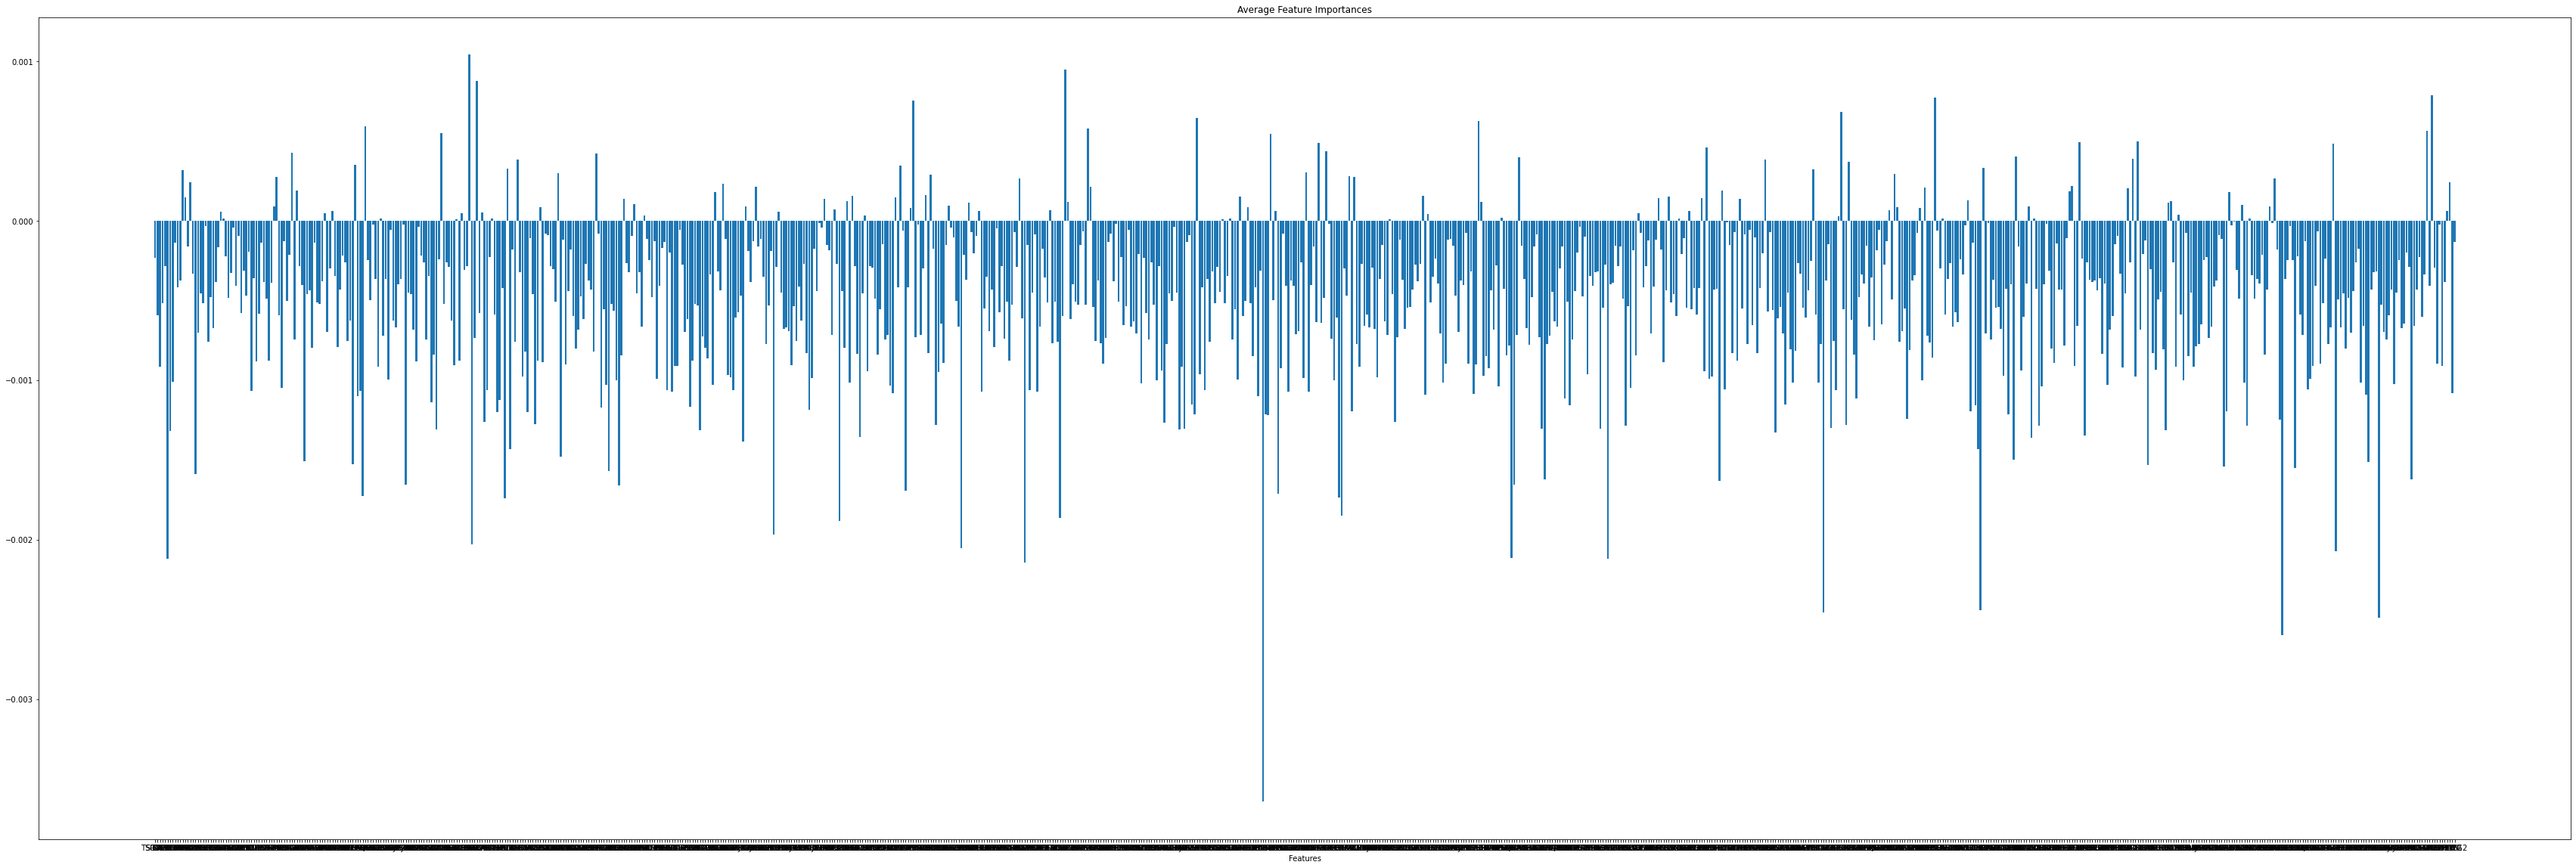

In [65]:
# visualize_importances(all_feat, np.mean(folds[0], axis=0))
# visualize_importances(all_feat, mean_folds)
visualize_importances(all_feat[18:], mean_folds[18:])

In [54]:
# shap.summary_plot(features=all_feat, feature_names=all_feat)

In [63]:
list(range(30))[18:]

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

In [64]:
list(range(30))[:18]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [ ]:
Drug2_IsInRing :  -0.196
TSPAN6 :  -0.000
